# Experimentación - MSTGCN


https://ojs.aaai.org/index.php/AAAI/article/view/3881

## 1. Obtención de datos



In [1]:
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import networkx as nx
sns.set_palette("coolwarm_r")
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload  # Python 3.4+


import os, sys

path = os.getcwd()

sys.path.insert(1, "/".join(path.split("/")[0:-1]))


from utils import powergrid

In [2]:
#folder_path = "/home/TFM/code_dataset2/datos/Natural Oscillation"
folder_path = "/Users/maguado/Documents/UGR/Master/TFM/datos_2/Natural Oscillation"

In [3]:
results_save_path = "./results"
name_model = "MSTGCN"

In [4]:
loader = powergrid.PowerGridDatasetLoader(folder_path, problem="regression")
_,_,_ =loader.process()
limit = 300
#dataset_full = loader.get_dataset( target= 20, intro=300, step=20, limit=limit, one_ts_per_situation=False)

Processing dataset...
Processing:  row_307
Node:  0  not included, including...
Node:  1  not included, including...
Node:  2  not included, including...
Node:  3  not included, including...
Node:  4  not included, including...
Node:  5  not included, including...
Node:  6  not included, including...
Node:  7  not included, including...
Node:  8  not included, including...
Node:  9  not included, including...
Node:  10  not included, including...
Node:  11  not included, including...
Node:  12  not included, including...
Node:  13  not included, including...
Node:  14  not included, including...
Node:  15  not included, including...
Node:  16  not included, including...
Node:  17  not included, including...
Node:  18  not included, including...
Node:  19  not included, including...
Node:  20  not included, including...
Node:  21  not included, including...
Node:  22  not included, including...
Processing:  row_135
Processing:  row_75
Processing:  row_338
Processing:  row_81
Processing:

## Funciones auxiliares - entrenamiento

In [5]:
from utils import pygt_loader

try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable


import torch
import torch.nn.functional as F
from utils.utils_graph import format_plot
from utils.utils_graph import plot_training_and_eval_losses, plot_predictions
from utils.general_nn import guardar_resultados



from utils.trainer import TrainerMSTGCN
from utils.models import MSTGCNModel


In [6]:
import itertools

def entrenar_y_evaluar_modelos_mstgcn(param_grid, dataset, dataloader_params, num_early_stop, num_epochs, problem="", device = torch.device("cpu")):
    resultados_list = []

    n_nodes = dataset.features[0].shape[0]
    n_target = dataset.targets[0].shape[1]
    n_features = dataset[0].x.shape[1]

    mejor_loss_test = float('inf')
    mejor_trainer = None
    mejores_parametros = None
    mejores_resultados = None
    

    for nb_block, filter_, time_strides, hidden in tqdm(list(itertools.product(param_grid['nb_block'], param_grid['filter'], param_grid['time_strides'], param_grid['hidden']))):
        print(f"Entrenando modelo con nb_block={nb_block}, nb_chev_filter={filter_}, nb_time_filter={filter_}, time_strides={time_strides}, hidden={hidden}")        
        model = MSTGCNModel(name="MSTGCN", node_features=n_features, node_count=n_nodes, n_target=n_target, nb_block=nb_block, k=2, nb_chev_filter = filter_, nb_time_filter =filter_,hidden=hidden, time_strides = time_strides)
        
        trainer = TrainerMSTGCN(model, dataset, device, f"./results/{problem}", dataloader_params)

        losses, eval_losses, r2scores = trainer.train(num_epochs=num_epochs, steps=200, num_early_stop=num_early_stop)
        r2score_tst, losses_tst, loss_nodes, _, _ = trainer.test()
    
        results_intermedio = {
            "nb_block": nb_block,
            "nb_chev_filter": filter_,
            "nb_time_filter": filter_,
            "hidden": hidden,
            "time_strides": time_strides,
            "loss_final": losses[-1],
            "r2_eval_final": np.mean(r2scores[-1]),
            "loss_eval_final": np.mean(eval_losses[-1]),
            "r2_test": np.mean(r2score_tst),
            "loss_test": np.mean(losses_tst),
            "loss_nodes": np.mean(loss_nodes, axis=0).tolist()
        }
        
        resultados_list.append(results_intermedio)

        if np.mean(losses_tst) < mejor_loss_test:
            mejor_loss_test = np.mean(losses_tst)
            mejor_trainer = trainer
            mejores_parametros = {
                "nb_block": nb_block,
                "nb_chev_filter": filter_,
                "nb_time_filter": filter_,
                "time_strides": time_strides,
                "hidden": hidden
            }
            mejores_resultados = results_intermedio

        print("Resultados intermedios: ", results_intermedio)

    resultados_gt = pd.DataFrame(resultados_list)

    return mejor_trainer, mejores_parametros, mejores_resultados, resultados_gt

## Prueba - predicción por tipos

In [7]:
dataloader_params2 = {
            "batch_size": 5,
            "data_split_ratio": [0.7, 0.15, 0.15],
            "seed": 42,
            "keep_same": True,
            "use_batch":False
}

param_grid = {
    "nb_block": [1, 2],
    "filter": [2,4,8],
    "time_strides": [2,5,10],
    "hidden":[50,80,100]
}

device = torch.device("cpu")
num_early_stop = 10
num_epochs = 100
lr = 0.01

### Gen trip

In [8]:
problem_gt = "gen_trip"
dataset_gt, situations_gt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_gt)



Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  184


In [9]:
n_div_gt = loader.div
n_nodes =dataset_gt.features[0].shape[0]
n_target = dataset_gt.targets[0].shape[1]
n_features = dataset_gt[0].x.shape[1]
hidden_size =100

#### Sencilla 

In [12]:

device = torch.device("cpu")
model_gt = MSTGCNModel(name="MSTGCN", node_features=n_features, node_count=n_nodes, n_target=n_target, nb_block=2, k=2, nb_chev_filter = 8, nb_time_filter =8, time_strides = 2, hidden=100)

trainer_gt = TrainerMSTGCN(model_gt, dataset_gt,device, f"./results/{problem_gt}", dataloader_params2)

losses,eval_losses, r2scores  = trainer_gt.train(num_epochs=num_epochs, steps=200, num_early_stop=num_early_stop)




==================== DATASET INFO ===================

Train dataset: 4352
Validation dataset: 918
Test dataset: 952

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 0.3777 | Eval Loss: 0.3183 | Eval R2: -139.0249 | LR: 0.0010 | 
Epoch 2/100 | Train Loss: 0.3023 | Eval Loss: 0.2983 | Eval R2: -129.3339 | LR: 0.0010 | 
Epoch 3/100 | Train Loss: 0.2963 | Eval Loss: 0.2947 | Eval R2: -127.8949 | LR: 0.0010 | 
Epoch 4/100 | Train Loss: 0.2956 | Eval Loss: 0.2934 | Eval R2: -127.5072 | LR: 0.0010 | 
Epoch 5/100 | Train Loss: 0.2946 | Eval Loss: 0.2906 | Eval R2: -126.8460 | LR: 0.0010 | 
Epoch 6/100 | Train Loss: 0.2909 | Eval Loss: 0.2832 | Eval R2: -125.4750 | LR: 0.0010 | 
Epoch 7/100 | Train Loss: 0.2798 | Eval Loss: 0.2724 | Eval R2: -125.9903 | LR: 0.0010 | 
Epoch 8/100 | Train Loss: 0.2644 | Eval Loss: 0.2505 | Eval R2: -118.6880 | LR: 0.0010 | 
Epoch 9/100 | Train Loss: 0.2028 | Eval Loss: 0.1379 | Eval R2: -61.1483 | LR: 0.0010 | 
Epoch 10/100 | Trai

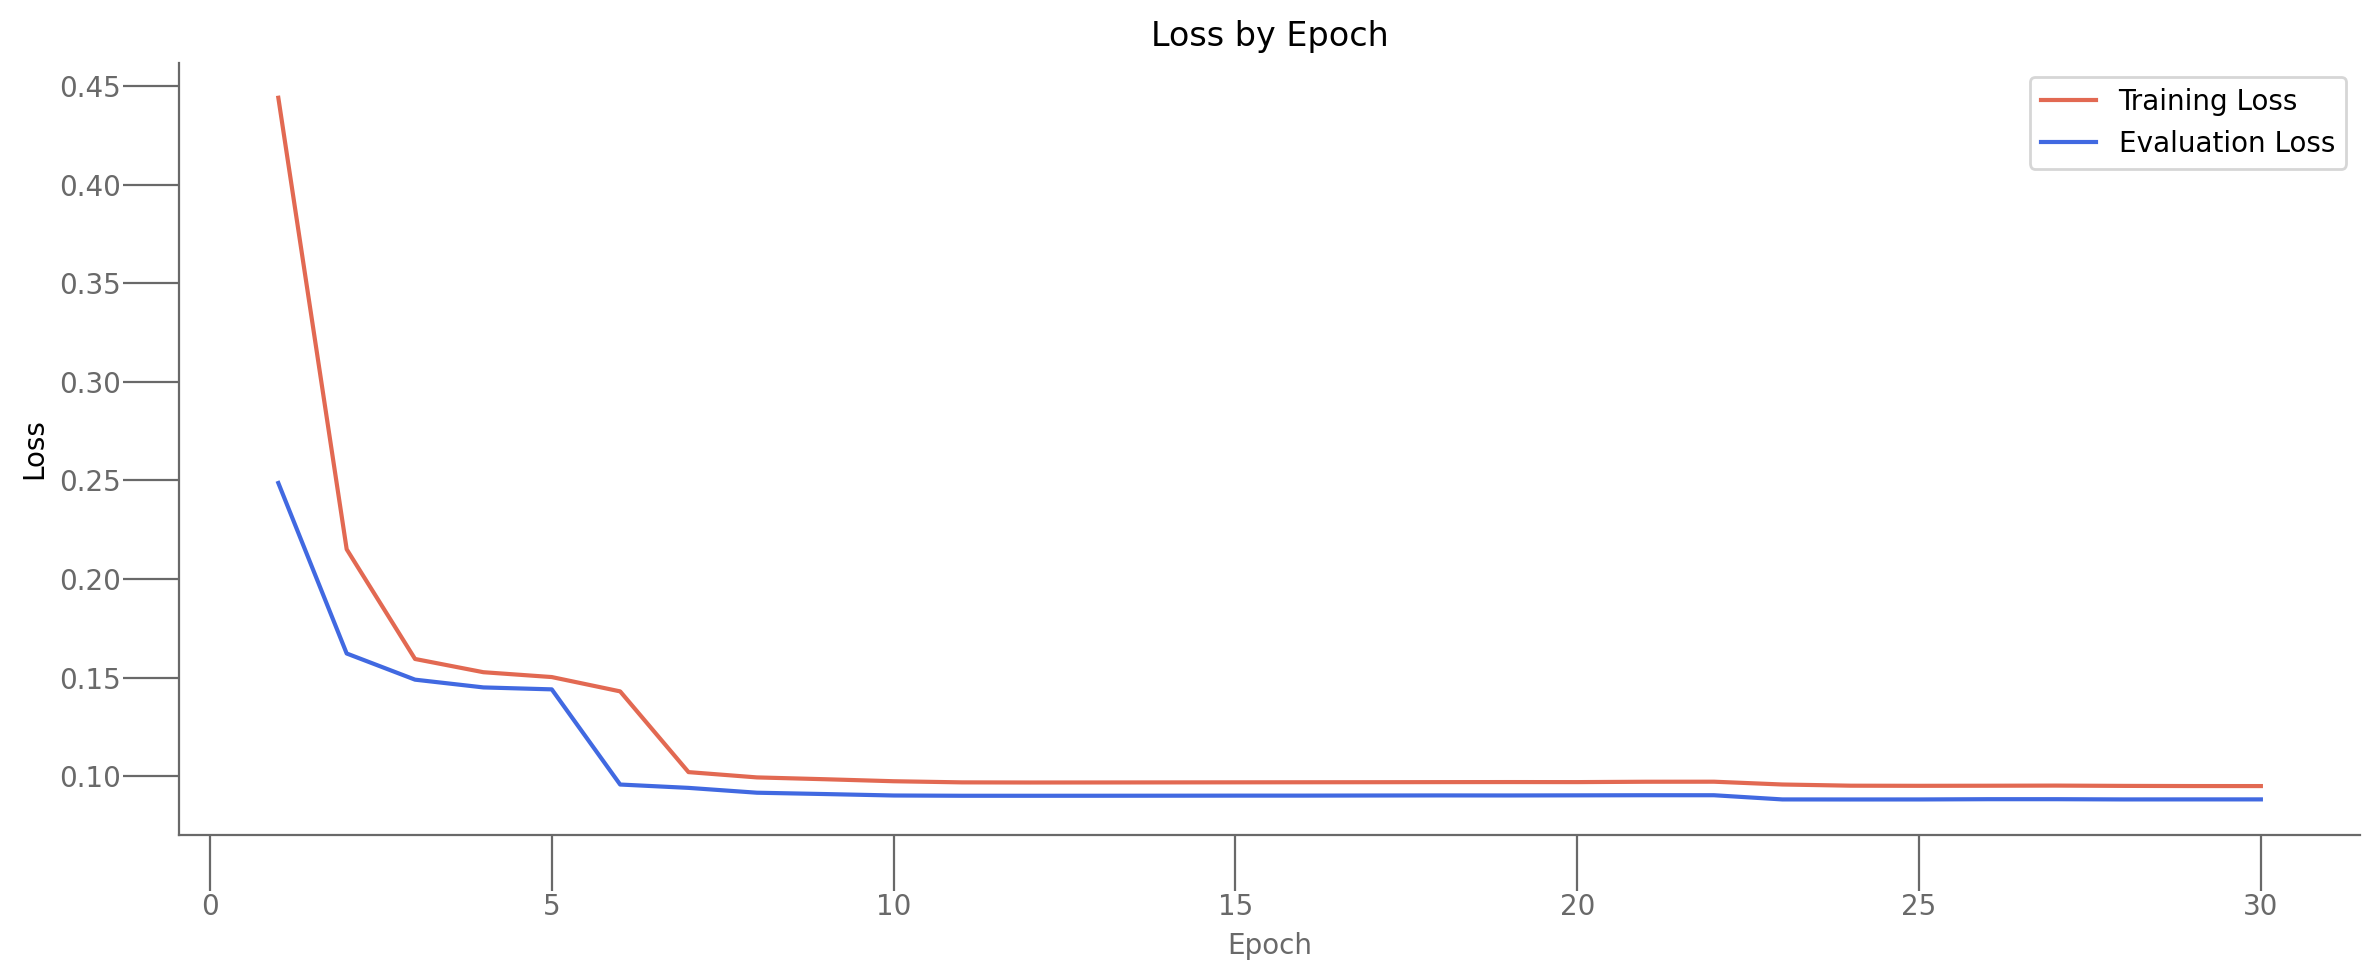


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.073295, test r2score -25.515827


In [13]:

plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_gt, real_gt = trainer_gt.test()


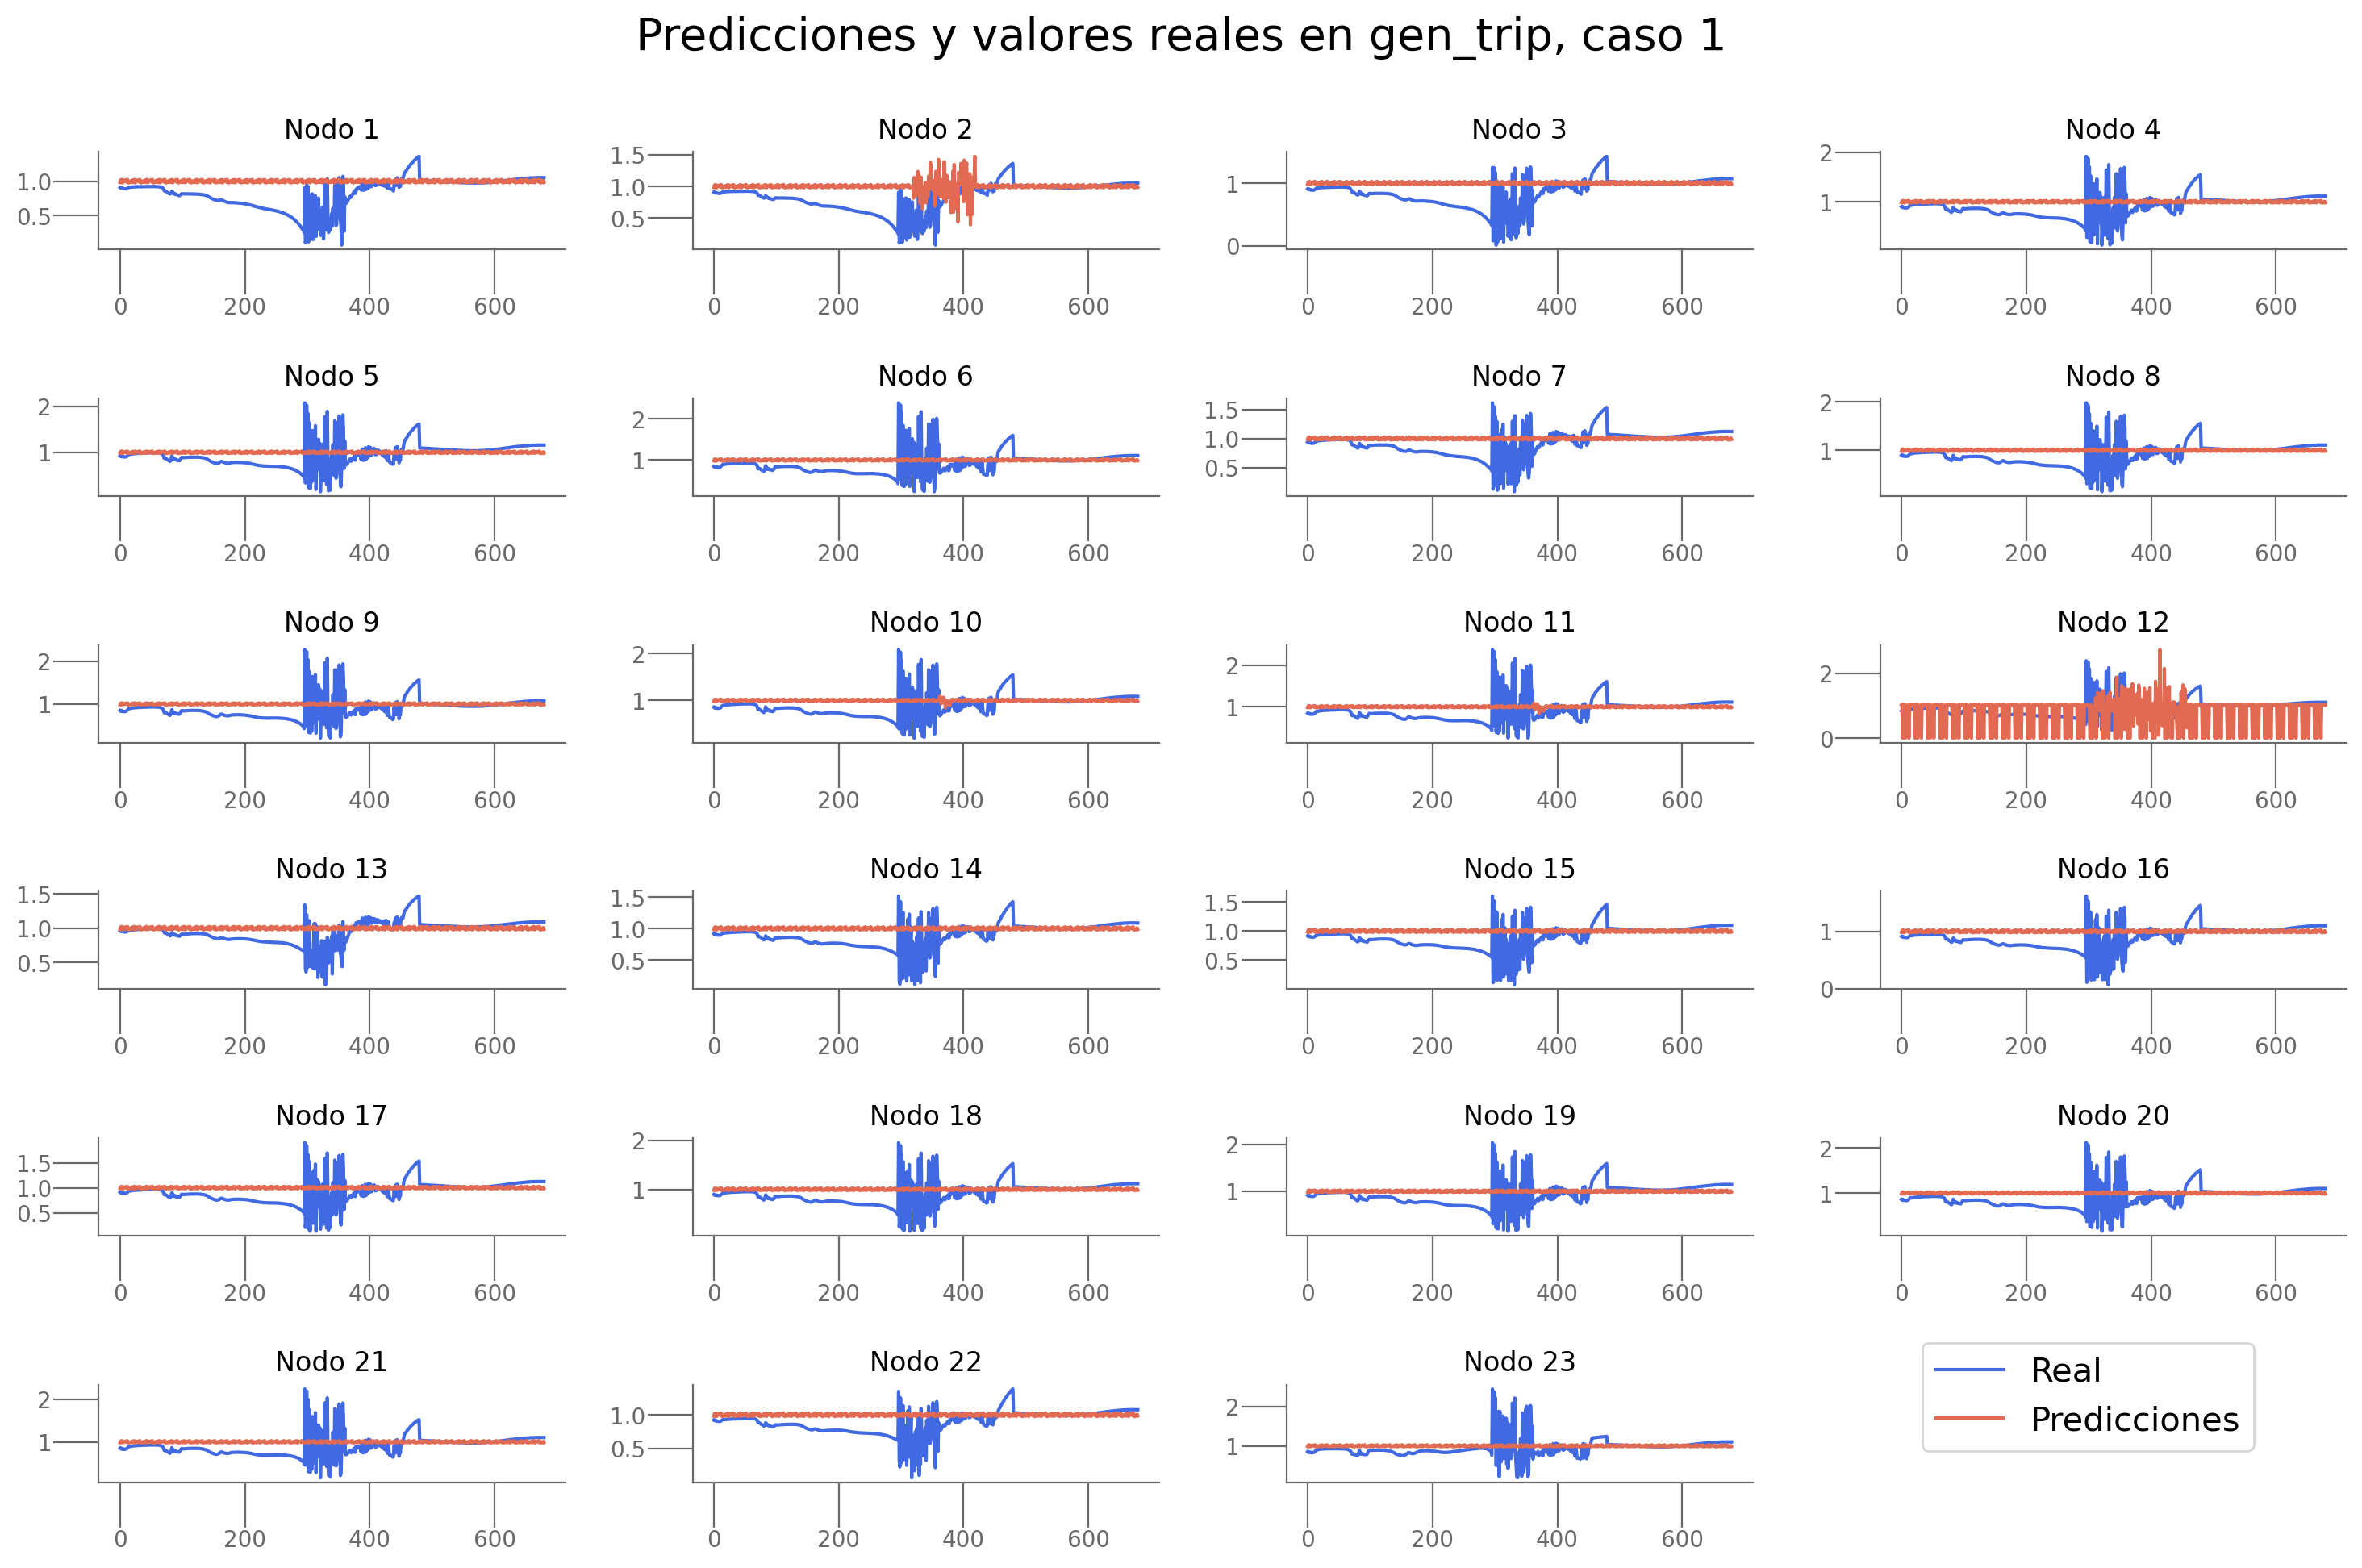

In [14]:
plot_predictions(predictions_gt, real_gt, n_target, 1, n_div_gt, problem_gt)

In [ ]:
trainer_gt.save_model(path_save_experiment="./results/gen_trip/ajustes/MSTGCN_results.csv", params={'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 2, 'hidden': 100})

#### Ajuste de parámetros 

In [10]:



num_epochs = 100
num_early_stop = 10

trainer_gt,params_gt, resultados_final_gt, resultados_gt = entrenar_y_evaluar_modelos_mstgcn(param_grid, dataset_gt, dataloader_params2, num_early_stop, num_epochs, problem=problem_gt)

  0%|          | 0/54 [00:00<?, ?it/s]

Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=50

==================== DATASET INFO ===================

Train dataset: 4352
Validation dataset: 918
Test dataset: 952

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 0.4027 | Eval Loss: 0.2893 | Eval R2: -123.1090 | LR: 0.0010 | 
Epoch 2/100 | Train Loss: 0.2345 | Eval Loss: 0.2067 | Eval R2: -81.8675 | LR: 0.0010 | 
Epoch 3/100 | Train Loss: 0.1838 | Eval Loss: 0.1525 | Eval R2: -55.1253 | LR: 0.0010 | 
Epoch 4/100 | Train Loss: 0.1564 | Eval Loss: 0.1512 | Eval R2: -54.8070 | LR: 0.0010 | 
Epoch 5/100 | Train Loss: 0.1545 | Eval Loss: 0.1500 | Eval R2: -54.4444 | LR: 0.0010 | 
Epoch 6/100 | Train Loss: 0.1540 | Eval Loss: 0.1495 | Eval R2: -54.3539 | LR: 0.0010 | 
Epoch 7/100 | Train Loss: 0.1540 | Eval Loss: 0.1495 | Eval R2: -54.3376 | LR: 0.0010 | 
Epoch 8/100 | Train Loss: 0.1539 | Eval Loss: 0.1493 | Eval R2: -54.3225 | LR: 0.0010 | 
Epoch 9/100 | Train

  2%|▏         | 1/54 [05:33<4:54:28, 333.37s/it]

preds:  (1, 23, 20)
test loss: 0.126558, test R2 score: -61.909555
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.1489221602678299, 'r2_eval_final': -51.84261703491211, 'loss_eval_final': 0.14370441436767578, 'r2_test': -61.90955456923086, 'loss_test': 0.12655824422836304, 'loss_nodes': [0.11582206934690475, 0.11435369402170181, 0.11512553691864014, 0.12433281540870667, 0.13705359399318695, 0.12927356362342834, 0.11828680336475372, 0.12500786781311035, 0.1250433623790741, 0.1184372827410698, 0.12896524369716644, 0.11685921251773834, 0.09492077678442001, 0.3180061876773834, 0.11098504066467285, 0.11077948659658432, 0.12360935658216476, 0.12106457352638245, 0.13257406651973724, 0.11980704963207245, 0.11988823115825653, 0.10135211795568466, 0.08929181098937988]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=80

==================== DATASET INFO ==============

  4%|▎         | 2/54 [11:00<4:45:36, 329.56s/it]

preds:  (1, 23, 20)
test loss: 0.045307, test R2 score: -15.874919
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.06513307243585587, 'r2_eval_final': -15.403105735778809, 'loss_eval_final': 0.05899706110358238, 'r2_test': -15.874918515277013, 'loss_test': 0.04530663415789604, 'loss_nodes': [0.06647544354200363, 0.06500627100467682, 0.029464740306138992, 0.08337952941656113, 0.09930358827114105, 0.089571014046669, 0.07747778296470642, 0.031137114390730858, 0.03328988701105118, 0.028214232996106148, 0.03384381905198097, 0.029822316020727158, 0.01725858636200428, 0.06610522419214249, 0.022852223366498947, 0.02289898693561554, 0.0310109481215477, 0.0810578390955925, 0.03248908743262291, 0.02892877720296383, 0.028838910162448883, 0.020308448001742363, 0.023317981511354446]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=100

==================== DATASET INFO ===

  6%|▌         | 3/54 [17:33<5:05:00, 358.82s/it]

preds:  (1, 23, 20)
test loss: 0.045703, test R2 score: -16.434269
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.0647018626332283, 'r2_eval_final': -15.8074312210083, 'loss_eval_final': 0.059363361448049545, 'r2_test': -16.43426920551204, 'loss_test': 0.04570339620113373, 'loss_nodes': [0.06648897379636765, 0.06501980125904083, 0.029301242902874947, 0.08343284577131271, 0.09929254651069641, 0.08963017165660858, 0.07753190398216248, 0.031963784247636795, 0.034310635179281235, 0.028037842363119125, 0.03409948572516441, 0.03082912229001522, 0.018548134714365005, 0.06615670770406723, 0.02267378568649292, 0.02271856553852558, 0.03222472220659256, 0.08110097795724869, 0.03238965570926666, 0.02874183841049671, 0.029197977855801582, 0.02226055972278118, 0.025226715952157974]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=50

==================== DATASET INFO ===

  7%|▋         | 4/54 [22:39<4:41:30, 337.81s/it]

preds:  (1, 23, 20)
test loss: 0.326102, test R2 score: -192.099400
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.3464535176753998, 'r2_eval_final': -154.27540588378906, 'loss_eval_final': 0.3454318940639496, 'r2_test': -192.09939960264953, 'loss_test': 0.32610201835632324, 'loss_nodes': [0.2945677936077118, 0.2931223213672638, 0.3037042021751404, 0.336250901222229, 0.3660781979560852, 0.3461766839027405, 0.33070045709609985, 0.33543941378593445, 0.32943522930145264, 0.32282036542892456, 0.34685608744621277, 0.3223120868206024, 0.30494171380996704, 0.3175540566444397, 0.322734534740448, 0.3222269117832184, 0.3410898745059967, 0.3368629515171051, 0.3575018644332886, 0.33243656158447266, 0.33260321617126465, 0.3102307617664337, 0.2946997880935669]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=80

==================== DATASET INFO ===================

Train

  9%|▉         | 5/54 [27:31<4:22:24, 321.31s/it]

preds:  (1, 23, 20)
test loss: 0.326102, test R2 score: -192.099400
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.3464535176753998, 'r2_eval_final': -154.27540588378906, 'loss_eval_final': 0.3454318940639496, 'r2_test': -192.0994001983023, 'loss_test': 0.32610201835632324, 'loss_nodes': [0.2945677638053894, 0.2931223213672638, 0.3037042021751404, 0.336250901222229, 0.3660781681537628, 0.3461766839027405, 0.33070045709609985, 0.33543944358825684, 0.329435259103775, 0.32282036542892456, 0.34685608744621277, 0.3223120868206024, 0.30494171380996704, 0.3175540566444397, 0.322734534740448, 0.3222269117832184, 0.3410898745059967, 0.3368629217147827, 0.3575018644332886, 0.33243656158447266, 0.33260321617126465, 0.3102307915687561, 0.2946998178958893]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=100

==================== DATASET INFO ===================

Train d

 11%|█         | 6/54 [32:42<4:14:12, 317.76s/it]

preds:  (1, 23, 20)
test loss: 0.326102, test R2 score: -192.099399
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.3464535176753998, 'r2_eval_final': -154.27540588378906, 'loss_eval_final': 0.3454318940639496, 'r2_test': -192.09939921222144, 'loss_test': 0.32610201835632324, 'loss_nodes': [0.2945677936077118, 0.2931223213672638, 0.30370423197746277, 0.336250901222229, 0.3660781979560852, 0.3461766839027405, 0.33070048689842224, 0.33543941378593445, 0.329435259103775, 0.32282036542892456, 0.34685608744621277, 0.3223120868206024, 0.30494171380996704, 0.3175540566444397, 0.322734534740448, 0.3222269117832184, 0.3410898745059967, 0.3368629515171051, 0.3575018644332886, 0.33243656158447266, 0.3326032757759094, 0.3102307617664337, 0.2946997880935669]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=50

==================== DATASET INFO ===================

Train

 13%|█▎        | 7/54 [40:15<4:43:31, 361.95s/it]

preds:  (1, 23, 20)
test loss: 0.035469, test R2 score: -13.302080
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.051096417009830475, 'r2_eval_final': -12.21469497680664, 'loss_eval_final': 0.04307123273611069, 'r2_test': -13.302079690801598, 'loss_test': 0.03546854108572006, 'loss_nodes': [0.027642223984003067, 0.027776304632425308, 0.030444448813796043, 0.03916249796748161, 0.04644043743610382, 0.04617670178413391, 0.03323398903012276, 0.04047746583819389, 0.0451781190931797, 0.0380837544798851, 0.04590986669063568, 0.03701280802488327, 0.020688358694314957, 0.028908230364322662, 0.030614858493208885, 0.030555935576558113, 0.03811079263687134, 0.03743843734264374, 0.04425272345542908, 0.038617007434368134, 0.03941120579838753, 0.025726133957505226, 0.023914147168397903]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=80

==================== DATASET INF

 15%|█▍        | 8/54 [46:31<4:40:52, 366.37s/it]

preds:  (1, 23, 20)
test loss: 0.035426, test R2 score: -10.985206
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.05097592994570732, 'r2_eval_final': -10.983125686645508, 'loss_eval_final': 0.04414529725909233, 'r2_test': -10.985206208405996, 'loss_test': 0.0354260578751564, 'loss_nodes': [0.028524519875645638, 0.028103424236178398, 0.030739912763237953, 0.04024772346019745, 0.04725310951471329, 0.04612008109688759, 0.03407697752118111, 0.04069596529006958, 0.04414483159780502, 0.0379767045378685, 0.04470491036772728, 0.036861151456832886, 0.020018747076392174, 0.028645405545830727, 0.0305221788585186, 0.030478686094284058, 0.038601186126470566, 0.03783875331282616, 0.04392891749739647, 0.038273707032203674, 0.038706183433532715, 0.02482989989221096, 0.02350633777678013]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=100

==================== DATASET INF

 17%|█▋        | 9/54 [51:35<4:20:18, 347.08s/it]

preds:  (1, 23, 20)
test loss: 0.048196, test R2 score: -18.974676
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.06249254569411278, 'r2_eval_final': -16.496780395507812, 'loss_eval_final': 0.0564628429710865, 'r2_test': -18.974676315819583, 'loss_test': 0.04819624871015549, 'loss_nodes': [0.03811831772327423, 0.03775426745414734, 0.04069247469305992, 0.05303245410323143, 0.06153728812932968, 0.05812230706214905, 0.04635272175073624, 0.053872495889663696, 0.05683836713433266, 0.050391774624586105, 0.05850067362189293, 0.04996415972709656, 0.032185107469558716, 0.04246366024017334, 0.04471239820122719, 0.044605426490306854, 0.05289372801780701, 0.05171852186322212, 0.060452450066804886, 0.05121159926056862, 0.05354767665266991, 0.03823030740022659, 0.03131537139415741]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=50

==================== DATASET INFO ==

 19%|█▊        | 10/54 [56:54<4:08:09, 338.39s/it]

preds:  (1, 23, 20)
test loss: 0.228810, test R2 score: -141.748838
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.2338481992483139, 'r2_eval_final': -113.38673400878906, 'loss_eval_final': 0.2377539873123169, 'r2_test': -141.74883775019978, 'loss_test': 0.22881029546260834, 'loss_nodes': [0.19576764106750488, 0.19540420174598694, 0.20596501231193542, 0.2342236042022705, 0.2543669641017914, 0.24315127730369568, 0.23129673302173615, 0.23279789090156555, 0.22872063517570496, 0.22536782920360565, 0.24350279569625854, 0.2266693264245987, 0.2216705083847046, 0.22693593800067902, 0.228441521525383, 0.22816510498523712, 0.23889607191085815, 0.2369743436574936, 0.24959900975227356, 0.2342032939195633, 0.2359819859266281, 0.22279809415340424, 0.22173675894737244]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=80

==================== DATASET INFO ==================

 20%|██        | 11/54 [1:02:18<3:59:14, 333.82s/it]

preds:  (1, 23, 20)
test loss: 0.228810, test R2 score: -141.748842
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.23384827375411987, 'r2_eval_final': -113.38672637939453, 'loss_eval_final': 0.2377540022134781, 'r2_test': -141.7488415470778, 'loss_test': 0.2288104146718979, 'loss_nodes': [0.19576744735240936, 0.1954040229320526, 0.20596495270729065, 0.23422354459762573, 0.25436705350875854, 0.2431514859199524, 0.23129671812057495, 0.2327982634305954, 0.22872105240821838, 0.22536779940128326, 0.24350304901599884, 0.22666966915130615, 0.22167077660560608, 0.2269359678030014, 0.22844144701957703, 0.2281651794910431, 0.23889635503292084, 0.23697428405284882, 0.24959905445575714, 0.2342032641172409, 0.23598182201385498, 0.2227984070777893, 0.22173736989498138]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=100

==================== DATASET INFO ================

 22%|██▏       | 12/54 [1:07:57<3:54:53, 335.55s/it]

preds:  (1, 23, 20)
test loss: 0.228811, test R2 score: -141.748882
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.233848437666893, 'r2_eval_final': -113.38677215576172, 'loss_eval_final': 0.23775425553321838, 'r2_test': -141.74888174613108, 'loss_test': 0.2288106232881546, 'loss_nodes': [0.19576743245124817, 0.1954040229320526, 0.20596489310264587, 0.23422349989414215, 0.25436723232269287, 0.24315138161182404, 0.2312965989112854, 0.2327984720468521, 0.22872139513492584, 0.22536782920360565, 0.24350400269031525, 0.2266697883605957, 0.22167091071605682, 0.22693699598312378, 0.2284414917230606, 0.22816523909568787, 0.23889660835266113, 0.23697443306446075, 0.24959994852542877, 0.23420335352420807, 0.23598231375217438, 0.22279858589172363, 0.22173774242401123]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=50

==================== DATASET INFO ==============

 24%|██▍       | 13/54 [1:12:40<3:38:25, 319.64s/it]

preds:  (1, 23, 20)
test loss: 0.340470, test R2 score: -217.292508
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.3485650420188904, 'r2_eval_final': -172.32298278808594, 'loss_eval_final': 0.3539409339427948, 'r2_test': -217.29250794792355, 'loss_test': 0.34046992659568787, 'loss_nodes': [0.29301154613494873, 0.292467325925827, 0.3078685700893402, 0.3478212058544159, 0.37826991081237793, 0.3595941662788391, 0.34456074237823486, 0.3465665280818939, 0.3393934667110443, 0.3351747393608093, 0.3606052100658417, 0.33623573184013367, 0.331216961145401, 0.3377433717250824, 0.3415127992630005, 0.3410373032093048, 0.3560076057910919, 0.3524417579174042, 0.37080392241477966, 0.34832972288131714, 0.34946924448013306, 0.3332924544811249, 0.3273846209049225]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=80

==================== DATASET INFO ===================

Train 

 26%|██▌       | 14/54 [1:17:20<3:24:58, 307.47s/it]

preds:  (1, 23, 20)
test loss: 0.340470, test R2 score: -217.292493
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.34856483340263367, 'r2_eval_final': -172.32296752929688, 'loss_eval_final': 0.35394087433815, 'r2_test': -217.29249270087152, 'loss_test': 0.3404698371887207, 'loss_nodes': [0.2930115759372711, 0.2924673855304718, 0.30786848068237305, 0.34782111644744873, 0.3782697916030884, 0.3595941960811615, 0.3445605933666229, 0.34656646847724915, 0.33939334750175476, 0.335174560546875, 0.36060506105422974, 0.3362356126308441, 0.3312167823314667, 0.33774322271347046, 0.3415128290653229, 0.34103724360466003, 0.35600745677948, 0.35244157910346985, 0.3708038032054901, 0.3483295738697052, 0.3494691550731659, 0.3332924544811249, 0.32738471031188965]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=100

==================== DATASET INFO ===================

Train 

 28%|██▊       | 15/54 [1:21:59<3:14:22, 299.04s/it]

preds:  (1, 23, 20)
test loss: 0.340470, test R2 score: -217.292495
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.34856483340263367, 'r2_eval_final': -172.32296752929688, 'loss_eval_final': 0.35394087433815, 'r2_test': -217.29249512814326, 'loss_test': 0.3404698669910431, 'loss_nodes': [0.2930115759372711, 0.292467325925827, 0.30786848068237305, 0.34782126545906067, 0.3782697916030884, 0.3595941960811615, 0.3445606529712677, 0.3465665280818939, 0.3393933176994324, 0.33517447113990784, 0.36060506105422974, 0.33623573184013367, 0.3312167823314667, 0.33774319291114807, 0.3415127992630005, 0.3410372734069824, 0.35600751638412476, 0.3524416387081146, 0.3708037734031677, 0.34832963347435, 0.34946906566619873, 0.3332924544811249, 0.32738468050956726]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=50

==================== DATASET INFO ===================

Train

 30%|██▉       | 16/54 [1:26:32<3:04:21, 291.10s/it]

preds:  (1, 23, 20)
test loss: 0.011241, test R2 score: -3.945013
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.015862561762332916, 'r2_eval_final': -4.077944278717041, 'loss_eval_final': 0.016098396852612495, 'r2_test': -3.945012771969573, 'loss_test': 0.011240753345191479, 'loss_nodes': [0.006497102789580822, 0.006272331811487675, 0.007418906316161156, 0.01200930867344141, 0.014158648438751698, 0.016971349716186523, 0.008679348044097424, 0.012662789784371853, 0.0159467663615942, 0.012899520806968212, 0.016347886994481087, 0.012955608777701855, 0.004898594692349434, 0.007943372242152691, 0.008575393818318844, 0.0086625125259161, 0.011842712759971619, 0.012036056257784367, 0.013693319633603096, 0.013786048628389835, 0.014754295349121094, 0.006667029112577438, 0.012858414091169834]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=80

==================== D

 31%|███▏      | 17/54 [1:31:04<2:56:02, 285.48s/it]

preds:  (1, 23, 20)
test loss: 0.011241, test R2 score: -3.949282
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.015858100727200508, 'r2_eval_final': -4.08028507232666, 'loss_eval_final': 0.016099680215120316, 'r2_test': -3.949281749714601, 'loss_test': 0.011241279542446136, 'loss_nodes': [0.006508860271424055, 0.006283634342253208, 0.007425468415021896, 0.01200163271278143, 0.014151029288768768, 0.016963744536042213, 0.008672094903886318, 0.012661021202802658, 0.015947522595524788, 0.01290107797831297, 0.016347520053386688, 0.0129558639600873, 0.004900552798062563, 0.007951471954584122, 0.008574867621064186, 0.008662141859531403, 0.011839455924928188, 0.012033550068736076, 0.013690456748008728, 0.013786298222839832, 0.01475667953491211, 0.006668287329375744, 0.012866218574345112]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=100

==================== D

 33%|███▎      | 18/54 [1:38:18<3:18:03, 330.10s/it]

preds:  (1, 23, 20)
test loss: 0.011241, test R2 score: -3.945053
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.015862416476011276, 'r2_eval_final': -4.077995300292969, 'loss_eval_final': 0.016098417341709137, 'r2_test': -3.9450528616053417, 'loss_test': 0.011240747757256031, 'loss_nodes': [0.0064971428364515305, 0.006272374652326107, 0.007418937981128693, 0.01200933288782835, 0.014158658683300018, 0.016971418634057045, 0.008679324761033058, 0.012662806548178196, 0.015946820378303528, 0.01289957482367754, 0.016347886994481087, 0.012955647893249989, 0.004898613318800926, 0.007943445816636086, 0.008575439453125, 0.008662553504109383, 0.011842736043035984, 0.012036106549203396, 0.013692943379282951, 0.013786095194518566, 0.014753804542124271, 0.006667055655270815, 0.012858455069363117]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=50

====================

 35%|███▌      | 19/54 [1:46:09<3:37:08, 372.24s/it]

preds:  (1, 23, 20)
test loss: 0.062678, test R2 score: -37.692432
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.06509911268949509, 'r2_eval_final': -30.077611923217773, 'loss_eval_final': 0.06707114726305008, 'r2_test': -37.692432283673455, 'loss_test': 0.06267813593149185, 'loss_nodes': [0.05143807828426361, 0.05129910260438919, 0.05480804666876793, 0.06419727951288223, 0.07012093812227249, 0.06910160928964615, 0.06159624829888344, 0.06426844000816345, 0.0650671198964119, 0.06265807151794434, 0.06946344673633575, 0.06343334913253784, 0.05732094123959541, 0.06040177866816521, 0.06132815033197403, 0.061316922307014465, 0.06545590609312057, 0.06500130891799927, 0.0693739801645279, 0.06550663709640503, 0.0668354406952858, 0.05877591297030449, 0.06282849609851837]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=80

==================== DATASET INFO ==========

 37%|███▋      | 20/54 [1:51:49<3:25:28, 362.59s/it]

preds:  (1, 23, 20)
test loss: 0.062678, test R2 score: -37.692427
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.06509912759065628, 'r2_eval_final': -30.077608108520508, 'loss_eval_final': 0.06707117706537247, 'r2_test': -37.69242677266097, 'loss_test': 0.06267814338207245, 'loss_nodes': [0.0514380969107151, 0.05129910632967949, 0.05480799823999405, 0.06419729441404343, 0.07012097537517548, 0.06910162419080734, 0.06159630045294762, 0.06426847726106644, 0.06506726145744324, 0.06265804171562195, 0.06946342438459396, 0.06343340873718262, 0.05732102692127228, 0.06040184944868088, 0.061328135430812836, 0.06131688505411148, 0.06545587629079819, 0.06500135362148285, 0.0693739503622055, 0.06550665944814682, 0.0668354332447052, 0.05877593159675598, 0.06282845884561539]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=100

==================== DATASET INFO ==========

 39%|███▉      | 21/54 [1:57:33<3:16:28, 357.23s/it]

preds:  (1, 23, 20)
test loss: 0.062678, test R2 score: -37.692409
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.0650990903377533, 'r2_eval_final': -30.07759666442871, 'loss_eval_final': 0.06707113236188889, 'r2_test': -37.69240948132996, 'loss_test': 0.06267812103033066, 'loss_nodes': [0.05143803358078003, 0.0512990765273571, 0.05480799451470375, 0.06419727951288223, 0.0701209306716919, 0.06910157948732376, 0.06159626692533493, 0.06426841020584106, 0.06506725400686264, 0.06265805661678314, 0.06946338713169098, 0.06343336403369904, 0.057320959866046906, 0.06040184572339058, 0.06132813170552254, 0.06131686642765999, 0.06545592099428177, 0.06500130891799927, 0.06937386095523834, 0.06550662964582443, 0.06683538854122162, 0.058775920420885086, 0.06282849609851837]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=50

==================== DATASET INFO ==========

 41%|████      | 22/54 [2:02:34<3:01:26, 340.21s/it]

preds:  (1, 23, 20)
test loss: 0.008882, test R2 score: -3.064537
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.012105804868042469, 'r2_eval_final': -2.9946038722991943, 'loss_eval_final': 0.012960207648575306, 'r2_test': -3.0645365986126083, 'loss_test': 0.008882374502718449, 'loss_nodes': [0.004977201111614704, 0.004837475251406431, 0.0056004649959504604, 0.009519991464912891, 0.010758292861282825, 0.013256005011498928, 0.0069657983258366585, 0.009720399044454098, 0.012710143812000751, 0.009870080277323723, 0.013493672013282776, 0.010878153145313263, 0.0038514777552336454, 0.006593812257051468, 0.006493088789284229, 0.006569113582372665, 0.008942466229200363, 0.009397058747708797, 0.010735305026173592, 0.010566172190010548, 0.01216360367834568, 0.005084637552499771, 0.011310210451483727]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=80

===============

 43%|████▎     | 23/54 [2:07:41<2:50:35, 330.17s/it]

preds:  (1, 23, 20)
test loss: 0.008882, test R2 score: -3.064479
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.012105789966881275, 'r2_eval_final': -2.994558334350586, 'loss_eval_final': 0.012960140593349934, 'r2_test': -3.064479495248431, 'loss_test': 0.00888232234865427, 'loss_nodes': [0.004977062810212374, 0.004837332293391228, 0.005600414704531431, 0.009520009160041809, 0.010758230462670326, 0.013256005942821503, 0.006965784355998039, 0.009720321744680405, 0.012710059061646461, 0.00987003743648529, 0.013493677601218224, 0.010878074914216995, 0.003851386019960046, 0.006593806203454733, 0.0064930482767522335, 0.0065690637566149235, 0.008942407555878162, 0.009396961890161037, 0.010735313408076763, 0.01056614052504301, 0.012163600884377956, 0.005084562115371227, 0.011310124769806862]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=100

===================

 44%|████▍     | 24/54 [2:12:44<2:41:00, 322.01s/it]

preds:  (1, 23, 20)
test loss: 0.008882, test R2 score: -3.064494
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.012105807662010193, 'r2_eval_final': -2.9945647716522217, 'loss_eval_final': 0.012960127554833889, 'r2_test': -3.0644941756351662, 'loss_test': 0.008882332593202591, 'loss_nodes': [0.004977119155228138, 0.004837401211261749, 0.005600419361144304, 0.009520035237073898, 0.010758282616734505, 0.013256043195724487, 0.0069657908752560616, 0.009720307774841785, 0.012710029259324074, 0.009870044887065887, 0.01349371112883091, 0.010878060013055801, 0.003851398592814803, 0.006593775935471058, 0.006493070162832737, 0.006569093093276024, 0.008942379616200924, 0.009396964684128761, 0.010735311545431614, 0.01056615449488163, 0.012163643725216389, 0.005084552802145481, 0.011310091242194176]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=50

================

 46%|████▋     | 25/54 [2:17:30<2:30:31, 311.45s/it]

preds:  (1, 23, 20)
test loss: 0.011591, test R2 score: -4.426427
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.015054786577820778, 'r2_eval_final': -4.1951704025268555, 'loss_eval_final': 0.01583629474043846, 'r2_test': -4.426426561087187, 'loss_test': 0.011590731330215931, 'loss_nodes': [0.006689857691526413, 0.006503463257104158, 0.007721879053860903, 0.012064388953149319, 0.014067040756344795, 0.01717803254723549, 0.008928847499191761, 0.012700957246124744, 0.016437575221061707, 0.013013754971325397, 0.017370333895087242, 0.013748534955084324, 0.005276516079902649, 0.008024714887142181, 0.008805516175925732, 0.008897521533071995, 0.011740734800696373, 0.012269015423953533, 0.014043312519788742, 0.013831413350999355, 0.015891259536147118, 0.007046251092106104, 0.014335894957184792]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=80

==================

 48%|████▊     | 26/54 [2:22:19<2:22:07, 304.57s/it]

preds:  (1, 23, 20)
test loss: 0.011591, test R2 score: -4.426325
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.015054735355079174, 'r2_eval_final': -4.195108413696289, 'loss_eval_final': 0.015836192294955254, 'r2_test': -4.426325440254697, 'loss_test': 0.01159060187637806, 'loss_nodes': [0.006689808331429958, 0.006503392476588488, 0.0077216443605721, 0.0120640704408288, 0.01406703982502222, 0.017177749425172806, 0.008928547613322735, 0.012700810097157955, 0.01643744297325611, 0.013013552874326706, 0.01737035997211933, 0.013748420402407646, 0.005276351701468229, 0.008024402894079685, 0.008805396035313606, 0.008897396735846996, 0.011740626767277718, 0.01226898841559887, 0.01404334232211113, 0.013831221498548985, 0.015891291201114655, 0.0070460885763168335, 0.014335867017507553]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=100

==================== DATA

 50%|█████     | 27/54 [2:27:07<2:14:48, 299.58s/it]

preds:  (1, 23, 20)
test loss: 0.011591, test R2 score: -4.426393
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.015054753981530666, 'r2_eval_final': -4.195149898529053, 'loss_eval_final': 0.015836255624890327, 'r2_test': -4.426393056646362, 'loss_test': 0.011590692214667797, 'loss_nodes': [0.0066897813230752945, 0.006503353826701641, 0.007721734698861837, 0.01206438522785902, 0.01406701561063528, 0.017177928239107132, 0.008928840979933739, 0.012700915336608887, 0.016437536105513573, 0.013013655319809914, 0.017370428889989853, 0.013748525641858578, 0.005276461597532034, 0.008024543523788452, 0.008805477060377598, 0.008897474966943264, 0.011740711517632008, 0.012268937192857265, 0.014043431729078293, 0.01383129507303238, 0.015891335904598236, 0.007046188693493605, 0.014335919171571732]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=50

===================

 52%|█████▏    | 28/54 [2:36:42<2:45:40, 382.32s/it]

preds:  (1, 23, 20)
test loss: 0.117214, test R2 score: -56.375134
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.13924209773540497, 'r2_eval_final': -47.30424499511719, 'loss_eval_final': 0.13370826840400696, 'r2_test': -56.37513389496495, 'loss_test': 0.11721377819776535, 'loss_nodes': [0.11723282188177109, 0.11576183140277863, 0.11600367724895477, 0.1240014061331749, 0.1358458697795868, 0.12868155539035797, 0.11793021857738495, 0.1243630200624466, 0.1250881552696228, 0.11849269270896912, 0.1283315271139145, 0.11774491518735886, 0.09468849748373032, 0.10727142542600632, 0.11063326150178909, 0.11045212298631668, 0.1225941851735115, 0.12052235007286072, 0.1311894804239273, 0.11942315101623535, 0.11913112550973892, 0.10117721557617188, 0.08935646712779999]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=80

==================== DATASET INFO =================

 54%|█████▎    | 29/54 [2:47:03<3:09:02, 453.69s/it]

preds:  (1, 23, 20)
test loss: 0.117218, test R2 score: -56.375680
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.13924261927604675, 'r2_eval_final': -47.30471420288086, 'loss_eval_final': 0.1337166577577591, 'r2_test': -56.37567981977668, 'loss_test': 0.11721780896186829, 'loss_nodes': [0.11722870916128159, 0.11575779318809509, 0.11600083112716675, 0.12400127202272415, 0.13584761321544647, 0.12868201732635498, 0.11793019622564316, 0.1243627741932869, 0.12508715689182281, 0.11849170178174973, 0.1283320039510727, 0.117754727602005, 0.09478101879358292, 0.10727100074291229, 0.11063322424888611, 0.11045205593109131, 0.12259473651647568, 0.12052272260189056, 0.13119074702262878, 0.11942315846681595, 0.11913111805915833, 0.10117670893669128, 0.08935564756393433]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=100

==================== DATASET INFO ==============

 56%|█████▌    | 30/54 [2:56:50<3:17:34, 493.93s/it]

preds:  (1, 23, 20)
test loss: 0.117222, test R2 score: -56.375583
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.13926242291927338, 'r2_eval_final': -47.30663299560547, 'loss_eval_final': 0.13372722268104553, 'r2_test': -56.37558278060206, 'loss_test': 0.11722225695848465, 'loss_nodes': [0.11722079664468765, 0.115749791264534, 0.11599040776491165, 0.12400120496749878, 0.13585180044174194, 0.12868335843086243, 0.11793021112680435, 0.1243625059723854, 0.12508539855480194, 0.11848985403776169, 0.12833352386951447, 0.11780630797147751, 0.09485465288162231, 0.10726849734783173, 0.11063283681869507, 0.11045195162296295, 0.12259631603956223, 0.12052393704652786, 0.13119396567344666, 0.11942330002784729, 0.11913137137889862, 0.10117603093385696, 0.0893540233373642]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=50

==================== DATASET INFO =============

 57%|█████▋    | 31/54 [3:05:30<3:12:17, 501.63s/it]

preds:  (1, 23, 20)
test loss: 0.169263, test R2 score: -89.620299
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.1905590444803238, 'r2_eval_final': -73.73857879638672, 'loss_eval_final': 0.18687798082828522, 'r2_test': -89.62029935562532, 'loss_test': 0.16926290094852448, 'loss_nodes': [0.1606641709804535, 0.15919342637062073, 0.16224774718284607, 0.17698484659194946, 0.19377586245536804, 0.18311867117881775, 0.17106656730175018, 0.17702069878578186, 0.17590714991092682, 0.16928867995738983, 0.18304258584976196, 0.1679263561964035, 0.14719706773757935, 0.15976765751838684, 0.16360005736351013, 0.1633192002773285, 0.17728595435619354, 0.1746208667755127, 0.1880376636981964, 0.17261788249015808, 0.17246222496032715, 0.15336140990257263, 0.14053873717784882]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=80

==================== DATASET INFO ================

 59%|█████▉    | 32/54 [3:14:34<3:08:36, 514.40s/it]

preds:  (1, 23, 20)
test loss: 0.065185, test R2 score: -21.372101
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.0870554968714714, 'r2_eval_final': -19.84152603149414, 'loss_eval_final': 0.0810045450925827, 'r2_test': -21.372100591689932, 'loss_test': 0.06518539786338806, 'loss_nodes': [0.07199224084615707, 0.07050915062427521, 0.06856929510831833, 0.07131605595350266, 0.07924677431583405, 0.07489334791898727, 0.06510978937149048, 0.07193296402692795, 0.0741616040468216, 0.06754507124423981, 0.07431095093488693, 0.0656815618276596, 0.04242260009050369, 0.05497065559029579, 0.057937849313020706, 0.05781994014978409, 0.06853508949279785, 0.066940538585186, 0.07544165104627609, 0.06658972054719925, 0.06620018929243088, 0.04907185956835747, 0.03806538134813309]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=100

==================== DATASET INFO =============

 61%|██████    | 33/54 [3:23:00<2:59:06, 511.75s/it]

preds:  (1, 23, 20)
test loss: 0.169262, test R2 score: -89.617627
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.19055400788784027, 'r2_eval_final': -73.73783111572266, 'loss_eval_final': 0.18687717616558075, 'r2_test': -89.61762736588253, 'loss_test': 0.1692618429660797, 'loss_nodes': [0.16065600514411926, 0.1591852605342865, 0.1622418612241745, 0.17697826027870178, 0.19378019869327545, 0.183119997382164, 0.17106685042381287, 0.1770206093788147, 0.17590539157390594, 0.1692865788936615, 0.18304431438446045, 0.16792462766170502, 0.1471966803073883, 0.15976716578006744, 0.16360002756118774, 0.16331897675991058, 0.17728759348392487, 0.17462188005447388, 0.18804112076759338, 0.172618106007576, 0.1724628210067749, 0.15336059033870697, 0.14053741097450256]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=50

==================== DATASET INFO ===================

 63%|██████▎   | 34/54 [3:31:14<2:48:47, 506.38s/it]

preds:  (1, 23, 20)
test loss: 0.221968, test R2 score: -122.801180
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.2423604130744934, 'r2_eval_final': -100.18856048583984, 'loss_eval_final': 0.24060796201229095, 'r2_test': -122.80117991266553, 'loss_test': 0.2219681590795517, 'loss_nodes': [0.20488901436328888, 0.2034303992986679, 0.209292471408844, 0.23061802983283997, 0.2521543800830841, 0.23827633261680603, 0.22474847733974457, 0.2303779274225235, 0.2275940328836441, 0.22092118859291077, 0.23849967122077942, 0.21990874409675598, 0.20006214082241058, 0.2126140147447586, 0.21698424220085144, 0.2166289985179901, 0.23251986503601074, 0.22930841147899628, 0.24537000060081482, 0.2265024036169052, 0.22649553418159485, 0.2057674676179886, 0.19230474531650543]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=80

==================== DATASET INFO =================

 65%|██████▍   | 35/54 [3:39:33<2:39:42, 504.36s/it]

preds:  (1, 23, 20)
test loss: 0.221968, test R2 score: -122.801181
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.2423604130744934, 'r2_eval_final': -100.18856048583984, 'loss_eval_final': 0.24060796201229095, 'r2_test': -122.80118067700184, 'loss_test': 0.2219681590795517, 'loss_nodes': [0.20488901436328888, 0.2034304291009903, 0.2092924863100052, 0.23061802983283997, 0.2521543800830841, 0.23827633261680603, 0.22474847733974457, 0.23037788271903992, 0.2275940477848053, 0.22092118859291077, 0.23849967122077942, 0.2199086993932724, 0.20006214082241058, 0.2126140147447586, 0.21698424220085144, 0.2166290283203125, 0.23251986503601074, 0.22930841147899628, 0.24537000060081482, 0.2265024334192276, 0.22649556398391724, 0.2057674676179886, 0.19230477511882782]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=100

==================== DATASET INFO ===============

 67%|██████▋   | 36/54 [3:48:40<2:35:06, 517.01s/it]

preds:  (1, 23, 20)
test loss: 0.221968, test R2 score: -122.801180
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.2423604130744934, 'r2_eval_final': -100.18856048583984, 'loss_eval_final': 0.24060796201229095, 'r2_test': -122.80118041432034, 'loss_test': 0.2219681590795517, 'loss_nodes': [0.20488901436328888, 0.2034303992986679, 0.209292471408844, 0.23061801493167877, 0.2521544098854065, 0.23827633261680603, 0.22474847733974457, 0.2303778976202011, 0.2275940328836441, 0.22092118859291077, 0.2384997010231018, 0.21990874409675598, 0.20006214082241058, 0.2126139998435974, 0.21698424220085144, 0.2166289985179901, 0.23251985013484955, 0.22930841147899628, 0.24537000060081482, 0.2265024334192276, 0.22649556398391724, 0.2057674676179886, 0.19230474531650543]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=50

==================== DATASET INFO ==================

 69%|██████▊   | 37/54 [3:58:42<2:33:43, 542.54s/it]

preds:  (1, 23, 20)
test loss: 0.009638, test R2 score: -3.348725
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.011751837097108364, 'r2_eval_final': -3.1143081188201904, 'loss_eval_final': 0.012984571978449821, 'r2_test': -3.3487254084983475, 'loss_test': 0.009637914597988129, 'loss_nodes': [0.00556325213983655, 0.005401174072176218, 0.007162999361753464, 0.009748635813593864, 0.01129289623349905, 0.013805125840008259, 0.007645323406904936, 0.010728609748184681, 0.013496545143425465, 0.010702180676162243, 0.013532121665775776, 0.011746023781597614, 0.004898739513009787, 0.0068485187366604805, 0.007726877462118864, 0.007804811000823975, 0.009979087859392166, 0.009694021195173264, 0.011183800175786018, 0.011833302676677704, 0.012672802433371544, 0.0060825347900390625, 0.01212264783680439]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=80

==================

 70%|███████   | 38/54 [4:08:29<2:28:15, 555.96s/it]

preds:  (1, 23, 20)
test loss: 0.009638, test R2 score: -3.348891
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.011751827783882618, 'r2_eval_final': -3.1145198345184326, 'loss_eval_final': 0.012984992004930973, 'r2_test': -3.3488909039472166, 'loss_test': 0.00963799748569727, 'loss_nodes': [0.0055632209405303, 0.0054009538143873215, 0.0071627418510615826, 0.009749224409461021, 0.011292957700788975, 0.013805855065584183, 0.007646275218576193, 0.01072876900434494, 0.013496565632522106, 0.010702169500291348, 0.013532133772969246, 0.011746021918952465, 0.00489881681278348, 0.006847981829196215, 0.0077268690802156925, 0.007804807275533676, 0.009979232214391232, 0.009694049134850502, 0.011183928698301315, 0.011833200231194496, 0.012672998942434788, 0.006082603242248297, 0.012122529558837414]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=100

==================

 72%|███████▏  | 39/54 [4:18:20<2:21:37, 566.50s/it]

preds:  (1, 23, 20)
test loss: 0.009646, test R2 score: -3.350729
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.011752608232200146, 'r2_eval_final': -3.1159071922302246, 'loss_eval_final': 0.0129862604662776, 'r2_test': -3.350728851724637, 'loss_test': 0.009646118618547916, 'loss_nodes': [0.005578638985753059, 0.005419687367975712, 0.007185337133705616, 0.009758497588336468, 0.011298547498881817, 0.013813505880534649, 0.007653333712369204, 0.01073880959302187, 0.013504633679986, 0.010711254552006721, 0.013540230691432953, 0.011757361702620983, 0.004900516010820866, 0.006850316189229488, 0.007730801124125719, 0.007808573544025421, 0.009984434582293034, 0.009699329733848572, 0.011191056109964848, 0.01184008177369833, 0.012680171988904476, 0.006085535511374474, 0.012130039744079113]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=50

==================== DAT

 74%|███████▍  | 40/54 [4:26:52<2:08:20, 550.02s/it]

preds:  (1, 23, 20)
test loss: 0.008853, test R2 score: -2.916732
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.012180164456367493, 'r2_eval_final': -2.981841802597046, 'loss_eval_final': 0.013311863876879215, 'r2_test': -2.916732346092313, 'loss_test': 0.008852744475007057, 'loss_nodes': [0.004436181858181953, 0.004586059600114822, 0.005572219844907522, 0.00894185807555914, 0.009732801467180252, 0.013102804310619831, 0.008216515183448792, 0.010719849728047848, 0.012526331469416618, 0.010586288757622242, 0.01345317903906107, 0.010516165755689144, 0.004607366397976875, 0.006525608245283365, 0.006518281530588865, 0.006670877803117037, 0.00887709204107523, 0.009233558550477028, 0.01021470408886671, 0.010627729818224907, 0.011294619180262089, 0.005427234340459108, 0.01122581772506237]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=80

==================== DAT

 76%|███████▌  | 41/54 [4:35:22<1:56:33, 537.95s/it]

preds:  (1, 23, 20)
test loss: 0.008853, test R2 score: -2.917047
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.01218030508607626, 'r2_eval_final': -2.982102632522583, 'loss_eval_final': 0.013312219642102718, 'r2_test': -2.917046941670873, 'loss_test': 0.008853024803102016, 'loss_nodes': [0.004436414688825607, 0.0045863669365644455, 0.005572482943534851, 0.008942137472331524, 0.009732738137245178, 0.013103500008583069, 0.008217143826186657, 0.010720290243625641, 0.01252650748938322, 0.010586840100586414, 0.013453138060867786, 0.01051646564155817, 0.004607669543474913, 0.006525298580527306, 0.006518409587442875, 0.006671148352324963, 0.008877309039235115, 0.009233728982508183, 0.01021488942205906, 0.010628166608512402, 0.011294886469841003, 0.005427611526101828, 0.01122642494738102]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=100

==================== D

 78%|███████▊  | 42/54 [4:43:51<1:45:52, 529.41s/it]

preds:  (1, 23, 20)
test loss: 0.008853, test R2 score: -2.916837
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.012180168181657791, 'r2_eval_final': -2.9819118976593018, 'loss_eval_final': 0.013311817310750484, 'r2_test': -2.91683677956213, 'loss_test': 0.008852791972458363, 'loss_nodes': [0.004436705727130175, 0.004586526192724705, 0.005572157446295023, 0.008941950276494026, 0.009732907637953758, 0.013102768920361996, 0.008216667920351028, 0.010719764046370983, 0.012526318430900574, 0.010586217977106571, 0.013453054241836071, 0.010516094975173473, 0.004607302602380514, 0.0065253120847046375, 0.006518338341265917, 0.006670952774584293, 0.008877094835042953, 0.00923390407115221, 0.01021474041044712, 0.010627715848386288, 0.011294487863779068, 0.0054274024441838264, 0.011225851252675056]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=50

=================

 80%|███████▉  | 43/54 [4:51:58<1:34:42, 516.55s/it]

preds:  (1, 23, 20)
test loss: 0.066256, test R2 score: -38.811377
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.0713317021727562, 'r2_eval_final': -31.704923629760742, 'loss_eval_final': 0.07247673720121384, 'r2_test': -38.81137747771734, 'loss_test': 0.06625575572252274, 'loss_nodes': [0.05475447699427605, 0.054195795208215714, 0.05760640278458595, 0.06818747520446777, 0.07427989691495895, 0.07503712922334671, 0.06480912864208221, 0.06789161264896393, 0.06945780664682388, 0.06665518134832382, 0.07314731925725937, 0.06933184713125229, 0.05950266867876053, 0.06272244453430176, 0.0639098659157753, 0.0639946460723877, 0.06875029951334, 0.06883323937654495, 0.0729353204369545, 0.0693422183394432, 0.07127188891172409, 0.06156231462955475, 0.06570343673229218]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=80

==================== DATASET INFO ==============

 81%|████████▏ | 44/54 [5:01:05<1:27:36, 525.67s/it]

preds:  (1, 23, 20)
test loss: 0.066257, test R2 score: -38.811113
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.07133301347494125, 'r2_eval_final': -31.704511642456055, 'loss_eval_final': 0.07247857004404068, 'r2_test': -38.81111306405884, 'loss_test': 0.06625699251890182, 'loss_nodes': [0.054751597344875336, 0.05419629439711571, 0.057601042091846466, 0.06820014119148254, 0.07428643852472305, 0.07505416125059128, 0.06482121348381042, 0.06788967549800873, 0.06945662945508957, 0.06665576994419098, 0.07314746826887131, 0.06932228058576584, 0.05950133875012398, 0.06272413581609726, 0.06390807777643204, 0.0639929547905922, 0.06874926388263702, 0.06883159279823303, 0.07293412834405899, 0.06934450566768646, 0.07127685099840164, 0.06156149506568909, 0.06570383906364441]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=100

==================== DATASET INFO =====

 83%|████████▎ | 45/54 [5:10:31<1:20:40, 537.78s/it]

preds:  (1, 23, 20)
test loss: 0.066255, test R2 score: -38.811077
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.0713312178850174, 'r2_eval_final': -31.704713821411133, 'loss_eval_final': 0.0724761113524437, 'r2_test': -38.811077139081675, 'loss_test': 0.06625545024871826, 'loss_nodes': [0.054754819720983505, 0.054195716977119446, 0.057606689631938934, 0.06818658113479614, 0.07427947223186493, 0.07503537088632584, 0.06480781733989716, 0.06789228320121765, 0.06945807486772537, 0.06665479391813278, 0.07314657419919968, 0.06933046877384186, 0.05950263515114784, 0.06272254139184952, 0.06391024589538574, 0.06399476528167725, 0.0687503069639206, 0.06883455067873001, 0.07293541729450226, 0.0693417340517044, 0.07127030193805695, 0.06156160309910774, 0.06570266932249069]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=50

==================== DATASET INFO =======

 85%|████████▌ | 46/54 [5:21:46<1:17:13, 579.14s/it]

preds:  (1, 23, 20)
test loss: 0.007482, test R2 score: -1.937064
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.009089017286896706, 'r2_eval_final': -1.7901408672332764, 'loss_eval_final': 0.010294872336089611, 'r2_test': -1.937063618686764, 'loss_test': 0.007482077926397324, 'loss_nodes': [0.0031150653958320618, 0.003117065876722336, 0.004372093826532364, 0.007921799086034298, 0.009037407115101814, 0.011301558464765549, 0.005520455073565245, 0.008357817307114601, 0.011055239476263523, 0.009105443954467773, 0.011796356178820133, 0.009973644278943539, 0.0029298560693860054, 0.005019644740968943, 0.005365652497857809, 0.005422583781182766, 0.007694338448345661, 0.00771101750433445, 0.009068643674254417, 0.009421872906386852, 0.010207854211330414, 0.003935317974537611, 0.010637045837938786]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=80

=================

 87%|████████▋ | 47/54 [5:32:23<1:09:34, 596.41s/it]

preds:  (1, 23, 20)
test loss: 0.007482, test R2 score: -1.937094
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.009088979102671146, 'r2_eval_final': -1.7901885509490967, 'loss_eval_final': 0.010294845327734947, 'r2_test': -1.9370941251838039, 'loss_test': 0.007482066750526428, 'loss_nodes': [0.0031150898430496454, 0.0031170237343758345, 0.004372066352516413, 0.007921752519905567, 0.009037330746650696, 0.011301549151539803, 0.005520564503967762, 0.008357937447726727, 0.01105508953332901, 0.00910546537488699, 0.011796300299465656, 0.009973488748073578, 0.002929824171587825, 0.005019743926823139, 0.005365744698792696, 0.005422575864940882, 0.007694328669458628, 0.0077109383419156075, 0.00906880758702755, 0.009421811439096928, 0.01020786166191101, 0.0039352066814899445, 0.010637015104293823]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=100

================

 89%|████████▉ | 48/54 [5:42:59<1:00:49, 608.23s/it]

preds:  (1, 23, 20)
test loss: 0.007482, test R2 score: -1.937092
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.009089040569961071, 'r2_eval_final': -1.7902203798294067, 'loss_eval_final': 0.010294955223798752, 'r2_test': -1.9370919249577414, 'loss_test': 0.007482097018510103, 'loss_nodes': [0.0031148779671639204, 0.003116974141448736, 0.004372335504740477, 0.007921854965388775, 0.009037316776812077, 0.011301390826702118, 0.005520668346434832, 0.008358007296919823, 0.011055056005716324, 0.009105576202273369, 0.011796525679528713, 0.00997347291558981, 0.002929842099547386, 0.0050197867676615715, 0.005365756805986166, 0.005422575864940882, 0.007694395724684, 0.007710833568125963, 0.009068911895155907, 0.009421919472515583, 0.01020789984613657, 0.003935262095183134, 0.010636970400810242]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=50

===================

 91%|█████████ | 49/54 [5:52:17<49:26, 593.31s/it]  

preds:  (1, 23, 20)
test loss: 0.063491, test R2 score: -37.693496
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.06727462261915207, 'r2_eval_final': -30.57196617126465, 'loss_eval_final': 0.06900651752948761, 'r2_test': -37.69349552711944, 'loss_test': 0.06349122524261475, 'loss_nodes': [0.05224186182022095, 0.05197538807988167, 0.05554120987653732, 0.06523515284061432, 0.07110252976417542, 0.07005365192890167, 0.06256251782178879, 0.06513218581676483, 0.06624346226453781, 0.06374505162239075, 0.07013894617557526, 0.06425341963768005, 0.0581766813993454, 0.06096327304840088, 0.061974670737981796, 0.061789918690919876, 0.0661262571811676, 0.06607971340417862, 0.06998942047357559, 0.06642170250415802, 0.06735940277576447, 0.05986868962645531, 0.06332319229841232]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=80

==================== DATASET INFO ==========

 93%|█████████▎| 50/54 [6:01:37<38:52, 583.24s/it]

preds:  (1, 23, 20)
test loss: 0.063491, test R2 score: -37.693152
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.06727440655231476, 'r2_eval_final': -30.571727752685547, 'loss_eval_final': 0.06900621950626373, 'r2_test': -37.69315235890834, 'loss_test': 0.06349094212055206, 'loss_nodes': [0.052241768687963486, 0.05197560414671898, 0.055541057139635086, 0.06523465365171432, 0.07110236585140228, 0.07005362212657928, 0.06256207823753357, 0.06513173133134842, 0.06624364107847214, 0.06374434381723404, 0.07013874500989914, 0.06425299495458603, 0.05817616730928421, 0.060963064432144165, 0.06197410076856613, 0.06178966909646988, 0.06612584739923477, 0.0660790428519249, 0.06998904049396515, 0.06642106175422668, 0.06735900044441223, 0.05986892431974411, 0.06332314014434814]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=100

==================== DATASET INFO ======

 94%|█████████▍| 51/54 [6:10:55<28:47, 575.80s/it]

preds:  (1, 23, 20)
test loss: 0.063491, test R2 score: -37.693778
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.06727481633424759, 'r2_eval_final': -30.57213020324707, 'loss_eval_final': 0.06900662928819656, 'r2_test': -37.69377753219704, 'loss_test': 0.06349145621061325, 'loss_nodes': [0.05224154144525528, 0.05197489261627197, 0.05554165691137314, 0.0652356967329979, 0.07110270857810974, 0.07005416601896286, 0.0625624805688858, 0.06513185799121857, 0.06624408811330795, 0.06374578177928925, 0.07013989984989166, 0.06425397843122482, 0.05817669257521629, 0.06096368283033371, 0.06197555363178253, 0.06178926303982735, 0.06612647324800491, 0.06607983261346817, 0.06999024748802185, 0.06642276048660278, 0.06735988706350327, 0.05986763909459114, 0.06332255899906158]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=50

==================== DATASET INFO ==========

 96%|█████████▋| 52/54 [6:19:39<18:40, 560.03s/it]

preds:  (1, 23, 20)
test loss: 0.011085, test R2 score: -4.058950
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.014375499449670315, 'r2_eval_final': -3.905888557434082, 'loss_eval_final': 0.015999961644411087, 'r2_test': -4.0589498170691165, 'loss_test': 0.011085312813520432, 'loss_nodes': [0.006172604858875275, 0.00617716321721673, 0.007091359235346317, 0.011864878237247467, 0.013231325894594193, 0.016686728224158287, 0.00860865879803896, 0.012161356396973133, 0.015305975452065468, 0.012860650196671486, 0.016165083274245262, 0.012682413682341576, 0.005077952519059181, 0.00912813376635313, 0.008642840199172497, 0.00849649403244257, 0.011143907904624939, 0.011616074480116367, 0.01351425051689148, 0.013757484033703804, 0.014883509837090969, 0.006793839391320944, 0.012899491935968399]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=80

==================== 

 98%|█████████▊| 53/54 [6:28:19<09:08, 548.19s/it]

preds:  (1, 23, 20)
test loss: 0.011085, test R2 score: -4.058833
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.01437507662922144, 'r2_eval_final': -3.9057846069335938, 'loss_eval_final': 0.015999747440218925, 'r2_test': -4.058833048169518, 'loss_test': 0.011085093952715397, 'loss_nodes': [0.00617324560880661, 0.00617784820497036, 0.0070914896205067635, 0.011865249834954739, 0.01323132123798132, 0.016687141731381416, 0.008608995005488396, 0.0121609503403306, 0.015305768698453903, 0.012859424576163292, 0.016164783388376236, 0.012681820429861546, 0.005078131332993507, 0.009126553311944008, 0.008642077445983887, 0.008495713584125042, 0.011143150739371777, 0.011616377159953117, 0.013513673096895218, 0.013756598345935345, 0.014883528463542461, 0.006793288514018059, 0.012900047935545444]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=100

====================

100%|██████████| 54/54 [6:36:58<00:00, 441.09s/it]

preds:  (1, 23, 20)
test loss: 0.011086, test R2 score: -4.059408
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.014375629834830761, 'r2_eval_final': -3.9062654972076416, 'loss_eval_final': 0.01600017212331295, 'r2_test': -4.0594077161960875, 'loss_test': 0.011085906997323036, 'loss_nodes': [0.006174260750412941, 0.0061792717315256596, 0.007092979736626148, 0.011864700354635715, 0.01323140412569046, 0.01668703369796276, 0.008608603850007057, 0.012161939404904842, 0.015306335873901844, 0.01286191027611494, 0.016165535897016525, 0.012683140113949776, 0.005077621433883905, 0.009128984063863754, 0.008644013665616512, 0.008497481234371662, 0.011144569143652916, 0.01161610521376133, 0.01351470872759819, 0.01375811081379652, 0.01488363929092884, 0.00679438142105937, 0.012899129651486874]}


In [11]:
losses_tst, r2score_tst, loss_nodes, predictions, real = trainer_gt.test()



==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.007482, test R2 score: -1.937059


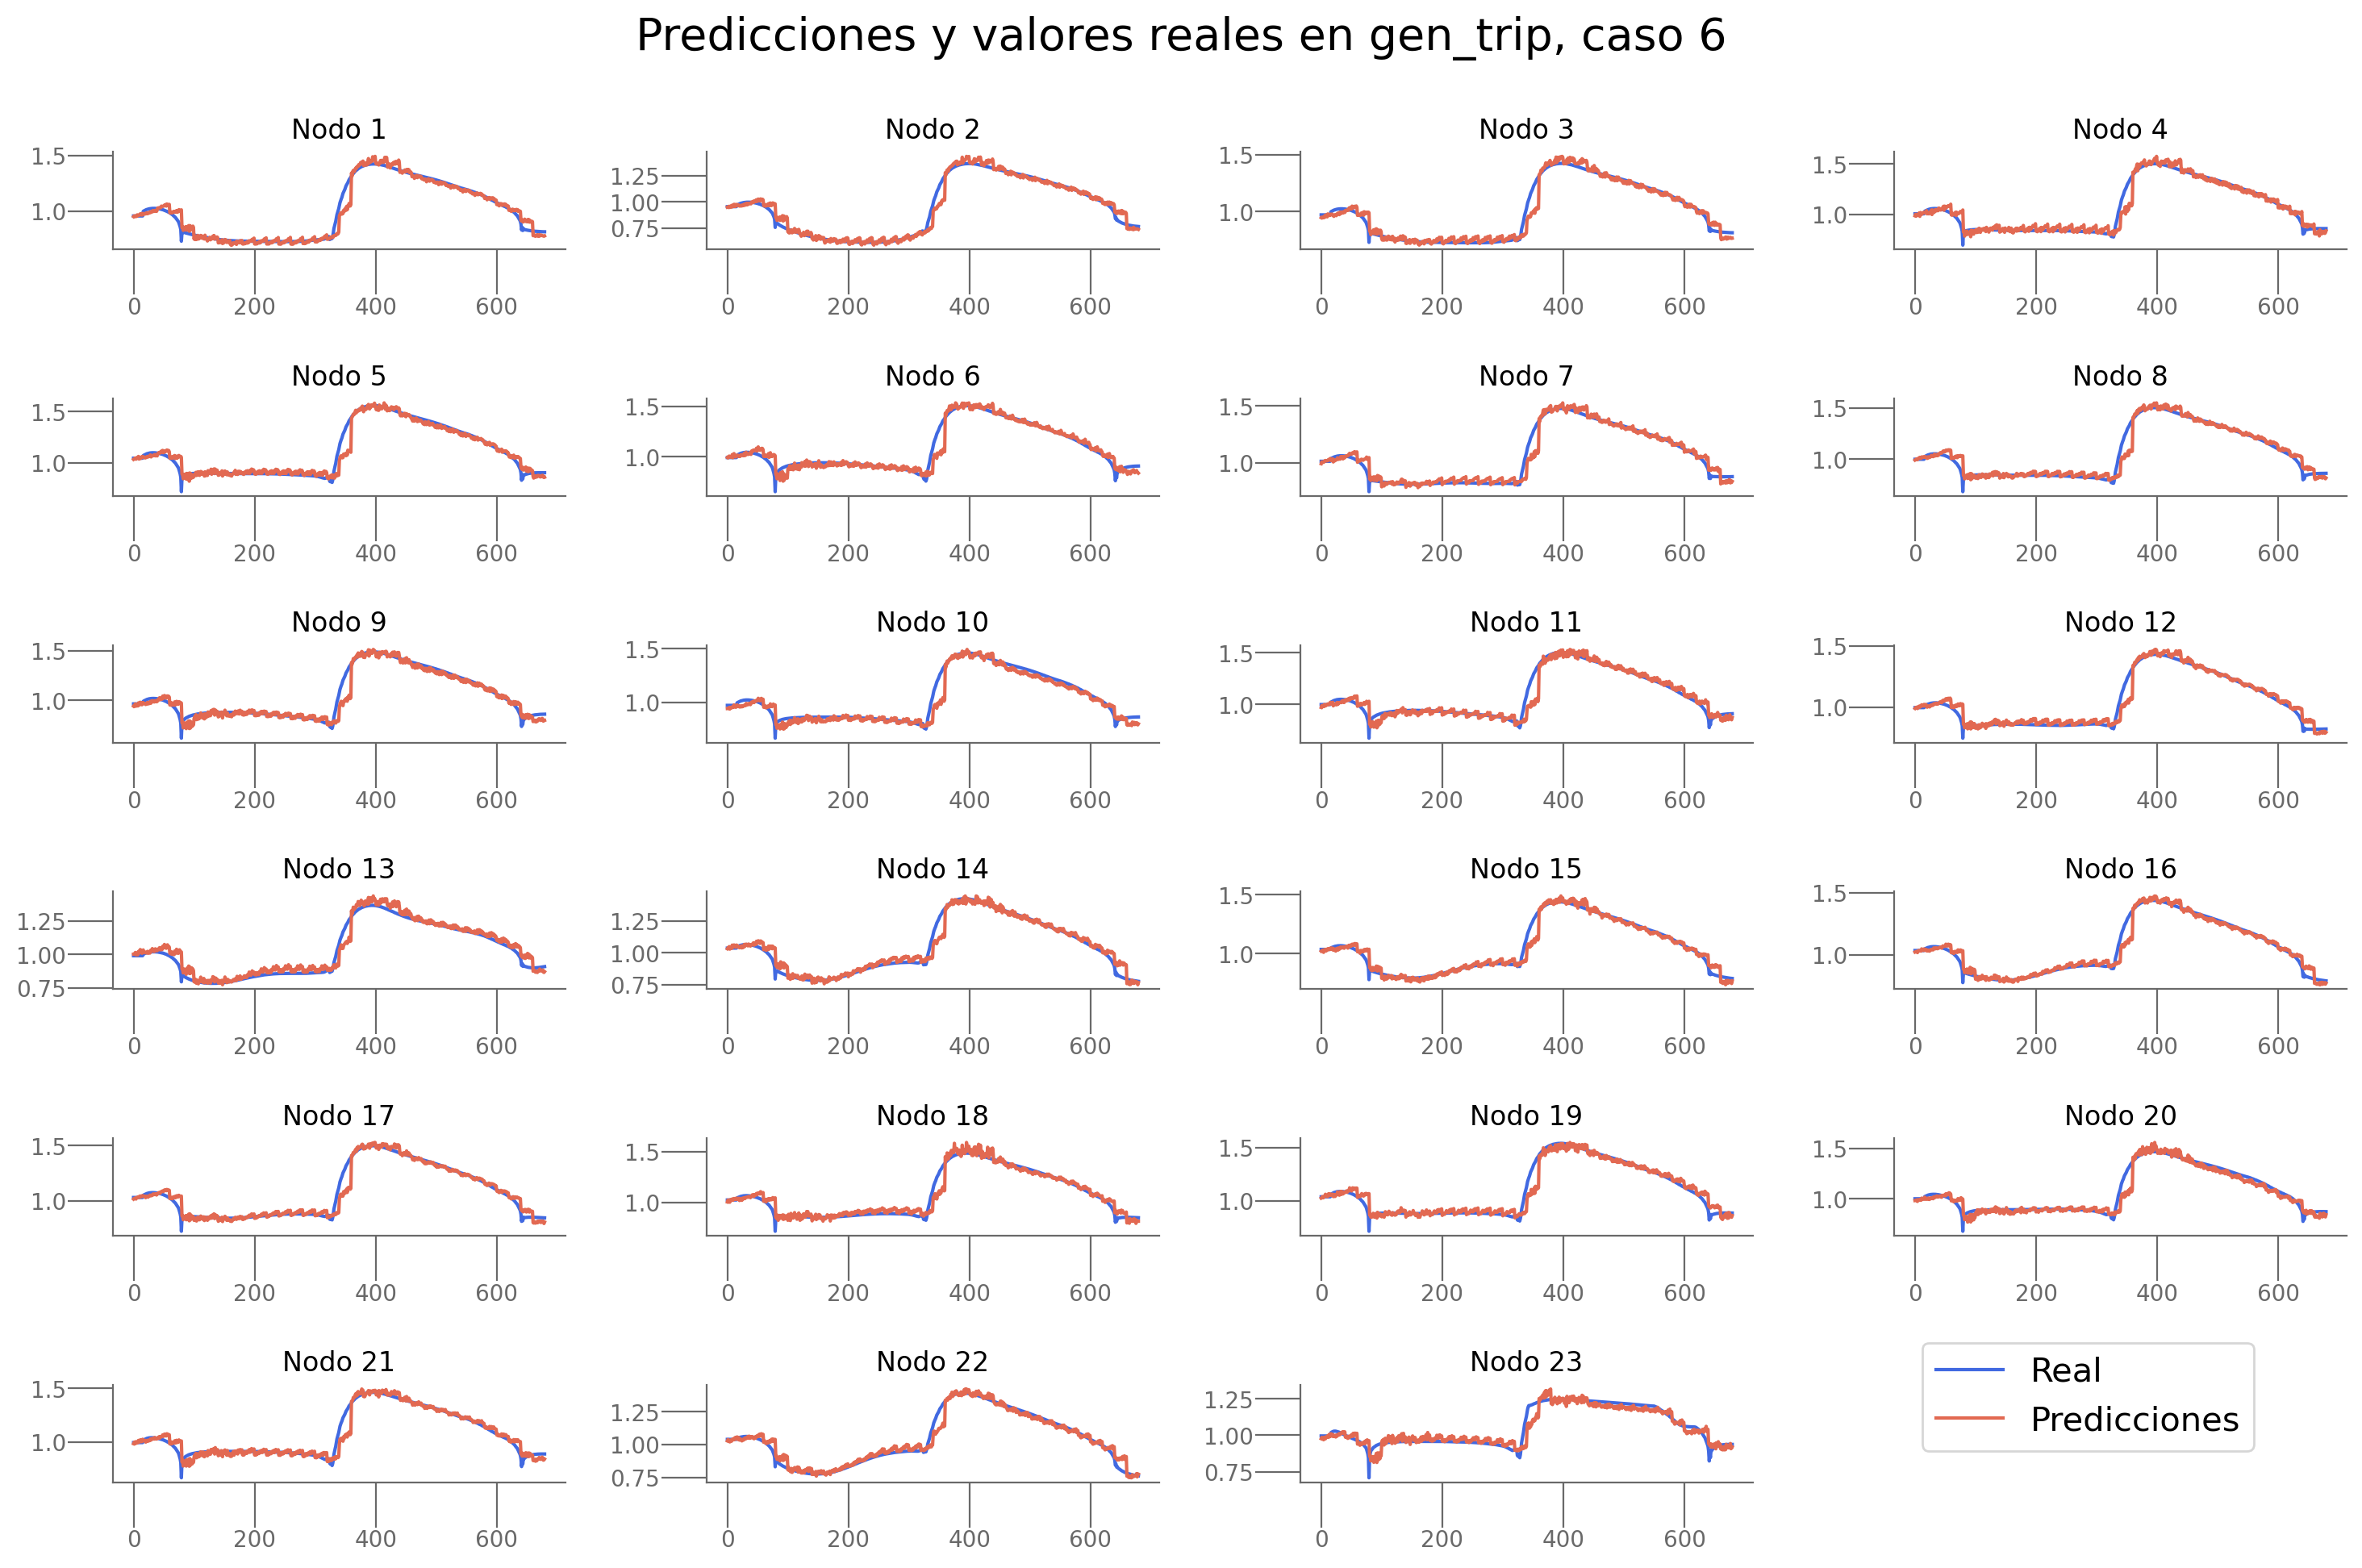

In [12]:
plot_predictions(predictions, real, n_target, 6, n_div_gt, problem_gt)

In [13]:
path_save_experiment_gt = results_save_path+f"/{problem_gt}"+ f"/ajustes/{name_model}_results.csv"
resultados_gt.to_csv(path_save_experiment_gt, index=False)

In [14]:
trainer_gt.save_model(params=params_gt, path_save_experiment= path_save_experiment_gt)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                             Params  \
0          LSTM                                                NaN   
1     MPNN_LSTM                {'hidden_size': 16, 'dropout': 0.2}   
2  LSTM_NOBATCH                                                NaN   
3   DyGrEncoder              {'aggr': 'add', 'conv': 1, 'lstm': 1}   
4     EvolveGCN                                                NaN   
5         AGCRN            {'hidden': 10, 'K': 10, 'embedding': 3}   
6        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   
7         DCRNN                                     {'hidden': 10}   
8        ASTGCN  {'nb_block': 1, 'K': 2, 'nb_chev_filter': 3, '...   
9        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   

                      Fichero_resultados_experimento  Loss_tst     R2_tst  \
0                                                NaN  0.007638   0.204209   
1    ./resu

### Bus trip

In [18]:
problem_bt = "bus_trip"
dataset_bt, situations_bt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_bt)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  86


In [19]:
n_div_bt = loader.div
n_nodes =dataset_bt.features[0].shape[0]
n_target = dataset_bt.targets[0].shape[1]
n_features = dataset_bt[0].x.shape[1]


num_early_stop = 0
num_epochs = 30
lr = 0.01

#### Sencilla 

In [12]:

device =  torch.device("cpu")
model_bt = MSTGCNModel(name="MSTGCN", node_features=n_features, node_count=n_nodes, n_target=n_target, nb_block=2, k=2, nb_chev_filter = 8, nb_time_filter =8, time_strides = 100)

trainer_bt = TrainerMSTGCN(model_bt, dataset_bt,device, f"./results/{problem_bt}", dataloader_params2)
losses,eval_losses, r2scores  = trainer_bt.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)





==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430
AQuissss

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.3984 | Eval Loss: 0.2718 | Eval R2: -7.1887 | LR: 0.0010 | 
Epoch 2/30 | Train Loss: 0.2490 | Eval Loss: 0.2194 | Eval R2: -5.5917 | LR: 0.0010 | 
Epoch 3/30 | Train Loss: 0.2230 | Eval Loss: 0.2144 | Eval R2: -5.4394 | LR: 0.0010 | 
Epoch 4/30 | Train Loss: 0.2219 | Eval Loss: 0.1994 | Eval R2: -4.8970 | LR: 0.0010 | 
Epoch 5/30 | Train Loss: 0.2001 | Eval Loss: 0.1897 | Eval R2: -4.5734 | LR: 0.0010 | 
Epoch 6/30 | Train Loss: 0.1978 | Eval Loss: 0.1898 | Eval R2: -4.5750 | LR: 0.0010 | 
Epoch 7/30 | Train Loss: 0.1689 | Eval Loss: 0.1452 | Eval R2: -2.9278 | LR: 0.0010 | 
Epoch 8/30 | Train Loss: 0.1502 | Eval Loss: 0.1417 | Eval R2: -2.8185 | LR: 0.0010 | 
Epoch 9/30 | Train Loss: 0.1327 | Eval Loss: 0.1190 | Eval R2: -2.2451 | LR: 0.0010 | 
Epoch 10/30 | Train Loss: 0.1099 | E

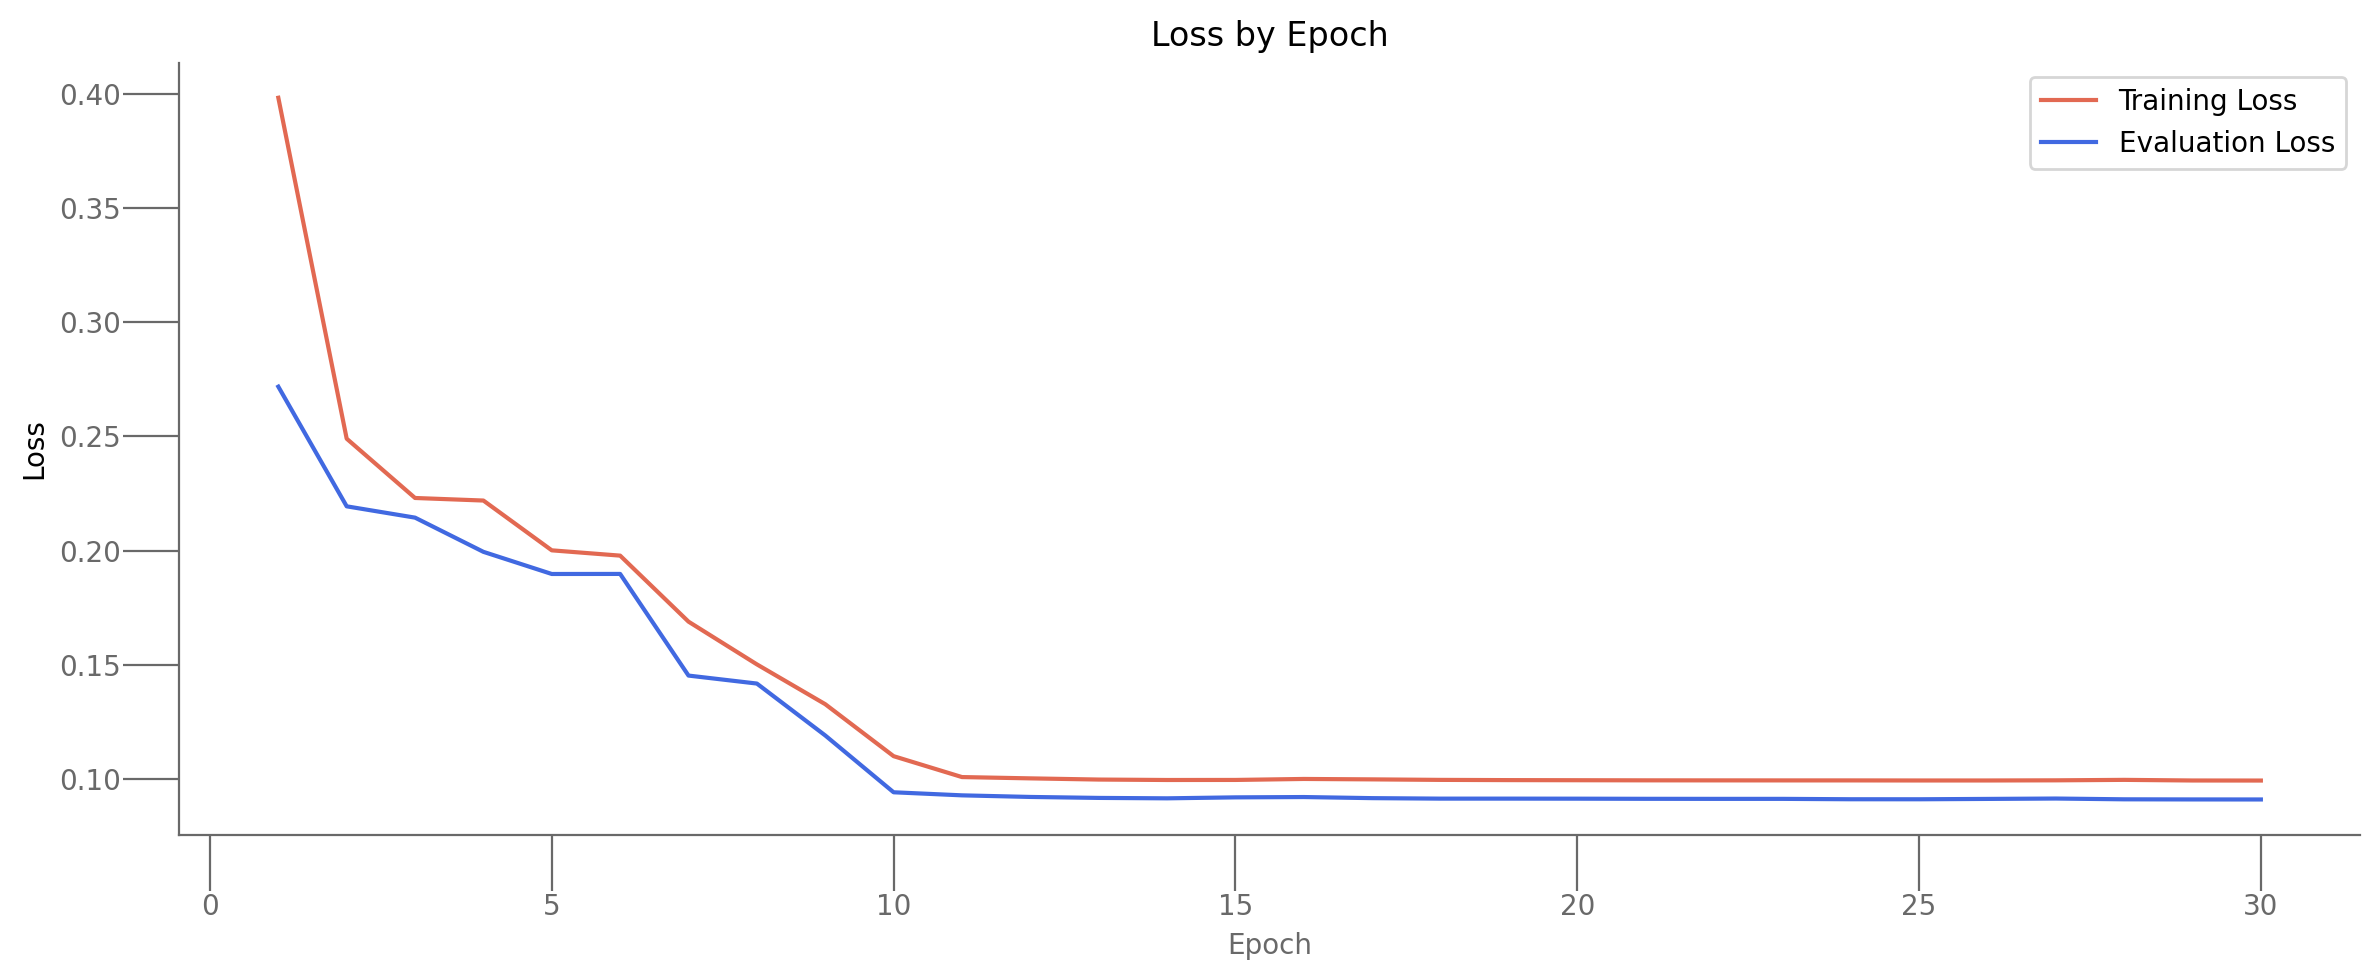


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.097667, test r2score -1.288585


In [13]:
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_bt, real_bt = trainer_bt.test()

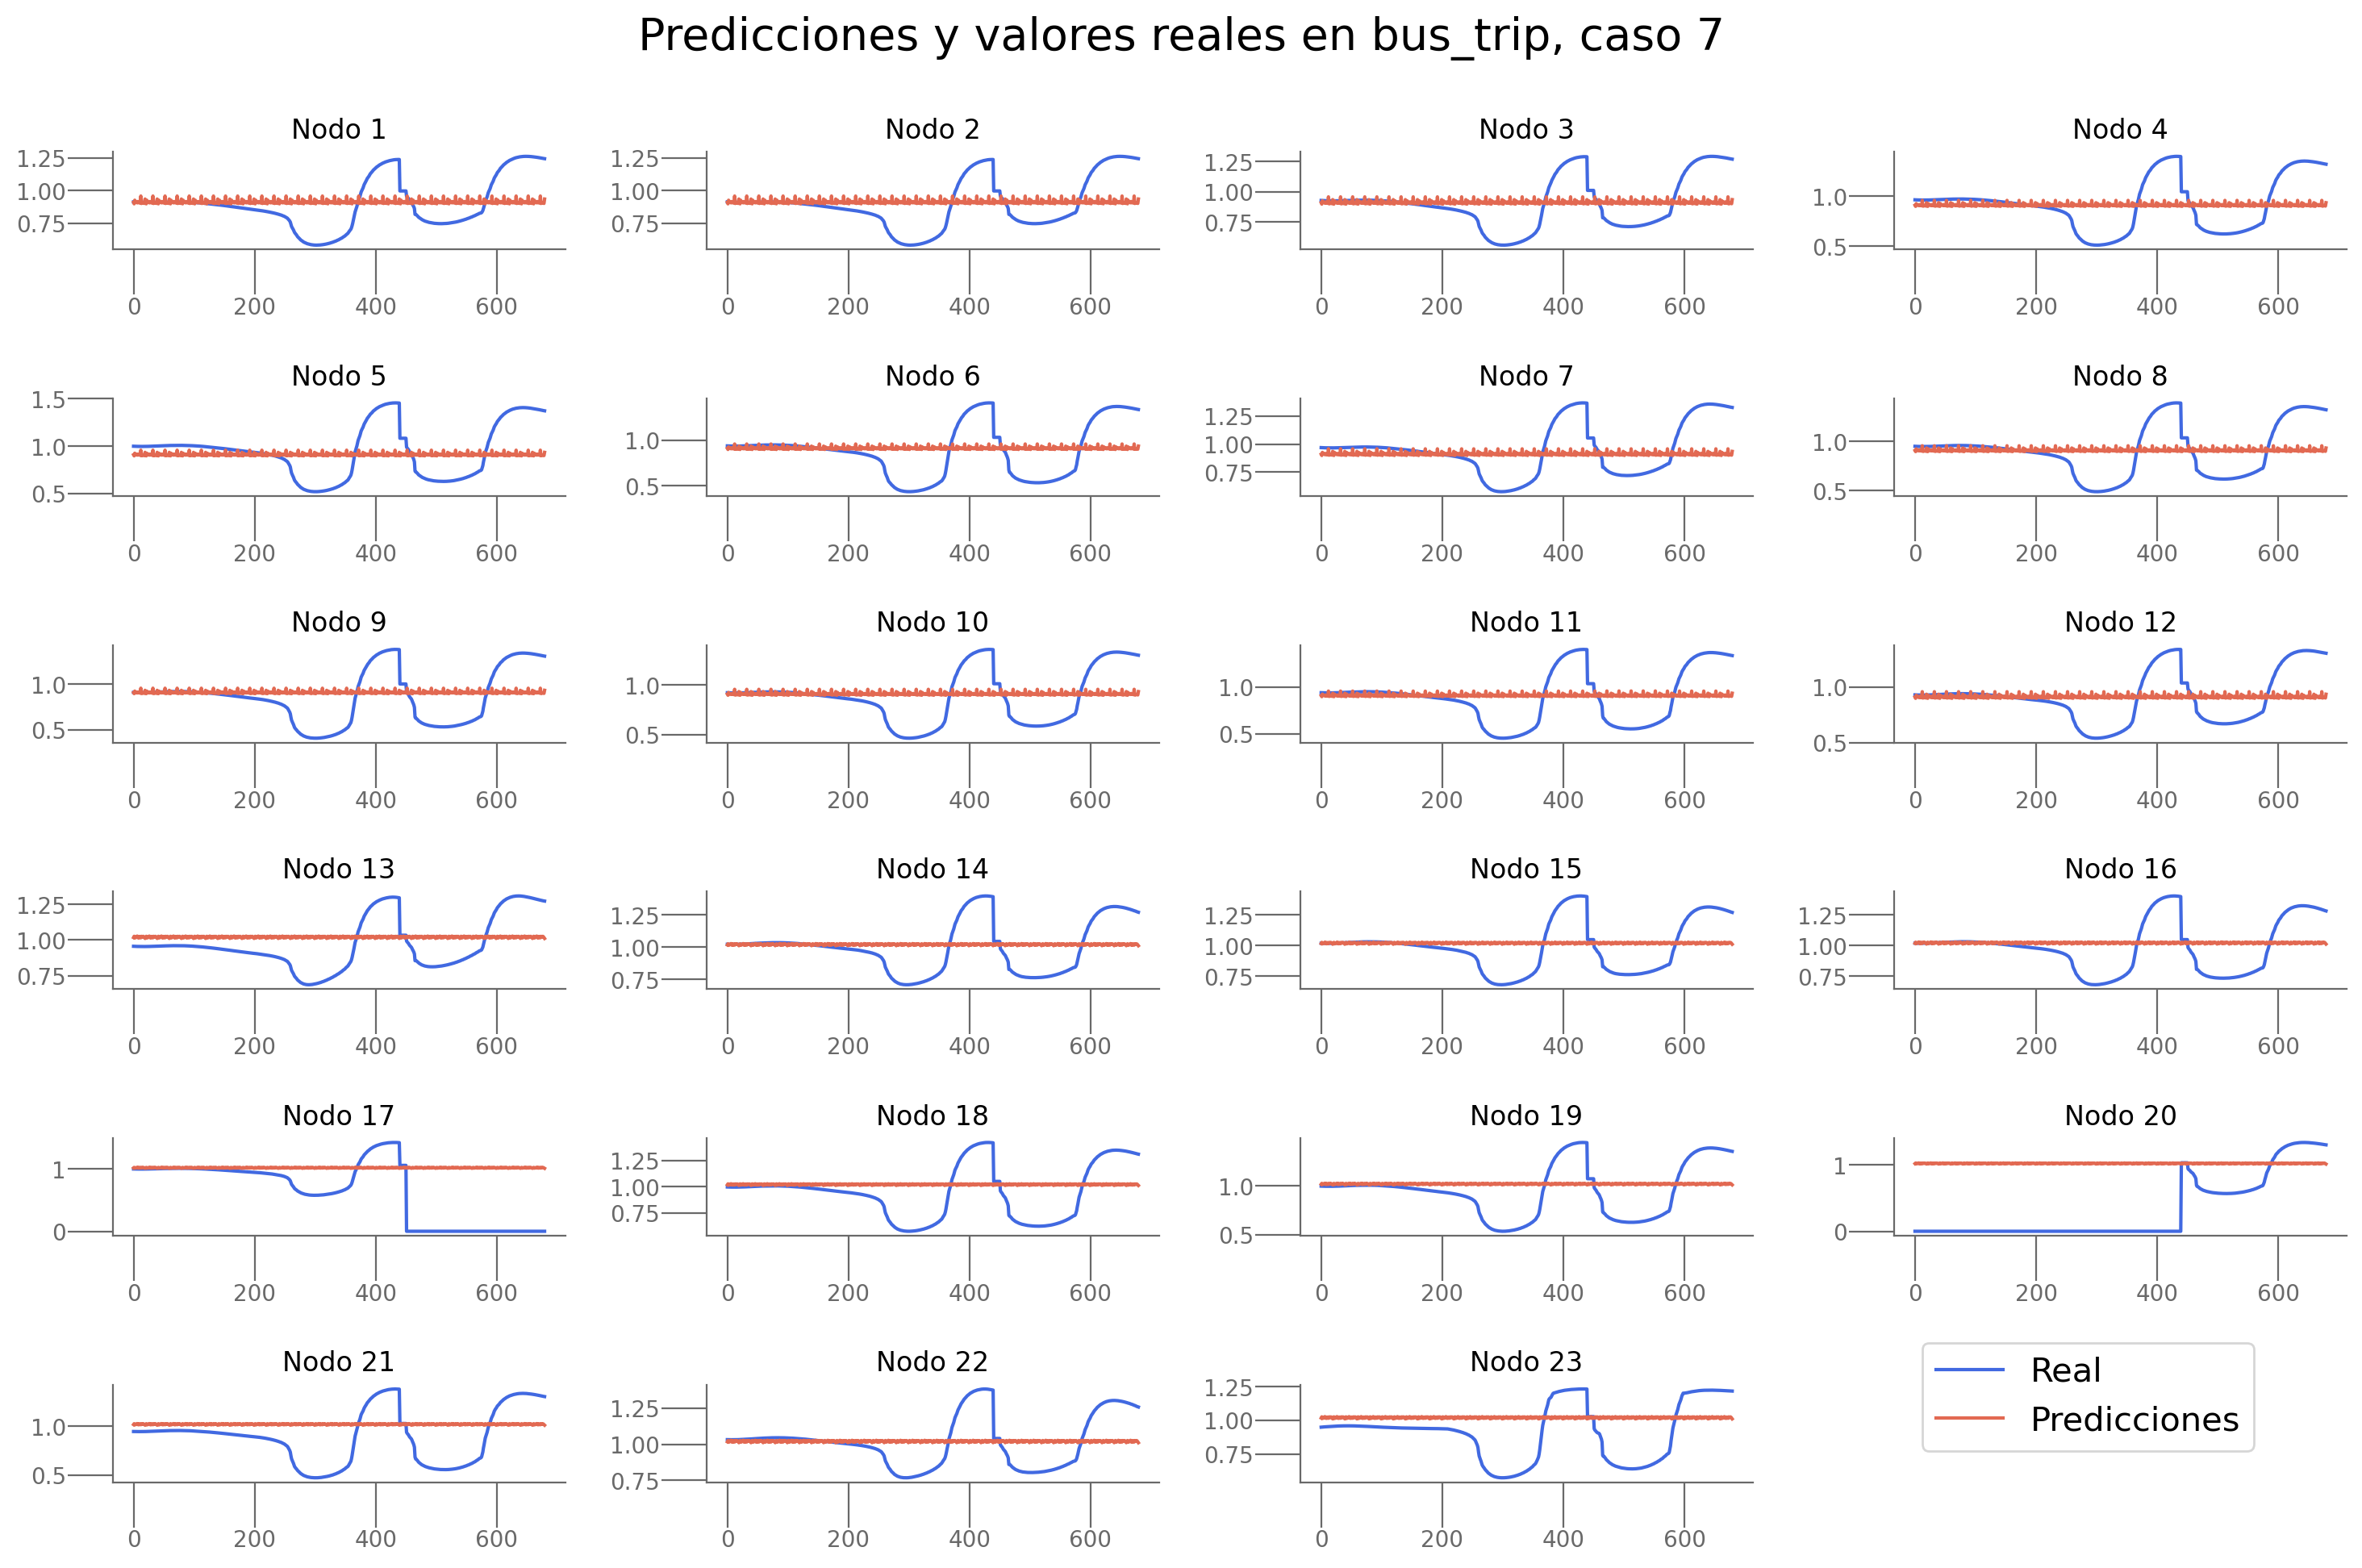

In [14]:
plot_predictions(predictions_bt, real_bt, n_target, 7, n_div_bt, problem_bt)

In [ ]:
trainer_bt.save_model(path_save_experiment="./results/bus_trip/ajustes/MSTGCN_results.csv", params={'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'time_strides': 2, 'hidden': 100})

#### Ajuste de parámetros 

In [20]:


num_epochs = 100
num_early_stop = 10

trainer_bt,params_bt,resultados_final_bt, resultados_bt = entrenar_y_evaluar_modelos_mstgcn(param_grid, dataset_bt, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_bt)

  0%|          | 0/54 [00:00<?, ?it/s]

Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=50

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 0.5330 | Eval Loss: 0.3254 | Eval R2: -9.7461 | LR: 0.0010 | 
Epoch 2/100 | Train Loss: 0.2637 | Eval Loss: 0.1800 | Eval R2: -4.4331 | LR: 0.0010 | 
Epoch 3/100 | Train Loss: 0.1662 | Eval Loss: 0.1365 | Eval R2: -2.7700 | LR: 0.0010 | 
Epoch 4/100 | Train Loss: 0.1407 | Eval Loss: 0.1196 | Eval R2: -2.0710 | LR: 0.0010 | 
Epoch 5/100 | Train Loss: 0.1264 | Eval Loss: 0.1088 | Eval R2: -1.6851 | LR: 0.0010 | 
Epoch 6/100 | Train Loss: 0.1179 | Eval Loss: 0.1034 | Eval R2: -1.4995 | LR: 0.0010 | 
Epoch 7/100 | Train Loss: 0.1131 | Eval Loss: 0.1000 | Eval R2: -1.3686 | LR: 0.0010 | 
Epoch 8/100 | Train Loss: 0.1104 | Eval Loss: 0.0974 | Eval R2: -1.2636 | LR: 0.0010 | 
Epoch 9/100 | Train Loss: 0.

  2%|▏         | 1/54 [03:51<3:24:24, 231.40s/it]

preds:  (1, 23, 20)
test loss: 0.094359, test R2 score: -1.227044
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.10232441872358322, 'r2_eval_final': -1.0284315347671509, 'loss_eval_final': 0.09119716286659241, 'r2_test': -1.2270437492216735, 'loss_test': 0.09435882419347763, 'loss_nodes': [0.17596149444580078, 0.05955607816576958, 0.05548868700861931, 0.12907527387142181, 0.07028529047966003, 0.06984223425388336, 0.05554294213652611, 0.13191057741641998, 0.07462481409311295, 0.12665902078151703, 0.07096657156944275, 0.05473875254392624, 0.042446814477443695, 0.11164911091327667, 0.1104365736246109, 0.046673040837049484, 0.18327048420906067, 0.05890820920467377, 0.1420556604862213, 0.19081123173236847, 0.06484074890613556, 0.0416603647172451, 0.10284855961799622]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=80

==================== DATASET INFO ==========

  4%|▎         | 2/54 [07:51<3:25:04, 236.62s/it]

preds:  (1, 23, 20)
test loss: 0.094359, test R2 score: -1.227035
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.10232458263635635, 'r2_eval_final': -1.0284379720687866, 'loss_eval_final': 0.09119737893342972, 'r2_test': -1.2270346886493053, 'loss_test': 0.09435858577489853, 'loss_nodes': [0.1759617179632187, 0.05955611541867256, 0.05548878014087677, 0.12907516956329346, 0.07028529793024063, 0.06984223425388336, 0.05554291978478432, 0.1319093555212021, 0.07462480664253235, 0.12665894627571106, 0.07096659392118454, 0.05473444610834122, 0.04244678467512131, 0.11164910346269608, 0.11043673753738403, 0.046673428267240524, 0.18327057361602783, 0.058908212929964066, 0.14205574989318848, 0.1908113807439804, 0.06484081596136093, 0.04166046902537346, 0.10284743458032608]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=100

==================== DATASET INFO =========

  6%|▌         | 3/54 [11:51<3:22:16, 237.97s/it]

preds:  (1, 23, 20)
test loss: 0.094358, test R2 score: -1.227030
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.10232464969158173, 'r2_eval_final': -1.0284368991851807, 'loss_eval_final': 0.09119733422994614, 'r2_test': -1.2270297309783174, 'loss_test': 0.09435848146677017, 'loss_nodes': [0.17596173286437988, 0.05955610051751137, 0.05548883602023125, 0.12907525897026062, 0.07028529047966003, 0.06984222680330276, 0.05554294213652611, 0.13190919160842896, 0.0746244490146637, 0.12665902078151703, 0.07096654921770096, 0.054732196033000946, 0.04244675487279892, 0.11164910346269608, 0.11043693870306015, 0.04667365550994873, 0.18327058851718903, 0.058908216655254364, 0.1420556902885437, 0.19081148505210876, 0.06484080106019974, 0.041660428047180176, 0.10284679383039474]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=50

==================== DATASET INFO =======

  7%|▋         | 4/54 [15:41<3:15:38, 234.76s/it]

preds:  (1, 23, 20)
test loss: 0.322419, test R2 score: -8.222432
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.34632328152656555, 'r2_eval_final': -9.122377395629883, 'loss_eval_final': 0.31822723150253296, 'r2_test': -8.22243220902511, 'loss_test': 0.3224187195301056, 'loss_nodes': [0.33431944251060486, 0.28334301710128784, 0.2878153324127197, 0.34487611055374146, 0.33710789680480957, 0.31030985713005066, 0.3128954768180847, 0.33922263979911804, 0.29619279503822327, 0.3241678774356842, 0.311148077249527, 0.29259753227233887, 0.2961573302745819, 0.3379041254520416, 0.3433593511581421, 0.31255388259887695, 0.37665969133377075, 0.3152572512626648, 0.36713773012161255, 0.3706154525279999, 0.303413450717926, 0.3109743297100067, 0.30760321021080017]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=80

==================== DATASET INFO ===================

Train

  9%|▉         | 5/54 [19:29<3:09:59, 232.63s/it]

preds:  (1, 23, 20)
test loss: 0.322419, test R2 score: -8.222432
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.34632328152656555, 'r2_eval_final': -9.122377395629883, 'loss_eval_final': 0.31822723150253296, 'r2_test': -8.22243219473161, 'loss_test': 0.3224187195301056, 'loss_nodes': [0.33431944251060486, 0.28334301710128784, 0.2878153324127197, 0.34487611055374146, 0.33710789680480957, 0.31030985713005066, 0.3128954768180847, 0.33922263979911804, 0.2961927652359009, 0.3241678774356842, 0.311148077249527, 0.29259756207466125, 0.2961573302745819, 0.3379041254520416, 0.3433593511581421, 0.31255388259887695, 0.37665969133377075, 0.3152572512626648, 0.36713773012161255, 0.3706154525279999, 0.303413450717926, 0.3109743595123291, 0.30760321021080017]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=100

==================== DATASET INFO ===================

Train

 11%|█         | 6/54 [23:19<3:05:14, 231.54s/it]

preds:  (1, 23, 20)
test loss: 0.322419, test R2 score: -8.222432
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.34632328152656555, 'r2_eval_final': -9.122377395629883, 'loss_eval_final': 0.31822723150253296, 'r2_test': -8.222432191376923, 'loss_test': 0.3224187195301056, 'loss_nodes': [0.33431944251060486, 0.28334301710128784, 0.2878153324127197, 0.34487611055374146, 0.3371078670024872, 0.31030985713005066, 0.3128954768180847, 0.33922263979911804, 0.29619279503822327, 0.3241678774356842, 0.311148077249527, 0.29259756207466125, 0.2961573302745819, 0.3379041254520416, 0.3433593511581421, 0.31255388259887695, 0.37665969133377075, 0.3152572512626648, 0.36713773012161255, 0.3706154525279999, 0.303413450717926, 0.3109743595123291, 0.30760321021080017]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=50

==================== DATASET INFO ===================

Tra

 13%|█▎        | 7/54 [27:06<3:00:18, 230.19s/it]

preds:  (1, 23, 20)
test loss: 0.058951, test R2 score: -0.418878
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.06261330097913742, 'r2_eval_final': -0.2571122944355011, 'loss_eval_final': 0.05418912693858147, 'r2_test': -0.41887768221206567, 'loss_test': 0.05895117670297623, 'loss_nodes': [0.04046148806810379, 0.05998563393950462, 0.0634840652346611, 0.0789208859205246, 0.07132463157176971, 0.08988162130117416, 0.06216026842594147, 0.07354184985160828, 0.07262803614139557, 0.06391105055809021, 0.06670937687158585, 0.049950920045375824, 0.034255340695381165, 0.0380062609910965, 0.04925035685300827, 0.046108730137348175, 0.06325661391019821, 0.05710087716579437, 0.07058431208133698, 0.07101625204086304, 0.05999035760760307, 0.03009895235300064, 0.04324929043650627]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=80

==================== DATASET INFO ======

 15%|█▍        | 8/54 [30:52<2:55:22, 228.76s/it]

preds:  (1, 23, 20)
test loss: 0.063879, test R2 score: -0.597982
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.07399947196245193, 'r2_eval_final': -0.4395935535430908, 'loss_eval_final': 0.05928398296236992, 'r2_test': -0.597982361610627, 'loss_test': 0.06387866288423538, 'loss_nodes': [0.05093122273683548, 0.06328965723514557, 0.06622089445590973, 0.0849325880408287, 0.07287666201591492, 0.09098255634307861, 0.06425723433494568, 0.08103334158658981, 0.07680262625217438, 0.07130482792854309, 0.0698644146323204, 0.054038647562265396, 0.036728471517562866, 0.04397382214665413, 0.05544785410165787, 0.04846334084868431, 0.07395225763320923, 0.05974826589226723, 0.07706291973590851, 0.08175443112850189, 0.06330153346061707, 0.03211956471204758, 0.05012210085988045]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=100

==================== DATASET INFO =======

 17%|█▋        | 9/54 [34:30<2:48:59, 225.31s/it]

preds:  (1, 23, 20)
test loss: 0.129024, test R2 score: -2.509289
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.14768829941749573, 'r2_eval_final': -2.428004503250122, 'loss_eval_final': 0.1239464282989502, 'r2_test': -2.5092885783925203, 'loss_test': 0.1290244311094284, 'loss_nodes': [0.10612914711236954, 0.10503184050321579, 0.10210111737251282, 0.1458401381969452, 0.1253146380186081, 0.11674609035253525, 0.10965296626091003, 0.1753537803888321, 0.11687856912612915, 0.14798994362354279, 0.11599112302064896, 0.09873401373624802, 0.08815471082925797, 0.10493132472038269, 0.1395389288663864, 0.10141479969024658, 0.22329065203666687, 0.11100541055202484, 0.1865331530570984, 0.20400841534137726, 0.10985303670167923, 0.09013284742832184, 0.14293551445007324]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=50

==================== DATASET INFO ===============

 19%|█▊        | 10/54 [38:29<2:48:22, 229.61s/it]

preds:  (1, 23, 20)
test loss: 0.211730, test R2 score: -4.483487
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.22413133084774017, 'r2_eval_final': -5.5855631828308105, 'loss_eval_final': 0.2095140814781189, 'r2_test': -4.4834872557042695, 'loss_test': 0.2117295116186142, 'loss_nodes': [0.17378036677837372, 0.19932442903518677, 0.20623216032981873, 0.20702321827411652, 0.24026106297969818, 0.22105731070041656, 0.22498029470443726, 0.20424805581569672, 0.20847415924072266, 0.19252246618270874, 0.22281241416931152, 0.21257711946964264, 0.21972021460533142, 0.21244382858276367, 0.2121783196926117, 0.22831588983535767, 0.20001670718193054, 0.22777321934700012, 0.22220352292060852, 0.1899431347846985, 0.21911443769931793, 0.23234690725803375, 0.1924295574426651]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=80

==================== DATASET INFO ==============

 20%|██        | 11/54 [42:32<2:47:28, 233.68s/it]

preds:  (1, 23, 20)
test loss: 0.211729, test R2 score: -4.483487
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.22413133084774017, 'r2_eval_final': -5.585563659667969, 'loss_eval_final': 0.20951403677463531, 'r2_test': -4.483486872825893, 'loss_test': 0.21172946691513062, 'loss_nodes': [0.1737803965806961, 0.19932439923286438, 0.20623205602169037, 0.20702309906482697, 0.24026112258434296, 0.2210574597120285, 0.22498030960559845, 0.20424805581569672, 0.2084740549325943, 0.19252245128154755, 0.22281214594841003, 0.2125771939754486, 0.21972022950649261, 0.21244388818740845, 0.2121783196926117, 0.22831588983535767, 0.2000167965888977, 0.22777321934700012, 0.22220328450202942, 0.1899431049823761, 0.21911412477493286, 0.23234686255455017, 0.1924295723438263]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=100

==================== DATASET INFO ==================

 22%|██▏       | 12/54 [46:35<2:45:40, 236.67s/it]

preds:  (1, 23, 20)
test loss: 0.211729, test R2 score: -4.483486
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.22413130104541779, 'r2_eval_final': -5.585561275482178, 'loss_eval_final': 0.20951399207115173, 'r2_test': -4.483485662979439, 'loss_test': 0.21172945201396942, 'loss_nodes': [0.17378036677837372, 0.19932439923286438, 0.20623202621936798, 0.20702317357063293, 0.24026109278202057, 0.22105753421783447, 0.22498029470443726, 0.2042478322982788, 0.20847389101982117, 0.19252240657806396, 0.222812220454216, 0.21257701516151428, 0.21972021460533142, 0.21244369447231293, 0.2121782749891281, 0.22831584513187408, 0.20001664757728577, 0.22777335345745087, 0.22220338881015778, 0.18994303047657013, 0.21911433339118958, 0.23234687745571136, 0.19242946803569794]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=50

==================== DATASET INFO ==============

 24%|██▍       | 13/54 [50:22<2:39:32, 233.48s/it]

preds:  (1, 23, 20)
test loss: 0.417023, test R2 score: -12.561977
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.4437516927719116, 'r2_eval_final': -13.568845748901367, 'loss_eval_final': 0.41207072138786316, 'r2_test': -12.56197671416995, 'loss_test': 0.41702333092689514, 'loss_nodes': [0.3445010781288147, 0.3947620987892151, 0.40743204951286316, 0.40743598341941833, 0.47021469473838806, 0.43272098898887634, 0.4447729289531708, 0.4016496539115906, 0.4079606831073761, 0.37892693281173706, 0.43583860993385315, 0.4200371205806732, 0.4365103542804718, 0.4186943769454956, 0.42017847299575806, 0.4518584609031677, 0.39315342903137207, 0.44725391268730164, 0.4362923204898834, 0.37261199951171875, 0.4288000464439392, 0.46180129051208496, 0.37812814116477966]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=80

==================== DATASET INFO ===================



 26%|██▌       | 14/54 [54:09<2:34:31, 231.80s/it]

preds:  (1, 23, 20)
test loss: 0.417023, test R2 score: -12.561969
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.44375112652778625, 'r2_eval_final': -13.568839073181152, 'loss_eval_final': 0.4120703339576721, 'r2_test': -12.561968540553844, 'loss_test': 0.4170229136943817, 'loss_nodes': [0.34450098872184753, 0.39476191997528076, 0.4074317216873169, 0.4074353873729706, 0.4702141582965851, 0.43272024393081665, 0.44477221369743347, 0.40164920687675476, 0.40796026587486267, 0.37892648577690125, 0.4358379542827606, 0.4200369119644165, 0.43651026487350464, 0.418693482875824, 0.42017820477485657, 0.45185813307762146, 0.39315274357795715, 0.44725358486175537, 0.43629133701324463, 0.3726115822792053, 0.4287993609905243, 0.461801141500473, 0.3781280517578125]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=100

==================== DATASET INFO ===================



 28%|██▊       | 15/54 [57:55<2:29:27, 229.92s/it]

preds:  (1, 23, 20)
test loss: 0.417023, test R2 score: -12.561968
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.44375115633010864, 'r2_eval_final': -13.568838119506836, 'loss_eval_final': 0.4120703637599945, 'r2_test': -12.561967816641133, 'loss_test': 0.4170229136943817, 'loss_nodes': [0.3445010185241699, 0.39476194977760315, 0.40743163228034973, 0.40743544697761536, 0.4702140986919403, 0.43272048234939575, 0.444772332906723, 0.4016490876674652, 0.40796026587486267, 0.37892648577690125, 0.43583789467811584, 0.42003682255744934, 0.43651026487350464, 0.41869354248046875, 0.42017820477485657, 0.45185813307762146, 0.39315277338027954, 0.447253555059433, 0.436291366815567, 0.37261155247688293, 0.4287993609905243, 0.4618011713027954, 0.3781280517578125]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=50

==================== DATASET INFO ===================


 30%|██▉       | 16/54 [1:01:37<2:24:11, 227.66s/it]

preds:  (1, 23, 20)
test loss: 0.064313, test R2 score: -0.394888
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.06496761739253998, 'r2_eval_final': -0.6342388987541199, 'loss_eval_final': 0.06333077698945999, 'r2_test': -0.39488758184649964, 'loss_test': 0.06431253999471664, 'loss_nodes': [0.04984091594815254, 0.05656999349594116, 0.059920262545347214, 0.06459496170282364, 0.07458589971065521, 0.07156657427549362, 0.06580545008182526, 0.06731558591127396, 0.06872832775115967, 0.06104518100619316, 0.07082300633192062, 0.06273701786994934, 0.05996764078736305, 0.060151319950819016, 0.061572346836328506, 0.06540152430534363, 0.06509846448898315, 0.06894936412572861, 0.06973456591367722, 0.06329789012670517, 0.0685930997133255, 0.06309271603822708, 0.05979640409350395]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=80

==================== DATASET INFO ====

 31%|███▏      | 17/54 [1:05:38<2:22:49, 231.60s/it]

preds:  (1, 23, 20)
test loss: 0.064312, test R2 score: -0.394883
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.06496763229370117, 'r2_eval_final': -0.6342337727546692, 'loss_eval_final': 0.063330739736557, 'r2_test': -0.39488307122225136, 'loss_test': 0.06431249529123306, 'loss_nodes': [0.049840837717056274, 0.056569915264844894, 0.059920210391283035, 0.0645950511097908, 0.07458598911762238, 0.07156667858362198, 0.06580552458763123, 0.06731550395488739, 0.06872819364070892, 0.061045095324516296, 0.07082284986972809, 0.06273689866065979, 0.059967558830976486, 0.06015125662088394, 0.0615723542869091, 0.06540147215127945, 0.0650983676314354, 0.0689493864774704, 0.06973446160554886, 0.0632978230714798, 0.06859288364648819, 0.0630926638841629, 0.059796225279569626]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=100

==================== DATASET INFO =======

 33%|███▎      | 18/54 [1:09:31<2:19:15, 232.09s/it]

preds:  (1, 23, 20)
test loss: 0.064312, test R2 score: -0.394880
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.06496763229370117, 'r2_eval_final': -0.6342304348945618, 'loss_eval_final': 0.06333068013191223, 'r2_test': -0.39488018519540324, 'loss_test': 0.06431245803833008, 'loss_nodes': [0.049840766936540604, 0.05656993389129639, 0.05992019549012184, 0.06459499895572662, 0.0745859295129776, 0.07156672328710556, 0.06580542773008347, 0.0673154667019844, 0.06872820854187012, 0.061045076698064804, 0.0708228126168251, 0.06273689866065979, 0.0599675253033638, 0.06015133485198021, 0.06157228723168373, 0.06540147215127945, 0.06509831547737122, 0.0689493864774704, 0.06973441690206528, 0.06329774111509323, 0.0685928463935852, 0.0630926564335823, 0.05979618802666664]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=50

==================== DATASET INFO ===========

 35%|███▌      | 19/54 [1:14:26<2:26:17, 250.78s/it]

preds:  (1, 23, 20)
test loss: 0.208712, test R2 score: -4.693988
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.22106896340847015, 'r2_eval_final': -6.266170024871826, 'loss_eval_final': 0.20735710859298706, 'r2_test': -4.693987828230568, 'loss_test': 0.2087118923664093, 'loss_nodes': [0.17091535031795502, 0.19631274044513702, 0.20291738212108612, 0.20321230590343475, 0.23507137596607208, 0.21697910130023956, 0.2219153493642807, 0.20119231939315796, 0.20550400018692017, 0.1896122694015503, 0.21963578462600708, 0.21021872758865356, 0.2181483954191208, 0.20977146923542023, 0.2094527930021286, 0.22574420273303986, 0.1977788209915161, 0.2237127125263214, 0.21892091631889343, 0.1864461898803711, 0.21611946821212769, 0.2304680198431015, 0.19032439589500427]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=80

==================== DATASET INFO ===================


 37%|███▋      | 20/54 [1:20:28<2:41:01, 284.15s/it]

preds:  (1, 23, 20)
test loss: 0.208712, test R2 score: -4.693987
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.22106890380382538, 'r2_eval_final': -6.266169548034668, 'loss_eval_final': 0.20735709369182587, 'r2_test': -4.693987349872714, 'loss_test': 0.20871186256408691, 'loss_nodes': [0.17091533541679382, 0.19631272554397583, 0.20291735231876373, 0.20321229100227356, 0.23507139086723328, 0.2169790416955948, 0.22191528975963593, 0.201192244887352, 0.20550397038459778, 0.1896122843027115, 0.2196357101202011, 0.21021877229213715, 0.2181483507156372, 0.20977133512496948, 0.20945274829864502, 0.22574415802955627, 0.19777879118919373, 0.22371268272399902, 0.21892085671424866, 0.1864461451768875, 0.21611928939819336, 0.2304680049419403, 0.19032438099384308]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=100

==================== DATASET INFO ==================

 39%|███▉      | 21/54 [1:26:24<2:48:12, 305.83s/it]

preds:  (1, 23, 20)
test loss: 0.208712, test R2 score: -4.693988
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.22106894850730896, 'r2_eval_final': -6.266169548034668, 'loss_eval_final': 0.20735709369182587, 'r2_test': -4.693987763274164, 'loss_test': 0.20871186256408691, 'loss_nodes': [0.17091533541679382, 0.19631274044513702, 0.20291738212108612, 0.20321232080459595, 0.23507139086723328, 0.21697910130023956, 0.2219153642654419, 0.20119227468967438, 0.20550400018692017, 0.18961229920387268, 0.21963565051555634, 0.21021869778633118, 0.2181483805179596, 0.209771528840065, 0.20945283770561218, 0.22574427723884583, 0.19777873158454895, 0.22371268272399902, 0.21892088651657104, 0.1864462047815323, 0.21611939370632172, 0.2304680049419403, 0.19032439589500427]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=50

==================== DATASET INFO ================

 41%|████      | 22/54 [1:32:04<2:48:37, 316.17s/it]

preds:  (1, 23, 20)
test loss: 0.111236, test R2 score: -2.004093
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.11591654270887375, 'r2_eval_final': -2.7961676120758057, 'loss_eval_final': 0.11009512841701508, 'r2_test': -2.0040926054457113, 'loss_test': 0.11123649775981903, 'loss_nodes': [0.08984532952308655, 0.102464959025383, 0.10679005831480026, 0.10935609042644501, 0.12682880461215973, 0.11836262792348862, 0.11677898466587067, 0.10922935605049133, 0.11250463873147964, 0.102484330534935, 0.11944819241762161, 0.11092104762792587, 0.11210561543703079, 0.10898595303297043, 0.10962668061256409, 0.11799454689025879, 0.10724565386772156, 0.1198885440826416, 0.11806941777467728, 0.10252128541469574, 0.11706237494945526, 0.11815805733203888, 0.10176680237054825]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=80

==================== DATASET INFO ==============

 43%|████▎     | 23/54 [1:37:43<2:46:46, 322.80s/it]

preds:  (1, 23, 20)
test loss: 0.111236, test R2 score: -2.004093
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.11591655761003494, 'r2_eval_final': -2.796168327331543, 'loss_eval_final': 0.11009509861469269, 'r2_test': -2.0040932029412724, 'loss_test': 0.11123647540807724, 'loss_nodes': [0.08984538167715073, 0.10246501863002777, 0.10679001361131668, 0.10935620218515396, 0.12682893872261047, 0.11836271733045578, 0.11677916347980499, 0.10922928154468536, 0.11250452697277069, 0.10248425602912903, 0.11944811046123505, 0.11092106252908707, 0.11210556328296661, 0.10898594558238983, 0.10962661355733871, 0.11799442023038864, 0.10724557936191559, 0.11988848447799683, 0.11806941032409668, 0.10252118855714798, 0.11706230044364929, 0.11815803498029709, 0.10176680982112885]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=100

==================== DATASET INFO =========

 44%|████▍     | 24/54 [1:43:13<2:42:32, 325.08s/it]

preds:  (1, 23, 20)
test loss: 0.111236, test R2 score: -2.004094
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.11591657996177673, 'r2_eval_final': -2.796168804168701, 'loss_eval_final': 0.11009510606527328, 'r2_test': -2.0040938182034775, 'loss_test': 0.11123648285865784, 'loss_nodes': [0.08984540402889252, 0.10246502608060837, 0.10679007321596146, 0.10935629159212112, 0.1268288791179657, 0.11836277693510056, 0.11677905172109604, 0.10922928154468536, 0.11250453442335129, 0.102484330534935, 0.11944805830717087, 0.11092103272676468, 0.1121056079864502, 0.10898591578006744, 0.10962659120559692, 0.11799445748329163, 0.10724558681249619, 0.11988852173089981, 0.11806938797235489, 0.10252123326063156, 0.11706226319074631, 0.1181580200791359, 0.10176682472229004]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=50

==================== DATASET INFO =============

 46%|████▋     | 25/54 [1:48:38<2:37:09, 325.15s/it]

preds:  (1, 23, 20)
test loss: 0.015018, test R2 score: 0.635420
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.011365791782736778, 'r2_eval_final': 0.6716036796569824, 'loss_eval_final': 0.012720733880996704, 'r2_test': 0.6354195344735118, 'loss_test': 0.015017593279480934, 'loss_nodes': [0.007982651703059673, 0.00969422422349453, 0.011020353995263577, 0.015802541747689247, 0.01761326566338539, 0.021176815032958984, 0.01262428518384695, 0.020658722147345543, 0.022399095818400383, 0.01592376083135605, 0.021989906206727028, 0.013485063798725605, 0.007490981370210648, 0.00801123958081007, 0.010797264985740185, 0.010721173137426376, 0.01996011845767498, 0.014793400652706623, 0.019502371549606323, 0.019522788003087044, 0.02045525424182415, 0.007012329064309597, 0.016767030581831932]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=80

==================== DATA

 48%|████▊     | 26/54 [1:53:59<2:31:04, 323.73s/it]

preds:  (1, 23, 20)
test loss: 0.015018, test R2 score: 0.635410
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.0113657983019948, 'r2_eval_final': 0.6715958714485168, 'loss_eval_final': 0.01272079162299633, 'r2_test': 0.6354101644019736, 'loss_test': 0.015017800964415073, 'loss_nodes': [0.00798330269753933, 0.009694772772490978, 0.011020512320101261, 0.015803266316652298, 0.01761374995112419, 0.021177610382437706, 0.012624679133296013, 0.020658906549215317, 0.022399183362722397, 0.015924058854579926, 0.02198982797563076, 0.013485109433531761, 0.007491028867661953, 0.008010409772396088, 0.010797404684126377, 0.010721242986619473, 0.019960366189479828, 0.01479377318173647, 0.01950235292315483, 0.019523093476891518, 0.02045518346130848, 0.007012374233454466, 0.016767142340540886]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=100

==================== DATAS

 50%|█████     | 27/54 [1:59:19<2:25:09, 322.58s/it]

preds:  (1, 23, 20)
test loss: 0.015018, test R2 score: 0.635422
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.011365866288542747, 'r2_eval_final': 0.6716058850288391, 'loss_eval_final': 0.012720741331577301, 'r2_test': 0.6354216727380928, 'loss_test': 0.015017569996416569, 'loss_nodes': [0.007982615381479263, 0.00969414971768856, 0.011020306497812271, 0.015802253037691116, 0.017613345757126808, 0.021176429465413094, 0.012623891234397888, 0.020658915862441063, 0.02239919640123844, 0.015924038365483284, 0.021989736706018448, 0.013485073111951351, 0.007490957621484995, 0.008010945282876492, 0.010797430761158466, 0.010721289552748203, 0.0199604295194149, 0.014793380163609982, 0.019502321258187294, 0.019523056223988533, 0.02045506425201893, 0.007012267131358385, 0.016767073422670364]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=50

==================== DA

 52%|█████▏    | 28/54 [2:09:32<2:57:38, 409.93s/it]

preds:  (1, 23, 20)
test loss: 0.140013, test R2 score: -3.110567
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.15105102956295013, 'r2_eval_final': -2.9177026748657227, 'loss_eval_final': 0.13664191961288452, 'r2_test': -3.1105666482094945, 'loss_test': 0.1400127112865448, 'loss_nodes': [0.19966967403888702, 0.10244591534137726, 0.10061817616224289, 0.176256000995636, 0.12586236000061035, 0.11764030903577805, 0.10832329094409943, 0.1747852861881256, 0.11671191453933716, 0.16852527856826782, 0.11616102606058121, 0.10095033794641495, 0.08853309601545334, 0.1553562879562378, 0.16208678483963013, 0.10185324400663376, 0.22676976025104523, 0.11137301474809647, 0.18636558949947357, 0.23368288576602936, 0.10996907204389572, 0.09085212647914886, 0.14550139009952545]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=80

==================== DATASET INFO ==============

 54%|█████▎    | 29/54 [2:19:28<3:13:59, 465.57s/it]

preds:  (1, 23, 20)
test loss: 0.140013, test R2 score: -3.110576
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.1510511189699173, 'r2_eval_final': -2.917711019515991, 'loss_eval_final': 0.13664208352565765, 'r2_test': -3.110576356870114, 'loss_test': 0.14001280069351196, 'loss_nodes': [0.19967147707939148, 0.10244608670473099, 0.10061813145875931, 0.1762564778327942, 0.12586167454719543, 0.11764016002416611, 0.10832285135984421, 0.17478609085083008, 0.11671208590269089, 0.16852612793445587, 0.1161608099937439, 0.10094929486513138, 0.08853259682655334, 0.15535639226436615, 0.1620870977640152, 0.10185260325670242, 0.22677074372768402, 0.11137259006500244, 0.18636564910411835, 0.2336840182542801, 0.10996884107589722, 0.09085114300251007, 0.14550210535526276]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=100

==================== DATASET INFO ===============

 56%|█████▌    | 30/54 [2:27:30<3:08:16, 470.69s/it]

preds:  (1, 23, 20)
test loss: 0.140013, test R2 score: -3.110573
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.151051327586174, 'r2_eval_final': -2.9177064895629883, 'loss_eval_final': 0.13664188981056213, 'r2_test': -3.1105728313388705, 'loss_test': 0.1400127112865448, 'loss_nodes': [0.19967053830623627, 0.10244609415531158, 0.10061810910701752, 0.1762562245130539, 0.12586191296577454, 0.11764021217823029, 0.10832295566797256, 0.17478559911251068, 0.11671198159456253, 0.1685256063938141, 0.11616089195013046, 0.10094766318798065, 0.08853279054164886, 0.1553565114736557, 0.16208700835704803, 0.1018528938293457, 0.2267700582742691, 0.11137287318706512, 0.1863657683134079, 0.23368336260318756, 0.10996890068054199, 0.0908515527844429, 0.1455017775297165]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=50

==================== DATASET INFO ===================

 57%|█████▋    | 31/54 [2:34:41<2:55:47, 458.61s/it]

preds:  (1, 23, 20)
test loss: 0.229142, test R2 score: -5.287625
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.24654918909072876, 'r2_eval_final': -6.128571510314941, 'loss_eval_final': 0.2279113531112671, 'r2_test': -5.287625394429621, 'loss_test': 0.229141965508461, 'loss_nodes': [0.26772540807724, 0.19290661811828613, 0.19415131211280823, 0.26074182987213135, 0.23108141124248505, 0.21380449831485748, 0.21032264828681946, 0.2572398781776428, 0.2064209282398224, 0.24667763710021973, 0.2134602963924408, 0.19557029008865356, 0.19205421209335327, 0.20049862563610077, 0.2527029812335968, 0.20683450996875763, 0.3021891713142395, 0.21302513778209686, 0.27673837542533875, 0.30233561992645264, 0.20652227103710175, 0.20046375691890717, 0.22679749131202698]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=80

==================== DATASET INFO ===================

T

 59%|█████▉    | 32/54 [2:41:58<2:45:50, 452.28s/it]

preds:  (1, 23, 20)
test loss: 0.229153, test R2 score: -5.289463
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.24595332145690918, 'r2_eval_final': -6.131141185760498, 'loss_eval_final': 0.22796764969825745, 'r2_test': -5.289462868170584, 'loss_test': 0.22915253043174744, 'loss_nodes': [0.267241895198822, 0.19293369352817535, 0.19415555894374847, 0.2608121335506439, 0.23099841177463531, 0.21378883719444275, 0.21026383340358734, 0.2573264241218567, 0.20645339787006378, 0.24679574370384216, 0.21343626081943512, 0.19555063545703888, 0.191984161734581, 0.20095854997634888, 0.25272801518440247, 0.2067536860704422, 0.3023272454738617, 0.21296896040439606, 0.27676627039909363, 0.3025188744068146, 0.20650403201580048, 0.2003481239080429, 0.22689273953437805]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=100

==================== DATASET INFO ===================


 61%|██████    | 33/54 [2:48:54<2:34:27, 441.33s/it]

preds:  (1, 23, 20)
test loss: 0.224401, test R2 score: -5.172526
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.24509873986244202, 'r2_eval_final': -6.095937252044678, 'loss_eval_final': 0.22632776200771332, 'r2_test': -5.172526104697115, 'loss_test': 0.22440144419670105, 'loss_nodes': [0.2668094336986542, 0.19297108054161072, 0.1941632777452469, 0.2609046697616577, 0.23089276254177094, 0.2137708216905594, 0.21018968522548676, 0.2571772336959839, 0.20649784803390503, 0.246949702501297, 0.2134072482585907, 0.19552746415138245, 0.19189564883708954, 0.20295783877372742, 0.23399482667446136, 0.20665115118026733, 0.26607051491737366, 0.21289829909801483, 0.25802651047706604, 0.2657773792743683, 0.20648245513439178, 0.2002001404762268, 0.22701819241046906]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=50

==================== DATASET INFO ===================

 63%|██████▎   | 34/54 [2:55:29<2:22:29, 427.50s/it]

preds:  (1, 23, 20)
test loss: 0.231314, test R2 score: -5.052406
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.24822451174259186, 'r2_eval_final': -5.270290374755859, 'loss_eval_final': 0.22809942066669464, 'r2_test': -5.052405583275828, 'loss_test': 0.2313138246536255, 'loss_nodes': [0.26672694087028503, 0.1930793821811676, 0.1944601833820343, 0.2606481611728668, 0.2318572998046875, 0.21417057514190674, 0.21096700429916382, 0.2568552494049072, 0.20656949281692505, 0.24628853797912598, 0.21392539143562317, 0.19599179923534393, 0.1926988959312439, 0.2467370182275772, 0.25298359990119934, 0.20760931074619293, 0.3015838861465454, 0.21364480257034302, 0.2769230902194977, 0.3018277585506439, 0.2069060355424881, 0.2012387067079544, 0.22652463614940643]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=80

==================== DATASET INFO ===================

T

 65%|██████▍   | 35/54 [3:01:49<2:10:50, 413.17s/it]

preds:  (1, 23, 20)
test loss: 0.231310, test R2 score: -5.052419
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.2482304722070694, 'r2_eval_final': -5.270496845245361, 'loss_eval_final': 0.2281022071838379, 'r2_test': -5.052419288277765, 'loss_test': 0.23131012916564941, 'loss_nodes': [0.2667045295238495, 0.19307678937911987, 0.19446022808551788, 0.26063650846481323, 0.2318682074546814, 0.21417450904846191, 0.21097858250141144, 0.256880521774292, 0.20657777786254883, 0.24628885090351105, 0.21387407183647156, 0.1959511935710907, 0.1927139163017273, 0.2467346340417862, 0.25297924876213074, 0.2076287716627121, 0.30155789852142334, 0.21365788578987122, 0.27691882848739624, 0.30178725719451904, 0.206911101937294, 0.20126809179782867, 0.22650350630283356]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=100

==================== DATASET INFO ===================


 67%|██████▋   | 36/54 [3:08:09<2:00:59, 403.28s/it]

preds:  (1, 23, 20)
test loss: 0.231311, test R2 score: -5.052483
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.24823221564292908, 'r2_eval_final': -5.270622730255127, 'loss_eval_final': 0.2281060814857483, 'r2_test': -5.0524825579503085, 'loss_test': 0.23131106793880463, 'loss_nodes': [0.2667151093482971, 0.19307813048362732, 0.19446006417274475, 0.26063868403434753, 0.23186297714710236, 0.21417374908924103, 0.2109765112400055, 0.2568879723548889, 0.20658031105995178, 0.24629732966423035, 0.2138701230287552, 0.19594700634479523, 0.19271230697631836, 0.24673476815223694, 0.25297749042510986, 0.20763733983039856, 0.3015601634979248, 0.21365982294082642, 0.27691853046417236, 0.30177029967308044, 0.20691096782684326, 0.20130109786987305, 0.22648227214813232]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=50

==================== DATASET INFO ==============

 69%|██████▊   | 37/54 [3:15:22<1:56:45, 412.06s/it]

preds:  (1, 23, 20)
test loss: 0.160941, test R2 score: -3.359108
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.16959215700626373, 'r2_eval_final': -4.54688024520874, 'loss_eval_final': 0.15800504386425018, 'r2_test': -3.3591083821856245, 'loss_test': 0.16094063222408295, 'loss_nodes': [0.13002601265907288, 0.15036416053771973, 0.1560373604297638, 0.1566837728023529, 0.18303105235099792, 0.1680629849433899, 0.16976326704025269, 0.15661852061748505, 0.16002972424030304, 0.14723093807697296, 0.16992804408073425, 0.16210949420928955, 0.16697804629802704, 0.15921609103679657, 0.1607046127319336, 0.1728340983390808, 0.15359942615032196, 0.17485842108726501, 0.16934813559055328, 0.14596936106681824, 0.16706739366054535, 0.1747550070285797, 0.14641882479190826]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=80

==================== DATASET INFO =================

 70%|███████   | 38/54 [3:22:34<1:51:31, 418.19s/it]

preds:  (1, 23, 20)
test loss: 0.160941, test R2 score: -3.359107
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.16959215700626373, 'r2_eval_final': -4.546880722045898, 'loss_eval_final': 0.1580049991607666, 'r2_test': -3.35910722098974, 'loss_test': 0.16094057261943817, 'loss_nodes': [0.1300259530544281, 0.15036410093307495, 0.1560373604297638, 0.156683549284935, 0.18303102254867554, 0.16806255280971527, 0.16976295411586761, 0.15661847591400146, 0.16002961993217468, 0.14723089337348938, 0.16992774605751038, 0.1621098816394806, 0.16697746515274048, 0.15921564400196075, 0.16070465743541718, 0.172834113240242, 0.1535993218421936, 0.17485913634300232, 0.16934789717197418, 0.14596934616565704, 0.1670672446489334, 0.17475497722625732, 0.14641889929771423]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=100

==================== DATASET INFO ===================



 72%|███████▏  | 39/54 [3:29:58<1:46:28, 425.89s/it]

preds:  (1, 23, 20)
test loss: 0.160941, test R2 score: -3.359111
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.16959209740161896, 'r2_eval_final': -4.546878814697266, 'loss_eval_final': 0.15800487995147705, 'r2_test': -3.359110775175838, 'loss_test': 0.16094058752059937, 'loss_nodes': [0.13002616167068481, 0.15036416053771973, 0.15603747963905334, 0.15668369829654694, 0.18303103744983673, 0.1680627316236496, 0.16976292431354523, 0.15661853551864624, 0.16002972424030304, 0.14723096787929535, 0.16992780566215515, 0.16210967302322388, 0.16697801649570465, 0.15921546518802643, 0.16070471704006195, 0.17283408343791962, 0.1535993069410324, 0.17485910654067993, 0.16934774816036224, 0.1459694355726242, 0.1670672744512558, 0.17475490272045135, 0.1464189738035202]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=50

==================== DATASET INFO ===============

 74%|███████▍  | 40/54 [3:36:53<1:38:34, 422.43s/it]

preds:  (1, 23, 20)
test loss: 0.059838, test R2 score: -0.295305
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.06257396191358566, 'r2_eval_final': -0.5139926671981812, 'loss_eval_final': 0.05966848134994507, 'r2_test': -0.2953054911079486, 'loss_test': 0.05983840674161911, 'loss_nodes': [0.04709142446517944, 0.05237746238708496, 0.05449274182319641, 0.05733060464262962, 0.06519193202257156, 0.06358843296766281, 0.06488104164600372, 0.062119483947753906, 0.06241406500339508, 0.05854540318250656, 0.06738559901714325, 0.06064344942569733, 0.057522211223840714, 0.05713972821831703, 0.05670449510216713, 0.06102335825562477, 0.058203503489494324, 0.06547553092241287, 0.06477565318346024, 0.058203693479299545, 0.06395047158002853, 0.062193188816308975, 0.05503017455339432]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=80

==================== DATASET INFO ====

 76%|███████▌  | 41/54 [3:43:45<1:30:51, 419.35s/it]

preds:  (1, 23, 20)
test loss: 0.059839, test R2 score: -0.295313
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.06257391721010208, 'r2_eval_final': -0.5139920115470886, 'loss_eval_final': 0.059668511152267456, 'r2_test': -0.29531316424747617, 'loss_test': 0.05983881279826164, 'loss_nodes': [0.047091808170080185, 0.05237739160656929, 0.05449267849326134, 0.05733058601617813, 0.06519212573766708, 0.06358896940946579, 0.06488096714019775, 0.062120221555233, 0.062414657324552536, 0.058546315878629684, 0.06738651543855667, 0.060643911361694336, 0.057522229850292206, 0.05713972449302673, 0.05670507624745369, 0.061024010181427, 0.05820415914058685, 0.06547624617815018, 0.06477601826190948, 0.05820440873503685, 0.0639510452747345, 0.06219302490353584, 0.05503056198358536]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=100

==================== DATASET INFO ======

 78%|███████▊  | 42/54 [3:50:38<1:23:28, 417.40s/it]

preds:  (1, 23, 20)
test loss: 0.059838, test R2 score: -0.295299
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.06257371604442596, 'r2_eval_final': -0.5139835476875305, 'loss_eval_final': 0.05966826528310776, 'r2_test': -0.2952990734040435, 'loss_test': 0.05983826518058777, 'loss_nodes': [0.0470910519361496, 0.052377406507730484, 0.054492607712745667, 0.05733005329966545, 0.06519176065921783, 0.06358882784843445, 0.06488029658794403, 0.062119245529174805, 0.062413930892944336, 0.05854497104883194, 0.06738559901714325, 0.06064336746931076, 0.05752214044332504, 0.05713910609483719, 0.056704599410295486, 0.061023443937301636, 0.05820332467556, 0.06547556817531586, 0.06477553397417068, 0.058203622698783875, 0.0639503002166748, 0.062193140387535095, 0.05503009632229805]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=50

==================== DATASET INFO ====

 80%|███████▉  | 43/54 [3:57:22<1:15:47, 413.41s/it]

preds:  (1, 23, 20)
test loss: 0.116295, test R2 score: -1.530952
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.12029983848333359, 'r2_eval_final': -2.417656183242798, 'loss_eval_final': 0.11302479356527328, 'r2_test': -1.5309521681774474, 'loss_test': 0.11629530787467957, 'loss_nodes': [0.09367959201335907, 0.10479877144098282, 0.1098620593547821, 0.11479359120130539, 0.1314048022031784, 0.12418093532323837, 0.12059371918439865, 0.11723215132951736, 0.12005636096000671, 0.11095365136861801, 0.12573084235191345, 0.11610221862792969, 0.11411593854427338, 0.111760213971138, 0.11357507109642029, 0.12111245840787888, 0.11350526660680771, 0.12329461425542831, 0.12400633096694946, 0.11080493032932281, 0.1243385374546051, 0.12192924320697784, 0.10696110874414444]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=80

==================== DATASET INFO =============

 81%|████████▏ | 44/54 [4:03:52<1:07:46, 406.63s/it]

preds:  (1, 23, 20)
test loss: 0.116280, test R2 score: -1.530411
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.12029166519641876, 'r2_eval_final': -2.4172890186309814, 'loss_eval_final': 0.1130155697464943, 'r2_test': -1.530410983072301, 'loss_test': 0.11627974361181259, 'loss_nodes': [0.09368626028299332, 0.10478712618350983, 0.10982747375965118, 0.11478245258331299, 0.13139650225639343, 0.12416810542345047, 0.12057036906480789, 0.11721665412187576, 0.1200360432267189, 0.11093143373727798, 0.12570492923259735, 0.11607387661933899, 0.11410659551620483, 0.11176581680774689, 0.11355960369110107, 0.12110551446676254, 0.11348581314086914, 0.12326633185148239, 0.12399286776781082, 0.11078105866909027, 0.12432647496461868, 0.12192491441965103, 0.10693779587745667]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=100

==================== DATASET INFO =========

 83%|████████▎ | 45/54 [4:10:33<1:00:42, 404.69s/it]

preds:  (1, 23, 20)
test loss: 0.116298, test R2 score: -1.531069
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.12030100077390671, 'r2_eval_final': -2.417743682861328, 'loss_eval_final': 0.1130267009139061, 'r2_test': -1.5310692207756171, 'loss_test': 0.11629845201969147, 'loss_nodes': [0.09367915242910385, 0.10480143874883652, 0.10986881703138351, 0.11479588598012924, 0.13140720129013062, 0.1241854727268219, 0.12059850245714188, 0.11723480373620987, 0.1200595274567604, 0.11095777153968811, 0.1257348656654358, 0.1161084771156311, 0.1141178235411644, 0.11176121234893799, 0.11357854306697845, 0.12111400067806244, 0.11350931227207184, 0.12330012023448944, 0.12400802224874496, 0.11080802232027054, 0.12434086203575134, 0.12192919105291367, 0.10696553438901901]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=50

==================== DATASET INFO ==============

 85%|████████▌ | 46/54 [4:17:00<53:16, 399.55s/it]  

preds:  (1, 23, 20)
test loss: 0.007651, test R2 score: 0.821619
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.005999614484608173, 'r2_eval_final': 0.8462207317352295, 'loss_eval_final': 0.006807197351008654, 'r2_test': 0.8216186403870228, 'loss_test': 0.007650717161595821, 'loss_nodes': [0.0027260801289230585, 0.0042368145659565926, 0.006768049206584692, 0.008438906632363796, 0.009689991362392902, 0.011194165796041489, 0.006287882104516029, 0.01035845186561346, 0.011598312295973301, 0.008702568709850311, 0.010686712339520454, 0.006300289649516344, 0.003317982889711857, 0.00491473451256752, 0.005181663203984499, 0.005563285667449236, 0.010422210209071636, 0.009318483993411064, 0.009347323328256607, 0.010782639496028423, 0.009445867501199245, 0.0032276089768856764, 0.0074564991518855095]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=80

==================

 87%|████████▋ | 47/54 [4:23:20<45:56, 393.73s/it]

preds:  (1, 23, 20)
test loss: 0.007651, test R2 score: 0.821619
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.0059998780488967896, 'r2_eval_final': 0.8462196588516235, 'loss_eval_final': 0.006807279773056507, 'r2_test': 0.8216185497368025, 'loss_test': 0.007650771178305149, 'loss_nodes': [0.0027257802430540323, 0.004236621782183647, 0.006768302526324987, 0.00843916554003954, 0.009689893573522568, 0.011193852871656418, 0.006288102827966213, 0.010358422994613647, 0.011597954668104649, 0.008702567778527737, 0.01068656612187624, 0.006300080101937056, 0.0033177705481648445, 0.004914692137390375, 0.005181507207453251, 0.005563037004321814, 0.010422522202134132, 0.009318655356764793, 0.009346936829388142, 0.010782609693706036, 0.00944528728723526, 0.003228195710107684, 0.007459208834916353]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=100

===================

 89%|████████▉ | 48/54 [4:29:47<39:09, 391.51s/it]

preds:  (1, 23, 20)
test loss: 0.007651, test R2 score: 0.821614
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.005999837536364794, 'r2_eval_final': 0.8462187647819519, 'loss_eval_final': 0.006807268131524324, 'r2_test': 0.8216140339760719, 'loss_test': 0.00765093183144927, 'loss_nodes': [0.0027260889764875174, 0.004236898384988308, 0.006768621038645506, 0.008438746444880962, 0.0096904207020998, 0.011194366030395031, 0.006287839263677597, 0.010358653031289577, 0.011598418466746807, 0.008702821098268032, 0.010686886496841908, 0.006300458684563637, 0.003317845519632101, 0.004914690274745226, 0.0051817032508552074, 0.0055633061565458775, 0.010422470048069954, 0.009319502860307693, 0.009347253479063511, 0.010782936587929726, 0.009445849806070328, 0.003227751236408949, 0.007457893341779709]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=50

===================

 91%|█████████ | 49/54 [4:35:20<31:10, 374.19s/it]

preds:  (1, 23, 20)
test loss: 0.209544, test R2 score: -3.843956
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.22183184325695038, 'r2_eval_final': -5.764819622039795, 'loss_eval_final': 0.207647904753685, 'r2_test': -3.8439564626984084, 'loss_test': 0.20954389870166779, 'loss_nodes': [0.17162860929965973, 0.19720135629177094, 0.20428477227687836, 0.20434366166591644, 0.23612672090530396, 0.21790921688079834, 0.22321580350399017, 0.20162473618984222, 0.20606960356235504, 0.19047614932060242, 0.21938864886760712, 0.21092219650745392, 0.21851171553134918, 0.2099979668855667, 0.21024058759212494, 0.22640228271484375, 0.1979810744524002, 0.22484640777111053, 0.2193155735731125, 0.18778154253959656, 0.21692997217178345, 0.23197311162948608, 0.19233819842338562]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=80

==================== DATASET INFO ===============

 93%|█████████▎| 50/54 [4:40:46<23:58, 359.72s/it]

preds:  (1, 23, 20)
test loss: 0.209544, test R2 score: -3.843957
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.22183184325695038, 'r2_eval_final': -5.7648186683654785, 'loss_eval_final': 0.2076478898525238, 'r2_test': -3.84395689737553, 'loss_test': 0.20954395830631256, 'loss_nodes': [0.1716286838054657, 0.19720132648944855, 0.20428498089313507, 0.20434343814849854, 0.23612670600414276, 0.21790890395641327, 0.22321538627147675, 0.20162492990493774, 0.20606979727745056, 0.1904766708612442, 0.2193891704082489, 0.2109222263097763, 0.21851171553134918, 0.20999787747859955, 0.21024058759212494, 0.22640225291252136, 0.19798117876052856, 0.22484657168388367, 0.21931611001491547, 0.18778155744075775, 0.21693052351474762, 0.23197278380393982, 0.19233791530132294]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=100

==================== DATASET INFO ===============

 94%|█████████▍| 51/54 [4:45:31<16:51, 337.16s/it]

preds:  (1, 23, 20)
test loss: 0.209544, test R2 score: -3.843955
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.22183184325695038, 'r2_eval_final': -5.764817237854004, 'loss_eval_final': 0.20764781534671783, 'r2_test': -3.8439548701274338, 'loss_test': 0.2095438539981842, 'loss_nodes': [0.17162875831127167, 0.197201207280159, 0.20428511500358582, 0.20434288680553436, 0.23612667620182037, 0.21790847182273865, 0.22321486473083496, 0.20162491500377655, 0.20606985688209534, 0.19047687947750092, 0.21938905119895935, 0.2109222561120987, 0.21851174533367157, 0.209997296333313, 0.21024054288864136, 0.226402148604393, 0.19798125326633453, 0.2248464673757553, 0.21931599080562592, 0.18778155744075775, 0.2169303447008133, 0.23197300732135773, 0.1923380196094513]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=50

==================== DATASET INFO ===================

 96%|█████████▋| 52/54 [4:49:59<10:32, 316.34s/it]

preds:  (1, 23, 20)
test loss: 0.015119, test R2 score: 0.625468
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.011358515359461308, 'r2_eval_final': 0.651802122592926, 'loss_eval_final': 0.01299405936151743, 'r2_test': 0.6254680437164667, 'loss_test': 0.01511937752366066, 'loss_nodes': [0.008604049682617188, 0.00999552570283413, 0.011279087513685226, 0.016899297013878822, 0.018521154299378395, 0.023332973942160606, 0.014309830032289028, 0.020095618441700935, 0.022663215175271034, 0.0163881815969944, 0.020533708855509758, 0.013115537352859974, 0.007237015757709742, 0.010742153972387314, 0.01099006924778223, 0.010901566594839096, 0.017126327380537987, 0.017381593585014343, 0.01836012490093708, 0.01816375181078911, 0.018447082489728928, 0.006788920145481825, 0.015868892893195152]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=80

==================== DATASE

 98%|█████████▊| 53/54 [4:54:25<05:01, 301.43s/it]

preds:  (1, 23, 20)
test loss: 0.015119, test R2 score: 0.625471
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.011358408257365227, 'r2_eval_final': 0.6517980694770813, 'loss_eval_final': 0.012994101271033287, 'r2_test': 0.6254713521817777, 'loss_test': 0.015119236893951893, 'loss_nodes': [0.00860418751835823, 0.00999513454735279, 0.011278673075139523, 0.01689876988530159, 0.018520722165703773, 0.02333243004977703, 0.014309278689324856, 0.020095454528927803, 0.022662177681922913, 0.016388222575187683, 0.020534053444862366, 0.013115480542182922, 0.007236359175294638, 0.010742761194705963, 0.010990387760102749, 0.010901867412030697, 0.0171268992125988, 0.01738099940121174, 0.018360264599323273, 0.01816350780427456, 0.018446562811732292, 0.006788979284465313, 0.015869271010160446]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=100

==================== DATA

100%|██████████| 54/54 [4:59:03<00:00, 332.28s/it]

preds:  (1, 23, 20)
test loss: 0.015119, test R2 score: 0.625470
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.011358573101460934, 'r2_eval_final': 0.651804506778717, 'loss_eval_final': 0.012994037009775639, 'r2_test': 0.6254702008738362, 'loss_test': 0.015119371004402637, 'loss_nodes': [0.008603911846876144, 0.009995699860155582, 0.011278987862169743, 0.01689896732568741, 0.018521562218666077, 0.023333346471190453, 0.014308897778391838, 0.020095065236091614, 0.022662870585918427, 0.016388723626732826, 0.020533062517642975, 0.01311539113521576, 0.007236745208501816, 0.010742571204900742, 0.010990256443619728, 0.010901725850999355, 0.017126575112342834, 0.017381615936756134, 0.018360057845711708, 0.018163325265049934, 0.01844813860952854, 0.006789273116737604, 0.015868760645389557]}


In [15]:
_, _, _, predictions_bt_ajuste, real_bt_ajuste = trainer_bt.test()

NameError: name 'trainer_bt' is not defined

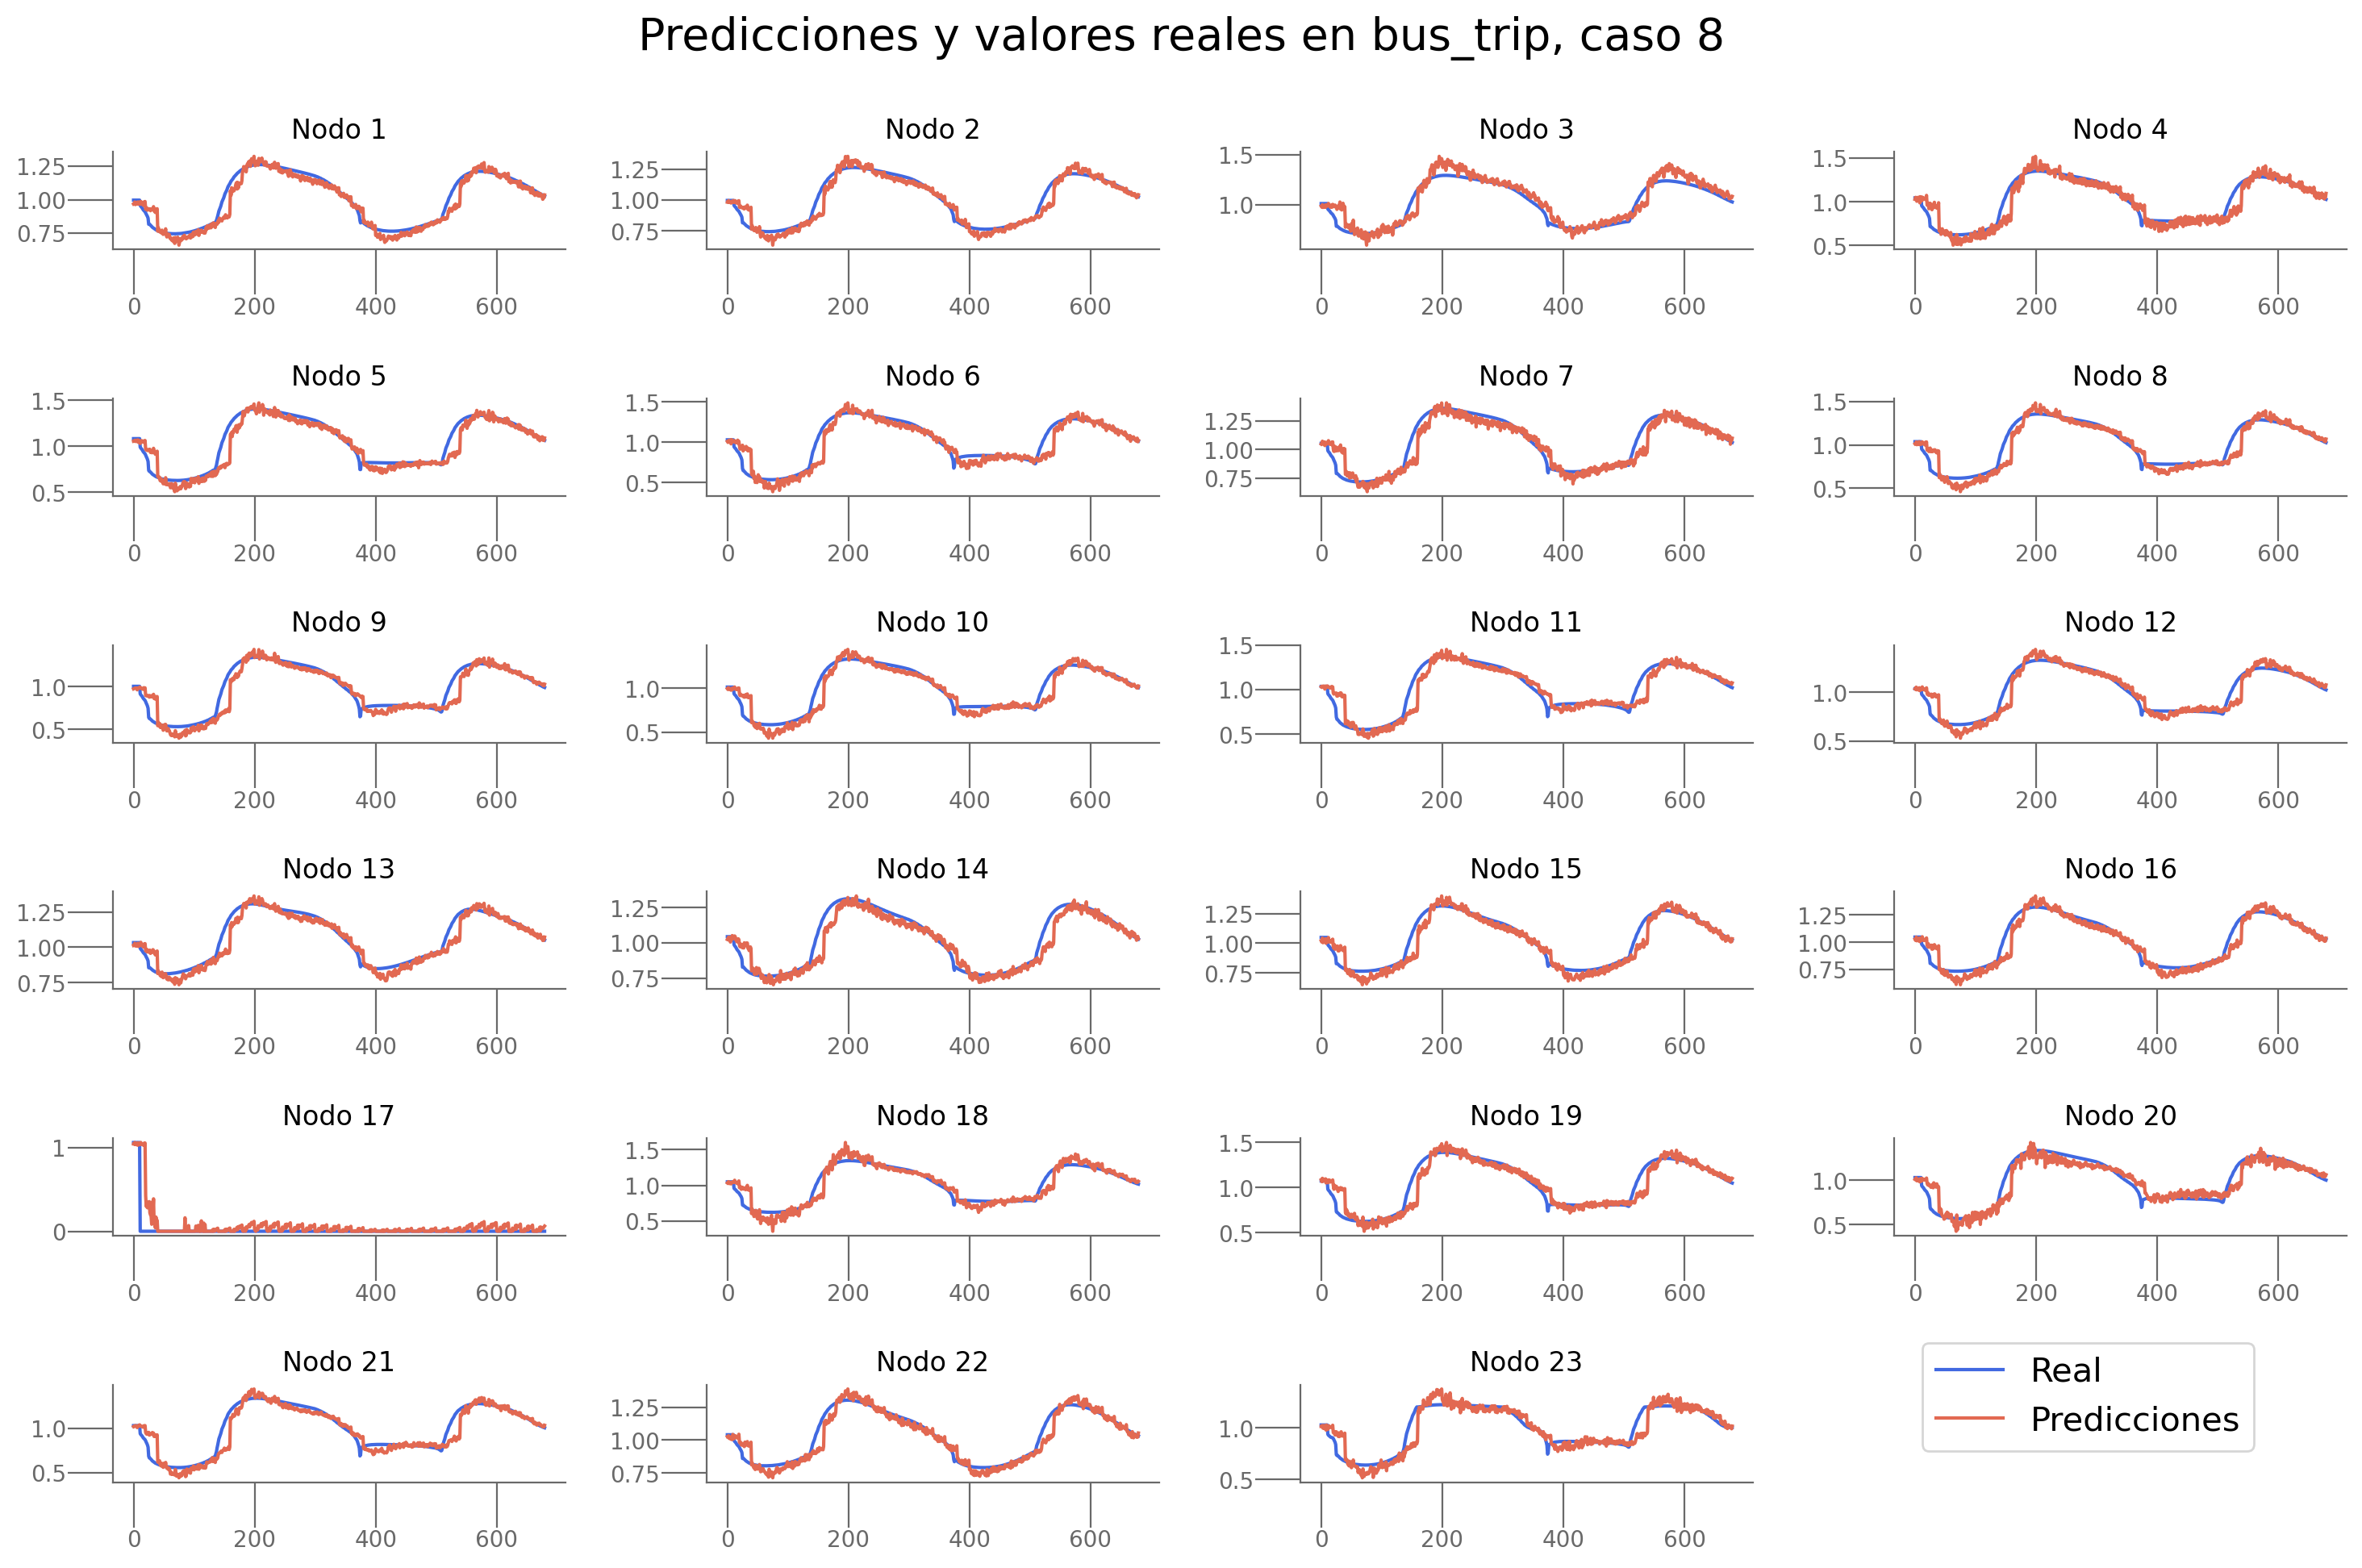

In [22]:
plot_predictions(predictions_bt_ajuste, real_bt_ajuste, n_target, 8, n_div_bt, problem_bt)

In [23]:
path_save_experiment_bt = results_save_path+f"/{problem_bt}"+ f"/ajustes/{name_model}_results.csv"
resultados_bt.to_csv(path_save_experiment_bt, index=False)

In [24]:
trainer_bt.save_model(path_save_experiment=path_save_experiment_bt, params=params_bt)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                             Params  \
0          LSTM                                                NaN   
1  LSTM_NOBATCH                                                NaN   
2     MPNN_LSTM                                          (32, 0.8)   
3   DyGrEncoder              {'aggr': 'add', 'conv': 1, 'lstm': 1}   
4         DCRNN                                     {'hidden': 60}   
5     EvolveGCN                                                NaN   
6        ASTGCN  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_...   
7         AGCRN            {'hidden': 10, 'K': 10, 'embedding': 3}   
8        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   

                      Fichero_resultados_experimento  Loss_tst    R2_tst  \
0                                                NaN  0.005474  0.923150   
1                                                NaN  0.005606  0.865487   
2    ./

### Bus fault

In [26]:
problem_bf = "bus_fault"
dataset_bf, situations_bf = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_bf)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  86


In [27]:
n_div_bf = loader.div
n_nodes =dataset_bf.features[0].shape[0]
n_target = dataset_bf.targets[0].shape[1]
n_features = dataset_bf[0].x.shape[1]
hidden_size =32
dropout = 0.5

num_early_stop = 0
num_epochs = 30
lr = 0.01

#### Sencilla 

In [28]:

device =  torch.device("cpu")
model_bf = MSTGCNModel(name="MSTGCN", node_features=n_features, node_count=n_nodes, n_target=n_target, nb_block=2, k=2, nb_chev_filter = 2, nb_time_filter =2, time_strides = 2)


trainer_bf = TrainerMSTGCN(model_bf, dataset_bf,device, f"./results/{problem_bf}", dataloader_params2)


losses,eval_losses, r2scores  = trainer_bf.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)





==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.2157 | Eval Loss: 0.1900 | Eval R2: -34.7477 | LR: 0.0010 | 
Epoch 2/30 | Train Loss: 0.1825 | Eval Loss: 0.1889 | Eval R2: -35.0900 | LR: 0.0010 | 
Epoch 3/30 | Train Loss: 0.1822 | Eval Loss: 0.1890 | Eval R2: -34.9072 | LR: 0.0010 | 
Epoch 4/30 | Train Loss: 0.1823 | Eval Loss: 0.1890 | Eval R2: -34.8570 | LR: 0.0010 | 
Epoch 5/30 | Train Loss: 0.1823 | Eval Loss: 0.1889 | Eval R2: -34.8757 | LR: 0.0010 | 
Epoch 6/30 | Train Loss: 0.1822 | Eval Loss: 0.1889 | Eval R2: -34.9345 | LR: 0.0010 | 
Epoch 7/30 | Train Loss: 0.1822 | Eval Loss: 0.1888 | Eval R2: -35.0194 | LR: 0.0010 | 
Epoch 8/30 | Train Loss: 0.1821 | Eval Loss: 0.1887 | Eval R2: -35.1069 | LR: 0.0010 | 
Epoch 9/30 | Train Loss: 0.1821 | Eval Loss: 0.1885 | Eval R2: -35.2109 | LR: 0.0010 | 
Epoch 10/30 | Train Loss: 0.1820 | E

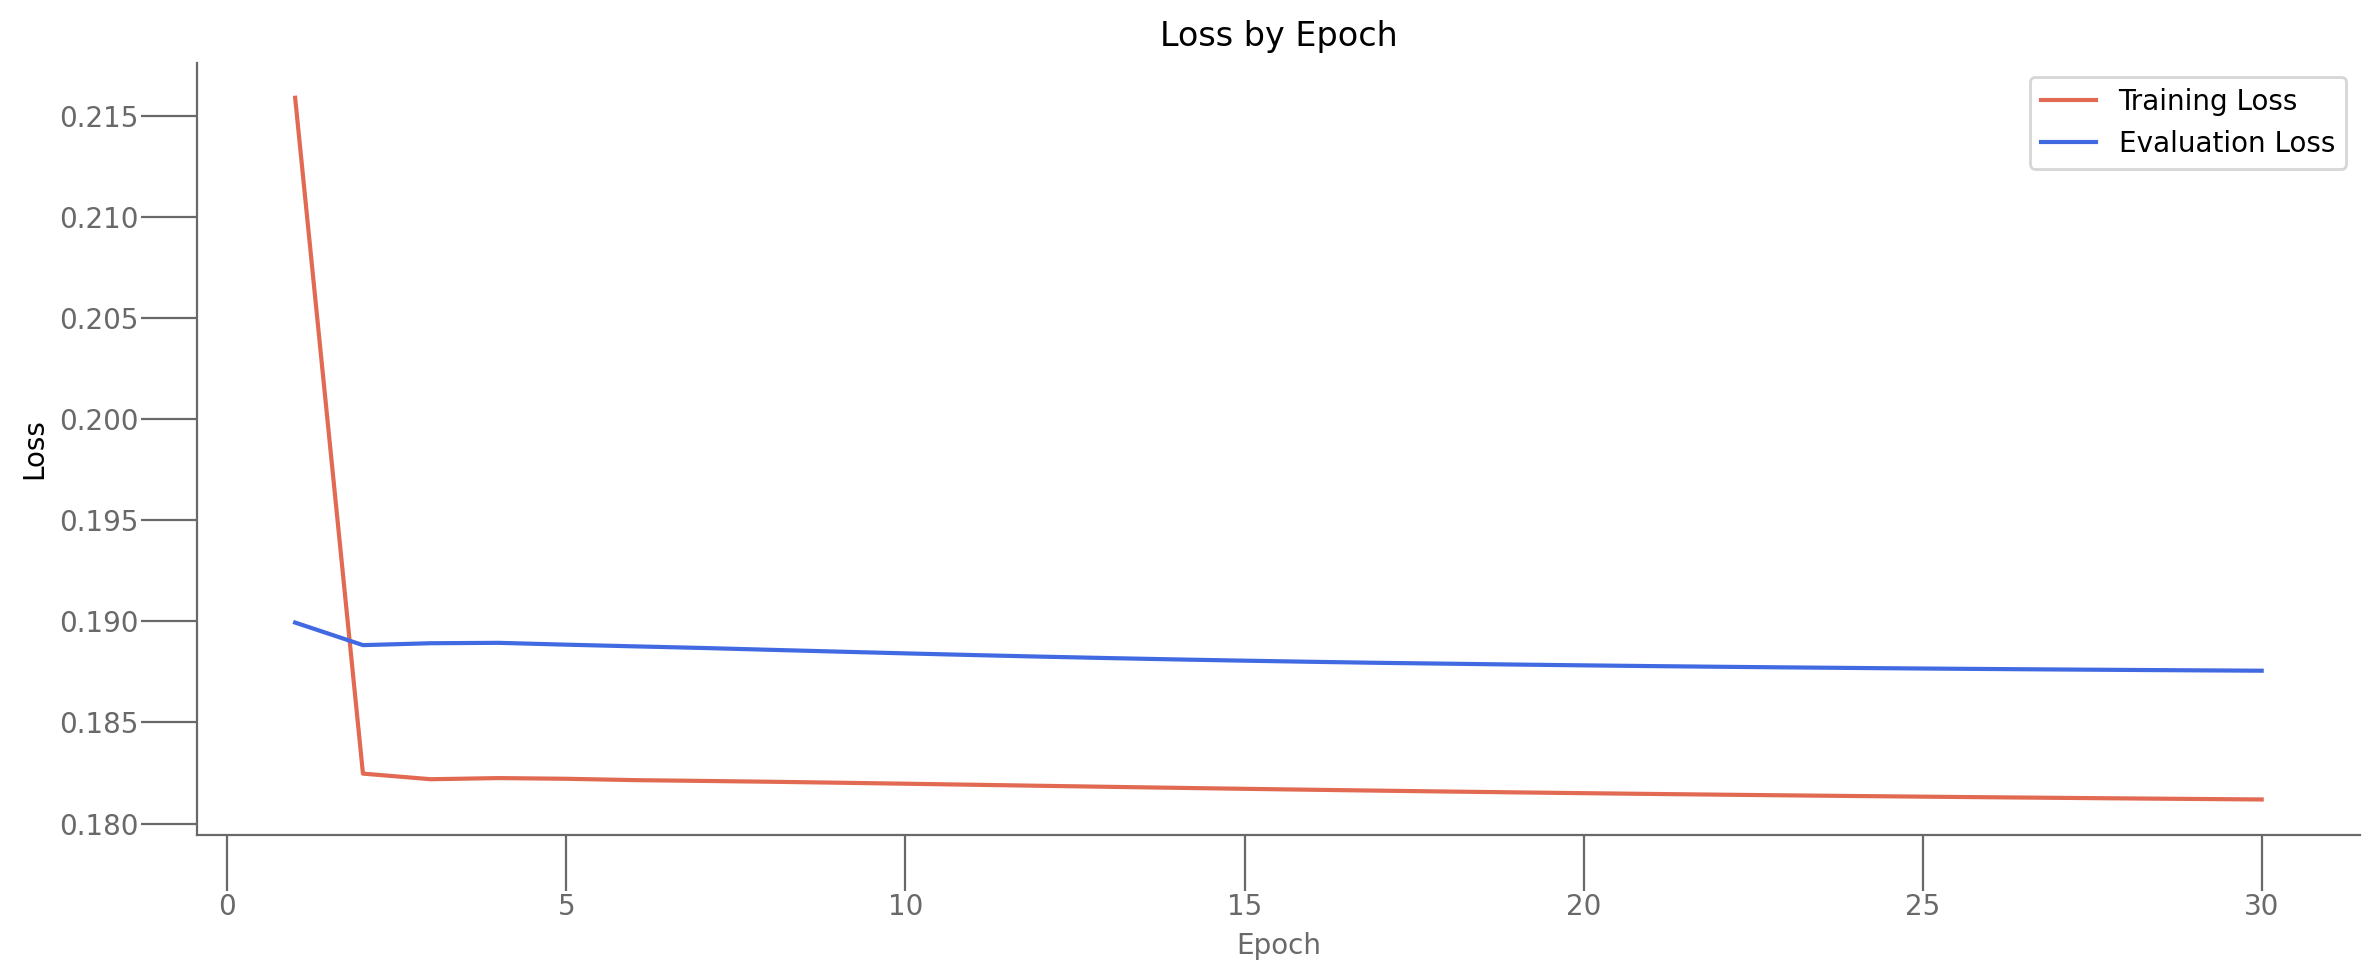


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.150332, test r2score -27.624034


In [23]:
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_bf, real_bf = trainer_bf.test()

#### Ajuste de parámetros 

In [29]:

num_epochs = 100
num_early_stop = 10
trainer_bf,params_bf,resultados_final_bf, resultados_bf = entrenar_y_evaluar_modelos_mstgcn(param_grid, dataset_bf, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_bf)

  0%|          | 0/54 [00:00<?, ?it/s]

Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=50

==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 0.5841 | Eval Loss: 0.3680 | Eval R2: -69.8562 | LR: 0.0010 | 
Epoch 2/100 | Train Loss: 0.3034 | Eval Loss: 0.2542 | Eval R2: -52.1949 | LR: 0.0010 | 
Epoch 3/100 | Train Loss: 0.2419 | Eval Loss: 0.2274 | Eval R2: -49.9254 | LR: 0.0010 | 
Epoch 4/100 | Train Loss: 0.2180 | Eval Loss: 0.2115 | Eval R2: -45.0385 | LR: 0.0010 | 
Epoch 5/100 | Train Loss: 0.2031 | Eval Loss: 0.1991 | Eval R2: -40.7461 | LR: 0.0010 | 
Epoch 6/100 | Train Loss: 0.1922 | Eval Loss: 0.1911 | Eval R2: -39.2047 | LR: 0.0010 | 
Epoch 7/100 | Train Loss: 0.1840 | Eval Loss: 0.1845 | Eval R2: -36.4209 | LR: 0.0010 | 
Epoch 8/100 | Train Loss: 0.1767 | Eval Loss: 0.1781 | Eval R2: -33.9309 | LR: 0.0010 | 
Epoch 9/100 | Train 

  2%|▏         | 1/54 [06:12<5:29:06, 372.57s/it]

preds:  (1, 23, 20)
test loss: 0.064200, test R2 score: -7.635544
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.08413126319646835, 'r2_eval_final': -10.977245330810547, 'loss_eval_final': 0.09651867300271988, 'r2_test': -7.635543541640371, 'loss_test': 0.06419992446899414, 'loss_nodes': [0.07145623117685318, 0.05728942155838013, 0.05205522105097771, 0.08427750319242477, 0.08307438343763351, 0.10093610733747482, 0.07892487943172455, 0.05360836163163185, 0.0824626013636589, 0.051467958837747574, 0.06183823570609093, 0.04607810452580452, 0.051768556237220764, 0.08887319266796112, 0.051552265882492065, 0.04916832596063614, 0.05745438486337662, 0.08252213895320892, 0.06643210351467133, 0.06212495639920235, 0.057956255972385406, 0.0429067425429821, 0.042370304465293884]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=80

==================== DATASET INFO =======

  4%|▎         | 2/54 [12:38<5:29:31, 380.22s/it]

preds:  (1, 23, 20)
test loss: 0.064668, test R2 score: -7.501410
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.08597265928983688, 'r2_eval_final': -11.051156044006348, 'loss_eval_final': 0.09767608344554901, 'r2_test': -7.501409768311363, 'loss_test': 0.06466824561357498, 'loss_nodes': [0.06866442412137985, 0.05526582524180412, 0.05098627507686615, 0.08575879782438278, 0.07872789353132248, 0.10023535043001175, 0.08277352899312973, 0.0538424514234066, 0.08090262860059738, 0.050994180142879486, 0.0648103579878807, 0.04630500450730324, 0.04978200048208237, 0.10184751451015472, 0.05174684152007103, 0.04961340129375458, 0.05712467059493065, 0.07848980277776718, 0.06968188285827637, 0.06179679185152054, 0.06014631688594818, 0.04545537382364273, 0.042418308556079865]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=100

==================== DATASET INFO =========

  6%|▌         | 3/54 [19:01<5:24:21, 381.61s/it]

preds:  (1, 23, 20)
test loss: 0.064320, test R2 score: -7.580030
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.08486907929182053, 'r2_eval_final': -11.083836555480957, 'loss_eval_final': 0.09747231751680374, 'r2_test': -7.580029931214483, 'loss_test': 0.06432018429040909, 'loss_nodes': [0.07085181027650833, 0.056627385318279266, 0.050968680530786514, 0.08455482870340347, 0.08318450301885605, 0.10225850343704224, 0.07831420749425888, 0.053873710334300995, 0.08289740979671478, 0.05145819112658501, 0.06377365440130234, 0.04550040140748024, 0.050584577023983, 0.08935321867465973, 0.051294002681970596, 0.048849355429410934, 0.05737357586622238, 0.08323207497596741, 0.06779385358095169, 0.06242961809039116, 0.05899592861533165, 0.04307625815272331, 0.04211832582950592]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=50

==================== DATASET INFO ======

  7%|▋         | 4/54 [24:22<4:58:14, 357.89s/it]

preds:  (1, 23, 20)
test loss: 0.244383, test R2 score: -51.548486
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.2642301321029663, 'r2_eval_final': -62.92231369018555, 'loss_eval_final': 0.26056599617004395, 'r2_test': -51.54848625409408, 'loss_test': 0.24438273906707764, 'loss_nodes': [0.23375844955444336, 0.22761303186416626, 0.21628446877002716, 0.23236864805221558, 0.2551645040512085, 0.23926705121994019, 0.2323639690876007, 0.23148252069950104, 0.25406914949417114, 0.21841943264007568, 0.23703554272651672, 0.21798238158226013, 0.2684473693370819, 0.2765599489212036, 0.27303189039230347, 0.2674742639064789, 0.25432059168815613, 0.2568081021308899, 0.26042452454566956, 0.24068114161491394, 0.23218189179897308, 0.30501270294189453, 0.19005125761032104]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=80

==================== DATASET INFO =================

  9%|▉         | 5/54 [30:14<4:50:19, 355.50s/it]

preds:  (1, 23, 20)
test loss: 0.244383, test R2 score: -51.548487
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.2642301321029663, 'r2_eval_final': -62.92231369018555, 'loss_eval_final': 0.26056599617004395, 'r2_test': -51.54848659535712, 'loss_test': 0.24438273906707764, 'loss_nodes': [0.23375844955444336, 0.22761306166648865, 0.21628446877002716, 0.2323686182498932, 0.2551645040512085, 0.239267036318779, 0.2323639690876007, 0.23148252069950104, 0.25406914949417114, 0.21841944754123688, 0.23703554272651672, 0.21798238158226013, 0.2684473693370819, 0.2765599489212036, 0.2730318605899811, 0.26747429370880127, 0.25432059168815613, 0.2568081319332123, 0.26042452454566956, 0.24068112671375275, 0.23218189179897308, 0.3050127327442169, 0.19005127251148224]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=100

==================== DATASET INFO ===================


 11%|█         | 6/54 [35:53<4:40:01, 350.03s/it]

preds:  (1, 23, 20)
test loss: 0.244383, test R2 score: -51.548486
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.2642301321029663, 'r2_eval_final': -62.92231369018555, 'loss_eval_final': 0.26056599617004395, 'r2_test': -51.54848611643228, 'loss_test': 0.24438273906707764, 'loss_nodes': [0.23375847935676575, 0.22761304676532745, 0.21628446877002716, 0.23236864805221558, 0.2551645040512085, 0.23926708102226257, 0.2323639690876007, 0.23148250579833984, 0.25406914949417114, 0.21841944754123688, 0.23703554272651672, 0.21798233687877655, 0.2684473693370819, 0.2765599489212036, 0.27303189039230347, 0.26747429370880127, 0.25432059168815613, 0.2568081319332123, 0.26042458415031433, 0.24068112671375275, 0.23218189179897308, 0.30501270294189453, 0.19005122780799866]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=50

==================== DATASET INFO ==============

 13%|█▎        | 7/54 [41:33<4:31:30, 346.61s/it]

preds:  (1, 23, 20)
test loss: 0.128557, test R2 score: -22.862793
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.16490083932876587, 'r2_eval_final': -31.32716941833496, 'loss_eval_final': 0.16918903589248657, 'r2_test': -22.862793344115225, 'loss_test': 0.12855744361877441, 'loss_nodes': [0.10859892517328262, 0.08684925734996796, 0.09226188063621521, 0.1299818456172943, 0.14896856248378754, 0.14974473416805267, 0.10102194547653198, 0.13277031481266022, 0.18194998800754547, 0.12078998237848282, 0.1422073245048523, 0.09570387005805969, 0.09774399548768997, 0.12880486249923706, 0.1382950395345688, 0.13052338361740112, 0.1464730054140091, 0.1542690396308899, 0.15847325325012207, 0.14824622869491577, 0.14286181330680847, 0.1336437165737152, 0.08663852512836456]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=80

==================== DATASET INFO =============

 15%|█▍        | 8/54 [50:54<5:18:05, 414.91s/it]

preds:  (1, 23, 20)
test loss: 0.128558, test R2 score: -22.863033
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.16490088403224945, 'r2_eval_final': -31.327455520629883, 'loss_eval_final': 0.16918893158435822, 'r2_test': -22.86303344736169, 'loss_test': 0.12855777144432068, 'loss_nodes': [0.10859937965869904, 0.08684996515512466, 0.09226225316524506, 0.12998193502426147, 0.14896878600120544, 0.14974446594715118, 0.10102248936891556, 0.132770374417305, 0.18194960057735443, 0.12079007923603058, 0.14220717549324036, 0.09570429474115372, 0.09774528443813324, 0.12880584597587585, 0.13829568028450012, 0.13052402436733246, 0.146473228931427, 0.15426906943321228, 0.15847338736057281, 0.14824603497982025, 0.14286167919635773, 0.13364504277706146, 0.08663858473300934]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=100

==================== DATASET INFO ==========

 17%|█▋        | 9/54 [57:12<5:02:27, 403.27s/it]

preds:  (1, 23, 20)
test loss: 0.128557, test R2 score: -22.862739
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.16490083932876587, 'r2_eval_final': -31.327106475830078, 'loss_eval_final': 0.16918908059597015, 'r2_test': -22.862739063757942, 'loss_test': 0.12855738401412964, 'loss_nodes': [0.10859880596399307, 0.08684904128313065, 0.09226176887750626, 0.1299818456172943, 0.14896850287914276, 0.14974473416805267, 0.10102179646492004, 0.13277031481266022, 0.18195009231567383, 0.12078998237848282, 0.14220742881298065, 0.09570379555225372, 0.09774371981620789, 0.1288047730922699, 0.13829492032527924, 0.1305231899023056, 0.14647294580936432, 0.1542689949274063, 0.1584731638431549, 0.148246169090271, 0.14286191761493683, 0.13364344835281372, 0.08663851767778397]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=50

==================== DATASET INFO =============

 19%|█▊        | 10/54 [1:02:36<4:37:55, 379.00s/it]

preds:  (1, 23, 20)
test loss: 0.135491, test R2 score: -28.418604
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.13170665502548218, 'r2_eval_final': -33.174072265625, 'loss_eval_final': 0.13628676533699036, 'r2_test': -28.418604228772033, 'loss_test': 0.13549137115478516, 'loss_nodes': [0.1331627368927002, 0.13992320001125336, 0.13031095266342163, 0.12854498624801636, 0.13613829016685486, 0.12692417204380035, 0.14038404822349548, 0.12470751255750656, 0.11725373566150665, 0.12054797261953354, 0.12585878372192383, 0.13057300448417664, 0.16502854228019714, 0.15960097312927246, 0.14912283420562744, 0.15062926709651947, 0.13478051126003265, 0.13318008184432983, 0.1333180069923401, 0.1241941750049591, 0.12052582949399948, 0.1748717576265335, 0.1167200580239296]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=80

==================== DATASET INFO ================

 20%|██        | 11/54 [1:08:12<4:22:05, 365.71s/it]

preds:  (1, 23, 20)
test loss: 0.135491, test R2 score: -28.418566
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.13170689344406128, 'r2_eval_final': -33.17409133911133, 'loss_eval_final': 0.13628700375556946, 'r2_test': -28.41856564504132, 'loss_test': 0.1354910135269165, 'loss_nodes': [0.13316276669502258, 0.1399233043193817, 0.1303103268146515, 0.12854526937007904, 0.13613875210285187, 0.1269243061542511, 0.14038431644439697, 0.12470655888319016, 0.11725283414125443, 0.12054769694805145, 0.12585888803005219, 0.1305720955133438, 0.16502730548381805, 0.15960033237934113, 0.14912240207195282, 0.15062889456748962, 0.13477960228919983, 0.13318030536174774, 0.13331805169582367, 0.12419407069683075, 0.12052585929632187, 0.1748705804347992, 0.11671909689903259]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=100

==================== DATASET INFO ===============

 22%|██▏       | 12/54 [1:14:11<4:14:42, 363.86s/it]

preds:  (1, 23, 20)
test loss: 0.135491, test R2 score: -28.418592
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.13170693814754486, 'r2_eval_final': -33.17410659790039, 'loss_eval_final': 0.13628706336021423, 'r2_test': -28.4185917541849, 'loss_test': 0.1354912370443344, 'loss_nodes': [0.13316281139850616, 0.13992328941822052, 0.13031059503555298, 0.12854531407356262, 0.1361386477947235, 0.1269245743751526, 0.14038445055484772, 0.12470693141222, 0.11725325137376785, 0.12054790556430817, 0.12585897743701935, 0.13057249784469604, 0.1650276482105255, 0.15960073471069336, 0.1491226702928543, 0.15062914788722992, 0.13477998971939087, 0.13318033516407013, 0.1333182007074356, 0.12419421225786209, 0.12052605301141739, 0.17487101256847382, 0.11671935766935349]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=50

==================== DATASET INFO ===================

 24%|██▍       | 13/54 [1:19:18<3:56:42, 346.41s/it]

preds:  (1, 23, 20)
test loss: 0.198609, test R2 score: -44.516883
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.1939537525177002, 'r2_eval_final': -53.02073287963867, 'loss_eval_final': 0.19953057169914246, 'r2_test': -44.51688283899712, 'loss_test': 0.19860854744911194, 'loss_nodes': [0.1961689442396164, 0.2067440003156662, 0.1915372759103775, 0.18586944043636322, 0.19950060546398163, 0.18144424259662628, 0.20597824454307556, 0.1826106458902359, 0.17182205617427826, 0.1767842173576355, 0.18410655856132507, 0.1920439451932907, 0.24317142367362976, 0.23286078870296478, 0.2206244319677353, 0.22181525826454163, 0.19767199456691742, 0.19495269656181335, 0.19731351733207703, 0.1817290484905243, 0.17660130560398102, 0.25828853249549866, 0.16835704445838928]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=80

==================== DATASET INFO ===================

 26%|██▌       | 14/54 [1:24:42<3:46:32, 339.80s/it]

preds:  (1, 23, 20)
test loss: 0.198609, test R2 score: -44.516882
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.1939537525177002, 'r2_eval_final': -53.02073287963867, 'loss_eval_final': 0.19953057169914246, 'r2_test': -44.51688186082717, 'loss_test': 0.19860854744911194, 'loss_nodes': [0.1961689293384552, 0.2067439705133438, 0.1915372908115387, 0.18586942553520203, 0.19950056076049805, 0.1814442127943039, 0.20597819983959198, 0.18261070549488068, 0.17182211577892303, 0.1767842024564743, 0.18410655856132507, 0.1920439600944519, 0.24317146837711334, 0.2328607589006424, 0.22062444686889648, 0.22181525826454163, 0.1976720243692398, 0.19495271146297455, 0.19731353223323822, 0.18172909319400787, 0.17660130560398102, 0.25828856229782104, 0.16835707426071167]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=100

==================== DATASET INFO ==================

 28%|██▊       | 15/54 [1:30:03<3:37:14, 334.22s/it]

preds:  (1, 23, 20)
test loss: 0.198609, test R2 score: -44.516879
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.193953737616539, 'r2_eval_final': -53.02073287963867, 'loss_eval_final': 0.19953054189682007, 'r2_test': -44.5168790825835, 'loss_test': 0.19860854744911194, 'loss_nodes': [0.196168914437294, 0.20674392580986023, 0.1915372610092163, 0.18586938083171844, 0.19950060546398163, 0.1814442127943039, 0.205978125333786, 0.18261069059371948, 0.17182208597660065, 0.1767842024564743, 0.18410652875900269, 0.1920439451932907, 0.24317146837711334, 0.23286063969135284, 0.2206244319677353, 0.22181525826454163, 0.1976720541715622, 0.19495269656181335, 0.19731351733207703, 0.18172907829284668, 0.1766013205051422, 0.25828853249549866, 0.16835704445838928]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=50

==================== DATASET INFO ===================

T

 30%|██▉       | 16/54 [1:35:05<3:25:26, 324.37s/it]

preds:  (1, 23, 20)
test loss: 0.022080, test R2 score: -1.611957
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.02841844968497753, 'r2_eval_final': -3.976560592651367, 'loss_eval_final': 0.041253712028265, 'r2_test': -1.6119574075720573, 'loss_test': 0.02208005264401436, 'loss_nodes': [0.014050782658159733, 0.011854716576635838, 0.015155764296650887, 0.025609368458390236, 0.0283951573073864, 0.0318642295897007, 0.018910707905888557, 0.024717051535844803, 0.03153810650110245, 0.023989103734493256, 0.028675459325313568, 0.016420232132077217, 0.009033510461449623, 0.019603807479143143, 0.018353968858718872, 0.0200157780200243, 0.02520936168730259, 0.02700900100171566, 0.0278897974640131, 0.027567584067583084, 0.02788078971207142, 0.013793744146823883, 0.02030320279300213]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=80

==================== DATASET INFO 

 31%|███▏      | 17/54 [1:40:24<3:19:06, 322.87s/it]

preds:  (1, 23, 20)
test loss: 0.022080, test R2 score: -1.611926
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.028418486937880516, 'r2_eval_final': -3.9765100479125977, 'loss_eval_final': 0.041253771632909775, 'r2_test': -1.611925753123064, 'loss_test': 0.022079987451434135, 'loss_nodes': [0.014050798490643501, 0.011854681186378002, 0.015155741944909096, 0.025609223172068596, 0.028394998982548714, 0.031864069402217865, 0.018910590559244156, 0.024717042222619057, 0.031538236886262894, 0.023989103734493256, 0.028675461187958717, 0.016420209780335426, 0.0090335039421916, 0.019603244960308075, 0.018353885039687157, 0.020015660673379898, 0.025209344923496246, 0.027008917182683945, 0.02788972668349743, 0.027567561715841293, 0.02788078971207142, 0.013793697580695152, 0.02030319534242153]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=100

====================

 33%|███▎      | 18/54 [1:45:33<3:11:05, 318.48s/it]

preds:  (1, 23, 20)
test loss: 0.022080, test R2 score: -1.611973
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.02841864340007305, 'r2_eval_final': -3.9765491485595703, 'loss_eval_final': 0.041253846138715744, 'r2_test': -1.611973081724701, 'loss_test': 0.022080188617110252, 'loss_nodes': [0.014051100239157677, 0.011854942888021469, 0.015155998058617115, 0.02560940384864807, 0.028395479544997215, 0.03186432644724846, 0.018910685554146767, 0.024717137217521667, 0.03153844177722931, 0.023989329114556313, 0.028675345703959465, 0.01642034947872162, 0.00903359055519104, 0.019604777917265892, 0.018354061990976334, 0.02001582831144333, 0.025209415704011917, 0.02700931392610073, 0.027889607474207878, 0.027567816898226738, 0.027880625799298286, 0.01379353180527687, 0.02030327543616295]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=50

==================== DATAS

 35%|███▌      | 19/54 [1:52:03<3:18:22, 340.08s/it]

preds:  (1, 23, 20)
test loss: 0.047552, test R2 score: -7.998375
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.04697585478425026, 'r2_eval_final': -10.441097259521484, 'loss_eval_final': 0.0566202737390995, 'r2_test': -7.998375350239649, 'loss_test': 0.04755183681845665, 'loss_nodes': [0.04219680652022362, 0.04298561066389084, 0.042523518204689026, 0.047600194811820984, 0.051070354878902435, 0.050538044422864914, 0.04666438698768616, 0.04727528244256973, 0.049925122410058975, 0.04495391249656677, 0.05066579207777977, 0.04297349229454994, 0.047284919768571854, 0.049701813608407974, 0.04716305434703827, 0.04897834360599518, 0.04936479032039642, 0.049375612288713455, 0.05153104290366173, 0.04777015000581741, 0.04888535290956497, 0.050999101251363754, 0.04326542839407921]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=80

==================== DATASET INFO ==

 37%|███▋      | 20/54 [1:58:33<3:21:10, 355.00s/it]

preds:  (1, 23, 20)
test loss: 0.047552, test R2 score: -7.998383
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.04697587713599205, 'r2_eval_final': -10.441100120544434, 'loss_eval_final': 0.05662035942077637, 'r2_test': -7.998383497441352, 'loss_test': 0.04755189269781113, 'loss_nodes': [0.04219697415828705, 0.04298575595021248, 0.04252364858984947, 0.04760025814175606, 0.051070455461740494, 0.050538089126348495, 0.046664465218782425, 0.04727524146437645, 0.04992517828941345, 0.04495406523346901, 0.05066589638590813, 0.04297346994280815, 0.04728485271334648, 0.04970185086131096, 0.047163188457489014, 0.04897846281528473, 0.04936469718813896, 0.049375828355550766, 0.05153105407953262, 0.04777027666568756, 0.048885367810726166, 0.0509989932179451, 0.04326540604233742]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=100

==================== DATASET INFO ====

 39%|███▉      | 21/54 [2:04:37<3:16:41, 357.63s/it]

preds:  (1, 23, 20)
test loss: 0.047552, test R2 score: -7.998381
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.0469760037958622, 'r2_eval_final': -10.441118240356445, 'loss_eval_final': 0.056620508432388306, 'r2_test': -7.998381219346491, 'loss_test': 0.04755189269781113, 'loss_nodes': [0.04219682887196541, 0.042985592037439346, 0.04252350330352783, 0.04760031774640083, 0.05107032135128975, 0.05053817853331566, 0.04666447639465332, 0.04727525636553764, 0.04992513358592987, 0.044953882694244385, 0.05066594481468201, 0.04297352582216263, 0.04728497192263603, 0.04970215633511543, 0.047163140028715134, 0.048978403210639954, 0.049364808946847916, 0.04937560483813286, 0.05153113603591919, 0.04777015373110771, 0.04888545349240303, 0.05099918320775032, 0.043265484273433685]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=50

==================== DATASET INFO ===

 41%|████      | 22/54 [2:10:10<3:06:51, 350.37s/it]

preds:  (1, 23, 20)
test loss: 0.020664, test R2 score: -1.261408
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.02408364973962307, 'r2_eval_final': -2.9594016075134277, 'loss_eval_final': 0.035716407001018524, 'r2_test': -1.2614084039275038, 'loss_test': 0.020664332434535027, 'loss_nodes': [0.014866609126329422, 0.012424526736140251, 0.0150536447763443, 0.02277239039540291, 0.026672493666410446, 0.0284444447606802, 0.016701985150575638, 0.023081466555595398, 0.02971349097788334, 0.02266758307814598, 0.02809089422225952, 0.01492773275822401, 0.008364733308553696, 0.015645107254385948, 0.015975188463926315, 0.0178158488124609, 0.02317291684448719, 0.02582509256899357, 0.027130678296089172, 0.026183977723121643, 0.02794703282415867, 0.011304986663162708, 0.020496860146522522]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=80

==================== DATASET INF

 43%|████▎     | 23/54 [2:15:43<2:58:17, 345.09s/it]

preds:  (1, 23, 20)
test loss: 0.020664, test R2 score: -1.261413
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.024083701893687248, 'r2_eval_final': -2.959411382675171, 'loss_eval_final': 0.035716455429792404, 'r2_test': -1.2614131187950737, 'loss_test': 0.020664367824792862, 'loss_nodes': [0.014866759069263935, 0.012424679473042488, 0.015053621493279934, 0.022772381082177162, 0.026672711595892906, 0.028444504365324974, 0.016701892018318176, 0.023081457242369652, 0.029713358730077744, 0.022667545825242996, 0.028091033920645714, 0.01492773275822401, 0.008364704437553883, 0.015645133331418037, 0.015975208953022957, 0.017815861850976944, 0.0231728944927454, 0.02582530304789543, 0.02713080123066902, 0.026183968409895897, 0.027947138994932175, 0.01130498293787241, 0.02049686387181282]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=100

==================== DAT

 44%|████▍     | 24/54 [2:21:04<2:49:01, 338.06s/it]

preds:  (1, 23, 20)
test loss: 0.020664, test R2 score: -1.261410
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.02408365160226822, 'r2_eval_final': -2.959411144256592, 'loss_eval_final': 0.03571639582514763, 'r2_test': -1.2614098127480295, 'loss_test': 0.02066432312130928, 'loss_nodes': [0.014866659417748451, 0.012424576096236706, 0.015053659677505493, 0.02277239039540291, 0.02667250484228134, 0.028444519266486168, 0.016702013090252876, 0.02308143861591816, 0.02971336618065834, 0.022667590528726578, 0.02809079922735691, 0.014927728101611137, 0.008364729583263397, 0.015645049512386322, 0.015975235030055046, 0.017815889790654182, 0.023172909393906593, 0.025825107470154762, 0.027130577713251114, 0.026183992624282837, 0.027946902438998222, 0.011305000633001328, 0.020496847108006477]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=50

==================== DAT

 46%|████▋     | 25/54 [2:26:43<2:43:31, 338.33s/it]

preds:  (1, 23, 20)
test loss: 0.022076, test R2 score: -1.504805
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.026852451264858246, 'r2_eval_final': -3.6290500164031982, 'loss_eval_final': 0.039125118404626846, 'r2_test': -1.5048053184340786, 'loss_test': 0.02207634411752224, 'loss_nodes': [0.014702364802360535, 0.012456579133868217, 0.01507098414003849, 0.026309117674827576, 0.028393404558300972, 0.03280850127339363, 0.01909562572836876, 0.02412889152765274, 0.03072044625878334, 0.023784974589943886, 0.02967703528702259, 0.015388739295303822, 0.008489648811519146, 0.01801939122378826, 0.01827314868569374, 0.020176751539111137, 0.024271676316857338, 0.027378177270293236, 0.02879149280488491, 0.027532855048775673, 0.02929333969950676, 0.012604090385138988, 0.02038870006799698]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=80

==================== DATASE

 48%|████▊     | 26/54 [2:32:04<2:35:24, 333.02s/it]

preds:  (1, 23, 20)
test loss: 0.022076, test R2 score: -1.504802
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.026852278038859367, 'r2_eval_final': -3.6290104389190674, 'loss_eval_final': 0.039124857634305954, 'r2_test': -1.504802341223108, 'loss_test': 0.022076215595006943, 'loss_nodes': [0.014702803455293179, 0.01245703175663948, 0.015071152709424496, 0.026309074833989143, 0.028393184766173363, 0.03280821815133095, 0.019095664843916893, 0.024128533899784088, 0.03072008676826954, 0.023785099387168884, 0.02967667207121849, 0.015388472937047482, 0.008489194326102734, 0.018019337207078934, 0.018273204565048218, 0.02017691545188427, 0.024271264672279358, 0.027378110215067863, 0.028791023418307304, 0.027533015236258507, 0.029292885214090347, 0.012603680603206158, 0.020388338714838028]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=100

====================

 50%|█████     | 27/54 [2:37:19<2:27:25, 327.63s/it]

preds:  (1, 23, 20)
test loss: 0.022076, test R2 score: -1.504837
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.02685232274234295, 'r2_eval_final': -3.6290674209594727, 'loss_eval_final': 0.03912507742643356, 'r2_test': -1.504837317514229, 'loss_test': 0.022076258435845375, 'loss_nodes': [0.014702928252518177, 0.012457353062927723, 0.015071346424520016, 0.02630908600986004, 0.02839273028075695, 0.03280871361494064, 0.019095925614237785, 0.024128392338752747, 0.03072001039981842, 0.023785222321748734, 0.02967655099928379, 0.015388528816401958, 0.008489072322845459, 0.01801968924701214, 0.018273547291755676, 0.020177224650979042, 0.024271197617053986, 0.027377823367714882, 0.02879098430275917, 0.02753319777548313, 0.029292704537510872, 0.012603637762367725, 0.020388087257742882]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=50

==================== DATAS

 52%|█████▏    | 28/54 [2:47:57<3:02:18, 420.72s/it]

preds:  (1, 23, 20)
test loss: 0.151522, test R2 score: -28.636960
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.18487347662448883, 'r2_eval_final': -37.794132232666016, 'loss_eval_final': 0.18706999719142914, 'r2_test': -28.636960144599783, 'loss_test': 0.15152239799499512, 'loss_nodes': [0.13315075635910034, 0.11438613384962082, 0.1166224554181099, 0.15026545524597168, 0.16998600959777832, 0.16766847670078278, 0.1268140822649002, 0.15235774219036102, 0.1965181529521942, 0.14021800458431244, 0.1611451655626297, 0.1219598799943924, 0.13106060028076172, 0.15799933671951294, 0.16471609473228455, 0.15733326971530914, 0.16780714690685272, 0.17458726465702057, 0.1786438375711441, 0.1666785478591919, 0.16072922945022583, 0.16705414652824402, 0.10731343924999237]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=80

==================== DATASET INFO ===============

 54%|█████▎    | 29/54 [2:58:15<3:20:01, 480.06s/it]

preds:  (1, 23, 20)
test loss: 0.151343, test R2 score: -28.625515
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.18465881049633026, 'r2_eval_final': -37.781978607177734, 'loss_eval_final': 0.18687930703163147, 'r2_test': -28.62551530957173, 'loss_test': 0.151342511177063, 'loss_nodes': [0.13325589895248413, 0.11455748975276947, 0.11693788319826126, 0.1502830684185028, 0.17001938819885254, 0.1676347702741623, 0.12694847583770752, 0.1523607075214386, 0.19641438126564026, 0.14021670818328857, 0.16113288700580597, 0.1186501756310463, 0.12907664477825165, 0.15788815915584564, 0.16486386954784393, 0.15748998522758484, 0.16784678399562836, 0.17460398375988007, 0.1786600798368454, 0.166656032204628, 0.16069459915161133, 0.16734986007213593, 0.10733530670404434]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=100

==================== DATASET INFO =================

 56%|█████▌    | 30/54 [3:09:15<3:33:34, 533.93s/it]

preds:  (1, 23, 20)
test loss: 0.151538, test R2 score: -28.638657
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.18487487733364105, 'r2_eval_final': -37.793949127197266, 'loss_eval_final': 0.1870676428079605, 'r2_test': -28.638657372739008, 'loss_test': 0.15153835713863373, 'loss_nodes': [0.13314951956272125, 0.11438420414924622, 0.11662133783102036, 0.1502651423215866, 0.16998572647571564, 0.16766893863677979, 0.12681256234645844, 0.15235763788223267, 0.19651944935321808, 0.14021793007850647, 0.16114529967308044, 0.12198367714881897, 0.1310572624206543, 0.1583578735589981, 0.16471438109874725, 0.15733157098293304, 0.1678066849708557, 0.17458704113960266, 0.17864356935024261, 0.1666787564754486, 0.16072973608970642, 0.16705070436000824, 0.10731321573257446]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=50

==================== DATASET INFO =============

 57%|█████▋    | 31/54 [3:19:23<3:33:11, 556.15s/it]

preds:  (1, 23, 20)
test loss: 0.197930, test R2 score: -40.418194
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.224711611866951, 'r2_eval_final': -50.46491241455078, 'loss_eval_final': 0.2264760136604309, 'r2_test': -40.41819393580811, 'loss_test': 0.19793038070201874, 'loss_nodes': [0.1836366504430771, 0.17131631076335907, 0.1665867269039154, 0.19122254848480225, 0.21251511573791504, 0.20324058830738068, 0.1797667145729065, 0.19177712500095367, 0.22492298483848572, 0.1791638433933258, 0.19891202449798584, 0.16896826028823853, 0.20029941201210022, 0.21748469769954681, 0.2191077470779419, 0.21262091398239136, 0.21100066602230072, 0.21558088064193726, 0.2195020318031311, 0.20346230268478394, 0.19620464742183685, 0.2366076111793518, 0.14849907159805298]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=80

==================== DATASET INFO ===================


 59%|█████▉    | 32/54 [3:29:18<3:28:11, 567.82s/it]

preds:  (1, 23, 20)
test loss: 0.197930, test R2 score: -40.418202
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.224711611866951, 'r2_eval_final': -50.46492004394531, 'loss_eval_final': 0.2264760285615921, 'r2_test': -40.41820224490809, 'loss_test': 0.19793041050434113, 'loss_nodes': [0.18363666534423828, 0.17131631076335907, 0.1665867269039154, 0.19122254848480225, 0.21251510083675385, 0.20324058830738068, 0.17976675927639008, 0.19177711009979248, 0.2249229997396469, 0.1791638284921646, 0.19891200959682465, 0.1689682900905609, 0.2002994567155838, 0.2174847275018692, 0.2191077619791031, 0.21262091398239136, 0.21100066602230072, 0.21558088064193726, 0.2195020318031311, 0.20346234738826752, 0.19620461761951447, 0.2366076558828354, 0.14849908649921417]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=100

==================== DATASET INFO ===================



 61%|██████    | 33/54 [3:38:56<3:19:46, 570.77s/it]

preds:  (1, 23, 20)
test loss: 0.197930, test R2 score: -40.418212
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.224711611866951, 'r2_eval_final': -50.46493911743164, 'loss_eval_final': 0.2264760136604309, 'r2_test': -40.4182119472052, 'loss_test': 0.19793041050434113, 'loss_nodes': [0.1836366504430771, 0.17131629586219788, 0.1665867418050766, 0.19122256338596344, 0.21251507103443146, 0.20324058830738068, 0.17976677417755127, 0.19177711009979248, 0.22492294013500214, 0.17916378378868103, 0.19891202449798584, 0.1689683496952057, 0.20029953122138977, 0.2174847424030304, 0.2191077619791031, 0.21262092888355255, 0.21100066602230072, 0.21558092534542084, 0.2195020467042923, 0.20346230268478394, 0.19620457291603088, 0.23660771548748016, 0.14849908649921417]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=50

==================== DATASET INFO ==================

 63%|██████▎   | 34/54 [3:47:54<3:06:57, 560.88s/it]

preds:  (1, 23, 20)
test loss: 0.198240, test R2 score: -40.065956
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.2247127890586853, 'r2_eval_final': -49.98293685913086, 'loss_eval_final': 0.225539892911911, 'r2_test': -40.06595640583548, 'loss_test': 0.19824033975601196, 'loss_nodes': [0.18398109078407288, 0.1717207431793213, 0.16692882776260376, 0.19150790572166443, 0.2128090262413025, 0.20346780121326447, 0.1800873726606369, 0.19205571711063385, 0.22512340545654297, 0.17940831184387207, 0.19913475215435028, 0.1692807972431183, 0.20068496465682983, 0.21786081790924072, 0.2194662094116211, 0.21302245557308197, 0.21134383976459503, 0.2159050852060318, 0.21976542472839355, 0.20374739170074463, 0.1964719444513321, 0.23701423406600952, 0.14873963594436646]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=80

==================== DATASET INFO ==================

 65%|██████▍   | 35/54 [3:57:16<2:57:47, 561.42s/it]

preds:  (1, 23, 20)
test loss: 0.198239, test R2 score: -40.065867
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.22471190989017487, 'r2_eval_final': -49.98289489746094, 'loss_eval_final': 0.22553890943527222, 'r2_test': -40.06586685620607, 'loss_test': 0.19823938608169556, 'loss_nodes': [0.18397998809814453, 0.1717190444469452, 0.16692835092544556, 0.19150768220424652, 0.2128087282180786, 0.20346824824810028, 0.18008574843406677, 0.19205577671527863, 0.2251216471195221, 0.17940834164619446, 0.1991327553987503, 0.1692824810743332, 0.20068170130252838, 0.21785792708396912, 0.21946436166763306, 0.21302038431167603, 0.21134354174137115, 0.21590490639209747, 0.21976527571678162, 0.20374760031700134, 0.1964723765850067, 0.23701012134552002, 0.1487393081188202]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=100

==================== DATASET INFO ==============

 67%|██████▋   | 36/54 [4:06:40<2:48:37, 562.09s/it]

preds:  (1, 23, 20)
test loss: 0.198239, test R2 score: -40.065990
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.2247113287448883, 'r2_eval_final': -49.983062744140625, 'loss_eval_final': 0.22553788125514984, 'r2_test': -40.065990063244065, 'loss_test': 0.1982387751340866, 'loss_nodes': [0.18397919833660126, 0.1717177927494049, 0.1669280230998993, 0.19150760769844055, 0.21280847489833832, 0.20346848666667938, 0.18008452653884888, 0.192055806517601, 0.22512055933475494, 0.17940835654735565, 0.19913160800933838, 0.16928334534168243, 0.20067952573299408, 0.2178562432527542, 0.21946308016777039, 0.213018998503685, 0.21134324371814728, 0.21590469777584076, 0.21976502239704132, 0.2037479430437088, 0.19647255539894104, 0.23700779676437378, 0.14873915910720825]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=50

==================== DATASET INFO ================

 69%|██████▊   | 37/54 [4:17:41<2:47:38, 591.69s/it]

preds:  (1, 23, 20)
test loss: 0.020116, test R2 score: -1.300191
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.024154245853424072, 'r2_eval_final': -3.2370102405548096, 'loss_eval_final': 0.03595244884490967, 'r2_test': -1.3001908578633885, 'loss_test': 0.020116107538342476, 'loss_nodes': [0.01256165374070406, 0.010939368978142738, 0.014564442448318005, 0.023341715335845947, 0.024822626262903214, 0.028210539370775223, 0.016639916226267815, 0.023128729313611984, 0.02938159927725792, 0.02255438268184662, 0.02645692229270935, 0.015629686415195465, 0.008620871230959892, 0.01586403325200081, 0.01687815971672535, 0.018446186557412148, 0.023352939635515213, 0.02364492230117321, 0.025076108053326607, 0.02529345266520977, 0.025518450886011124, 0.011718295514583588, 0.020025499165058136]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=80

==================== DATAS

 70%|███████   | 38/54 [4:28:53<2:44:16, 616.00s/it]

preds:  (1, 23, 20)
test loss: 0.020116, test R2 score: -1.300222
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.024154555052518845, 'r2_eval_final': -3.237058639526367, 'loss_eval_final': 0.03595243766903877, 'r2_test': -1.3002215894420281, 'loss_test': 0.020115891471505165, 'loss_nodes': [0.012560607865452766, 0.010938361287117004, 0.014565910212695599, 0.023340212181210518, 0.024821113795042038, 0.02821001596748829, 0.016639458015561104, 0.023128103464841843, 0.02938271313905716, 0.022555895149707794, 0.026456141844391823, 0.015629112720489502, 0.008620194159448147, 0.015863468870520592, 0.016879184171557426, 0.018447307869791985, 0.02335202880203724, 0.0236450657248497, 0.025075795128941536, 0.025294622406363487, 0.025517603382468224, 0.011717927642166615, 0.020024681463837624]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=100

==================== DA

 72%|███████▏  | 39/54 [4:39:31<2:35:37, 622.50s/it]

preds:  (1, 23, 20)
test loss: 0.020116, test R2 score: -1.300131
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.024154312908649445, 'r2_eval_final': -3.236971855163574, 'loss_eval_final': 0.035952139645814896, 'r2_test': -1.3001311923674366, 'loss_test': 0.02011561580002308, 'loss_nodes': [0.012561006471514702, 0.010938591323792934, 0.014563444070518017, 0.023339886218309402, 0.024821195751428604, 0.02821006067097187, 0.01663978397846222, 0.023128537461161613, 0.02938486821949482, 0.022553125396370888, 0.02645527757704258, 0.015629993751645088, 0.008621406741440296, 0.015862638130784035, 0.016877027228474617, 0.01844511739909649, 0.023352906107902527, 0.02364467829465866, 0.025075718760490417, 0.025292573496699333, 0.025516696274280548, 0.011719233356416225, 0.020025407895445824]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=50

==================== DAT

 74%|███████▍  | 40/54 [4:49:09<2:22:08, 609.21s/it]

preds:  (1, 23, 20)
test loss: 0.020969, test R2 score: -1.359466
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.024218225851655006, 'r2_eval_final': -3.1101982593536377, 'loss_eval_final': 0.03521312400698662, 'r2_test': -1.3594664486016863, 'loss_test': 0.020969124510884285, 'loss_nodes': [0.015062876977026463, 0.012155321426689625, 0.015565691515803337, 0.021294595673680305, 0.025829574093222618, 0.02780155837535858, 0.01752524822950363, 0.025349410250782967, 0.03185007721185684, 0.02426815778017044, 0.0291304774582386, 0.01856321282684803, 0.008120638318359852, 0.017489902675151825, 0.01616363413631916, 0.018053842708468437, 0.02395648881793022, 0.025600064545869827, 0.025846829637885094, 0.024532200768589973, 0.02595055103302002, 0.012418617494404316, 0.019760889932513237]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=80

==================== DATASET

 76%|███████▌  | 41/54 [4:58:50<2:10:08, 600.68s/it]

preds:  (1, 23, 20)
test loss: 0.020969, test R2 score: -1.359505
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.024217957630753517, 'r2_eval_final': -3.1101832389831543, 'loss_eval_final': 0.03521284833550453, 'r2_test': -1.3595047564076743, 'loss_test': 0.020969321951270103, 'loss_nodes': [0.015063556842505932, 0.012155111879110336, 0.015564976260066032, 0.021295292302966118, 0.02582952193915844, 0.02780124917626381, 0.01752539351582527, 0.025349199771881104, 0.03185145929455757, 0.024267693981528282, 0.029130378738045692, 0.018563205376267433, 0.008120677433907986, 0.01749069057404995, 0.01616346649825573, 0.018053539097309113, 0.02395712584257126, 0.025600867345929146, 0.02584705501794815, 0.024532051756978035, 0.025950908660888672, 0.012419539503753185, 0.019761476665735245]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=100

==================== DATA

 78%|███████▊  | 42/54 [5:08:41<1:59:33, 597.78s/it]

preds:  (1, 23, 20)
test loss: 0.020969, test R2 score: -1.359451
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.02421804703772068, 'r2_eval_final': -3.110152006149292, 'loss_eval_final': 0.03521275892853737, 'r2_test': -1.3594506022491846, 'loss_test': 0.02096901834011078, 'loss_nodes': [0.015062756836414337, 0.012154834344983101, 0.015565074980258942, 0.021294381469488144, 0.025829195976257324, 0.02780088223516941, 0.017524780705571175, 0.025349212810397148, 0.031850866973400116, 0.024267559871077538, 0.029130076989531517, 0.018562378361821175, 0.008120757527649403, 0.017490115016698837, 0.016163770109415054, 0.018053922802209854, 0.023956462740898132, 0.025601351633667946, 0.02584660053253174, 0.024532238021492958, 0.025950465351343155, 0.012418699450790882, 0.019761014729738235]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=50

==================== 

 80%|███████▉  | 43/54 [5:17:41<1:46:24, 580.43s/it]

preds:  (1, 23, 20)
test loss: 0.025770, test R2 score: -2.038977
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.033738940954208374, 'r2_eval_final': -4.624762058258057, 'loss_eval_final': 0.05229577422142029, 'r2_test': -2.0389765529363055, 'loss_test': 0.0257695522159338, 'loss_nodes': [0.01625051721930504, 0.013042328879237175, 0.01745443046092987, 0.02843492478132248, 0.029957374557852745, 0.03475227206945419, 0.02057173289358616, 0.029253799468278885, 0.0381598137319088, 0.030117301270365715, 0.03382871672511101, 0.023486649617552757, 0.01165951881557703, 0.022099968045949936, 0.02111140824854374, 0.022653231397271156, 0.02942184917628765, 0.03188937157392502, 0.03171861171722412, 0.03291071951389313, 0.033575329929590225, 0.014981908723711967, 0.025368085131049156]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=80

==================== DATASET INFO

 81%|████████▏ | 44/54 [5:26:48<1:35:03, 570.38s/it]

preds:  (1, 23, 20)
test loss: 0.025770, test R2 score: -2.039094
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.033737823367118835, 'r2_eval_final': -4.62467098236084, 'loss_eval_final': 0.05229445546865463, 'r2_test': -2.039093565348801, 'loss_test': 0.025769900530576706, 'loss_nodes': [0.016250189393758774, 0.013048752211034298, 0.017454300075769424, 0.028434917330741882, 0.02995915897190571, 0.034753330051898956, 0.02057456038892269, 0.029253939166665077, 0.038159988820552826, 0.030119499191641808, 0.03383086249232292, 0.023476101458072662, 0.011659050360321999, 0.022100765258073807, 0.021110648289322853, 0.022652478888630867, 0.029421085491776466, 0.03189513459801674, 0.0317218154668808, 0.03291004151105881, 0.03357338905334473, 0.014980399049818516, 0.025367284193634987]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=100

==================== DATAS

 83%|████████▎ | 45/54 [5:36:19<1:25:34, 570.47s/it]

preds:  (1, 23, 20)
test loss: 0.025770, test R2 score: -2.038940
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.03374023735523224, 'r2_eval_final': -4.624967098236084, 'loss_eval_final': 0.05229872465133667, 'r2_test': -2.0389403111411513, 'loss_test': 0.025769904255867004, 'loss_nodes': [0.01624883897602558, 0.013040274381637573, 0.017454754561185837, 0.028434598818421364, 0.029955673962831497, 0.03475420922040939, 0.02057066187262535, 0.029254700988531113, 0.038159046322107315, 0.03012082725763321, 0.033826738595962524, 0.02349657006561756, 0.011665022931993008, 0.022094422951340675, 0.021113289520144463, 0.022655315697193146, 0.029423879459500313, 0.03188798204064369, 0.031715910881757736, 0.0329107865691185, 0.03357629477977753, 0.014983312226831913, 0.02536463551223278]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=50

==================== DATASET

 85%|████████▌ | 46/54 [5:48:51<1:23:20, 625.02s/it]

preds:  (1, 23, 20)
test loss: 0.018443, test R2 score: -0.903302
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.017896858975291252, 'r2_eval_final': -2.1713383197784424, 'loss_eval_final': 0.027409115806221962, 'r2_test': -0.9033021452328543, 'loss_test': 0.018442552536725998, 'loss_nodes': [0.012711572460830212, 0.011941524222493172, 0.014174757525324821, 0.02061099372804165, 0.02274131402373314, 0.024861784651875496, 0.017018228769302368, 0.021550752222537994, 0.025301989167928696, 0.019351404160261154, 0.02256997860968113, 0.016424519941210747, 0.00868014432489872, 0.013144219294190407, 0.013684197328984737, 0.015509017743170261, 0.020686747506260872, 0.025417789816856384, 0.02368210256099701, 0.022492755204439163, 0.023988639935851097, 0.01031261496245861, 0.01732167787849903]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=80

==================== DAT

 87%|████████▋ | 47/54 [6:01:30<1:17:35, 665.12s/it]

preds:  (1, 23, 20)
test loss: 0.018443, test R2 score: -0.903344
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.01789671555161476, 'r2_eval_final': -2.1713807582855225, 'loss_eval_final': 0.027409305796027184, 'r2_test': -0.9033440379641238, 'loss_test': 0.018442708998918533, 'loss_nodes': [0.012711314484477043, 0.011941254138946533, 0.014174963347613811, 0.020610840991139412, 0.022741489112377167, 0.024862436577677727, 0.017018478363752365, 0.021550899371504784, 0.025301899760961533, 0.01935139112174511, 0.02257007732987404, 0.016425134614109993, 0.008680039085447788, 0.01314433105289936, 0.013684459030628204, 0.015509150922298431, 0.020687030628323555, 0.025418339297175407, 0.023682493716478348, 0.022492794319987297, 0.023988747969269753, 0.010312682949006557, 0.017322005704045296]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=100

====================

 89%|████████▉ | 48/54 [6:14:17<1:09:34, 695.67s/it]

preds:  (1, 23, 20)
test loss: 0.018443, test R2 score: -0.903341
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.01789683848619461, 'r2_eval_final': -2.1713855266571045, 'loss_eval_final': 0.027409326285123825, 'r2_test': -0.9033408587165751, 'loss_test': 0.018442710861563683, 'loss_nodes': [0.012711587361991405, 0.011941780336201191, 0.014175006188452244, 0.02061096392571926, 0.022741422057151794, 0.02486274391412735, 0.017018798738718033, 0.02155080810189247, 0.025301888585090637, 0.01935146376490593, 0.02257002517580986, 0.016424475237727165, 0.008679923601448536, 0.013144372962415218, 0.013684434816241264, 0.015509175136685371, 0.020686764270067215, 0.02541867457330227, 0.023682421073317528, 0.02249293215572834, 0.02398805320262909, 0.010312785394489765, 0.017321787774562836]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=50

==================== DATA

 91%|█████████ | 49/54 [6:24:49<56:23, 676.75s/it]  

preds:  (1, 23, 20)
test loss: 0.050861, test R2 score: -8.647005
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.053580451756715775, 'r2_eval_final': -11.120905876159668, 'loss_eval_final': 0.06394508481025696, 'r2_test': -8.647004886012022, 'loss_test': 0.05086078122258186, 'loss_nodes': [0.04542872682213783, 0.045903440564870834, 0.04355514794588089, 0.050221458077430725, 0.05491866543889046, 0.053683795034885406, 0.05003847926855087, 0.0516376718878746, 0.052515678107738495, 0.046811871230602264, 0.05663425475358963, 0.04492864012718201, 0.04868154227733612, 0.054316189140081406, 0.050868190824985504, 0.05224336311221123, 0.0514504536986351, 0.05692796781659126, 0.05793483182787895, 0.051006611436605453, 0.05146629363298416, 0.05399055778980255, 0.044634126126766205]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=80

==================== DATASET INFO ==

 93%|█████████▎| 50/54 [6:35:28<44:20, 665.23s/it]

preds:  (1, 23, 20)
test loss: 0.050861, test R2 score: -8.646998
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.05358045920729637, 'r2_eval_final': -11.12092113494873, 'loss_eval_final': 0.06394516676664352, 'r2_test': -8.646997639606878, 'loss_test': 0.050860848277807236, 'loss_nodes': [0.04542769491672516, 0.04590270295739174, 0.04355504363775253, 0.05022132769227028, 0.05491835996508598, 0.05368401110172272, 0.05003830045461655, 0.05163755267858505, 0.052515678107738495, 0.046812497079372406, 0.05663594603538513, 0.044928815215826035, 0.04868185892701149, 0.05431685224175453, 0.050868090242147446, 0.052243102341890335, 0.05145049840211868, 0.056927844882011414, 0.057934414595365524, 0.05100703239440918, 0.05146639794111252, 0.05399126932024956, 0.04463428258895874]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=100

==================== DATASET INFO ==

 94%|█████████▍| 51/54 [6:46:19<33:03, 661.12s/it]

preds:  (1, 23, 20)
test loss: 0.050861, test R2 score: -8.647051
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.053580392152071, 'r2_eval_final': -11.12095832824707, 'loss_eval_final': 0.06394527107477188, 'r2_test': -8.647050926040926, 'loss_test': 0.050861015915870667, 'loss_nodes': [0.045427680015563965, 0.045902423560619354, 0.04355526342988014, 0.05022120848298073, 0.05491846054792404, 0.05368420481681824, 0.05003822594881058, 0.05163763463497162, 0.05251571908593178, 0.046812620013952255, 0.05663590133190155, 0.04492904245853424, 0.04868205636739731, 0.054316818714141846, 0.05086859315633774, 0.05224362388253212, 0.051450688391923904, 0.05692828819155693, 0.057935286313295364, 0.05100693926215172, 0.05146639794111252, 0.05399133637547493, 0.04463503509759903]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=50

==================== DATASET INFO ====

 96%|█████████▋| 52/54 [6:56:18<21:25, 642.55s/it]

preds:  (1, 23, 20)
test loss: 0.022382, test R2 score: -1.539081
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.027231555432081223, 'r2_eval_final': -3.6300129890441895, 'loss_eval_final': 0.03912505507469177, 'r2_test': -1.5390805730529373, 'loss_test': 0.022381504997611046, 'loss_nodes': [0.01623368449509144, 0.01225531566888094, 0.016199475154280663, 0.02520487643778324, 0.027769731357693672, 0.030941013246774673, 0.019517797976732254, 0.025405708700418472, 0.03333485126495361, 0.024282023310661316, 0.028978025540709496, 0.016981976106762886, 0.008625372312963009, 0.018696537241339684, 0.01801128499209881, 0.020030172541737556, 0.025510994717478752, 0.027353515848517418, 0.02831064723432064, 0.029058953747153282, 0.027863966301083565, 0.012816826812922955, 0.021391907706856728]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=80

==================== D

 98%|█████████▊| 53/54 [7:06:31<10:33, 633.56s/it]

preds:  (1, 23, 20)
test loss: 0.022382, test R2 score: -1.539109
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.027231669053435326, 'r2_eval_final': -3.630030632019043, 'loss_eval_final': 0.0391252376139164, 'r2_test': -1.5391093761735612, 'loss_test': 0.02238166518509388, 'loss_nodes': [0.016233118250966072, 0.012255317531526089, 0.01619950868189335, 0.025205887854099274, 0.02776992693543434, 0.030941534787416458, 0.019518105313181877, 0.02540607377886772, 0.03333497419953346, 0.024281881749629974, 0.028978358954191208, 0.016982370987534523, 0.008625608868896961, 0.01869696006178856, 0.018011299893260002, 0.020029757171869278, 0.02551073394715786, 0.027353448793292046, 0.028310704976320267, 0.029059283435344696, 0.027864249423146248, 0.012816843576729298, 0.021392377093434334]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=100

==================== DAT

100%|██████████| 54/54 [7:16:02<00:00, 484.48s/it]

preds:  (1, 23, 20)
test loss: 0.022382, test R2 score: -1.539136
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.027231721207499504, 'r2_eval_final': -3.630056619644165, 'loss_eval_final': 0.03912517428398132, 'r2_test': -1.5391357242834482, 'loss_test': 0.022381749004125595, 'loss_nodes': [0.016232533380389214, 0.012255094945430756, 0.0162002295255661, 0.025205330923199654, 0.02776983007788658, 0.030940664932131767, 0.019517643377184868, 0.025406567379832268, 0.03333533555269241, 0.02428245358169079, 0.02897852472960949, 0.016982533037662506, 0.008625594899058342, 0.018697798252105713, 0.018011247739195824, 0.02003030851483345, 0.025511091575026512, 0.0273533184081316, 0.02831079065799713, 0.029059750959277153, 0.027864424511790276, 0.012816989794373512, 0.021392187103629112]}


In [30]:
_, _, _, predictions_bf_ajuste, real_bf_ajuste = trainer_bf.test()


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.018443, test R2 score: -0.903312


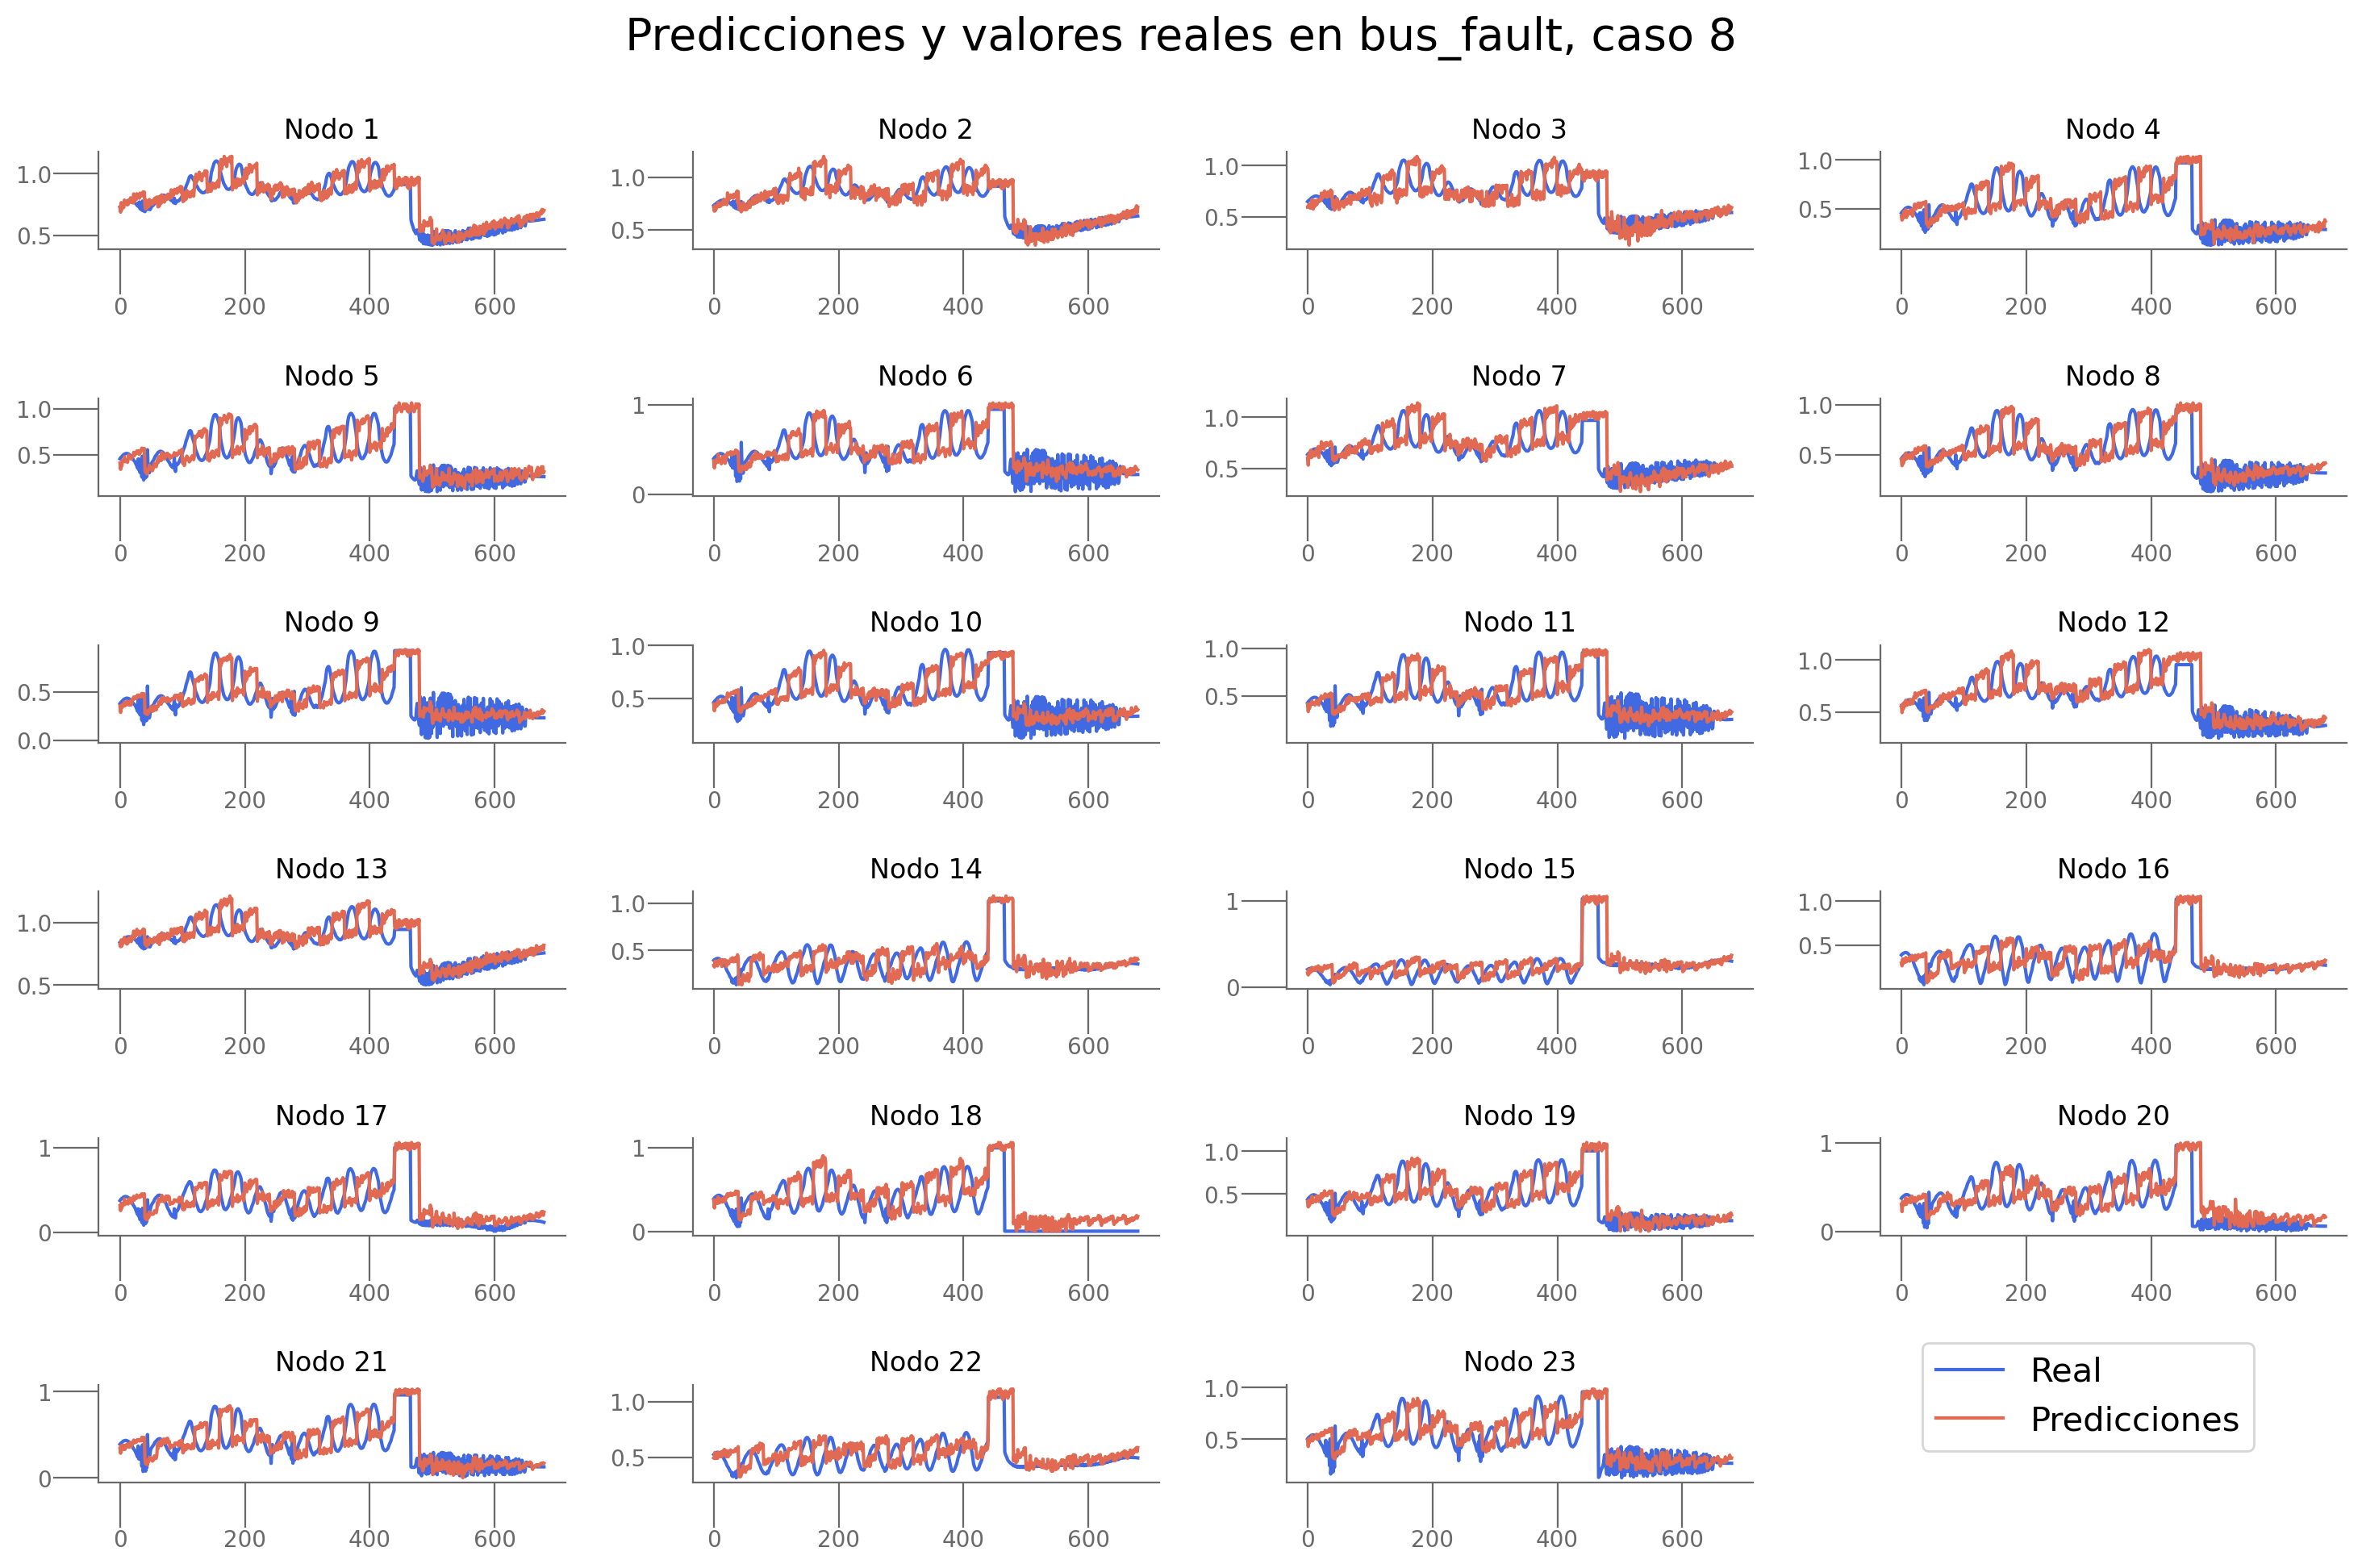

In [31]:
plot_predictions(predictions_bf_ajuste, real_bf_ajuste, n_target, 8, n_div_bf, problem_bf)

In [32]:
path_save_experiment_bf = results_save_path+f"/{problem_bf}"+ f"/ajustes/{name_model}_results.csv"
resultados_bf.to_csv(path_save_experiment_bf, index=False)

In [33]:
trainer_bf.save_model(path_save_experiment=path_save_experiment_bf, params=params_bf)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                             Params  \
0          LSTM                                                NaN   
1  LSTM_NOBATCH                                                NaN   
2     MPNN_LSTM                {'hidden_size': 64, 'dropout': 0.2}   
3   DyGrEncoder             {'aggr': 'mean', 'conv': 1, 'lstm': 1}   
4         AGCRN                              {'hidden': 5, 'K': 2}   
5         DCRNN                                     {'hidden': 40}   
6        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   

                      Fichero_resultados_experimento  Loss_tst    R2_tst  \
0                                                NaN  0.017298  0.603716   
1                                                NaN  0.017459 -1.122112   
2   ./results/bus_fault/ajustes/MPNNLSTM_results.csv  0.016746 -0.682421   
3  ./results/bus_fault/ajustes/DryGrEncoder_resul...  0.016410 -0.66477

### Branch Fault

In [34]:
problem_brf = "branch_fault"
dataset_brf, situations_brf = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_brf)


Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  92


In [35]:
n_div_brf = loader.div
n_nodes =dataset_brf.features[0].shape[0]
n_target = dataset_brf.targets[0].shape[1]
n_features = dataset_brf[0].x.shape[1]
hidden_size =32
dropout = 0.5

num_early_stop = 0
num_epochs = 30
lr = 0.01

#### Sencilla 

In [31]:

device =  torch.device("cpu")
model_brf = MSTGCNModel(name="MSTGCN", node_features=n_features, node_count=n_nodes, n_target=n_target, nb_block=2, k=2, nb_chev_filter = 2, nb_time_filter =2, time_strides = 2)


trainer_brf = TrainerMSTGCN(model_brf, dataset_brf,device, f"./results/{problem_brf}", dataloader_params2)


losses,eval_losses, r2scores  = trainer_brf.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)





==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469
AQuissss

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1875 | Eval Loss: 0.2232 | Eval R2: -25.0679 | LR: 0.0010 | 
Epoch 2/30 | Train Loss: 0.1601 | Eval Loss: 0.2219 | Eval R2: -24.9007 | LR: 0.0010 | 
Epoch 3/30 | Train Loss: 0.1598 | Eval Loss: 0.2219 | Eval R2: -24.9417 | LR: 0.0010 | 
Epoch 4/30 | Train Loss: 0.1598 | Eval Loss: 0.2220 | Eval R2: -24.9639 | LR: 0.0010 | 
Epoch 5/30 | Train Loss: 0.1598 | Eval Loss: 0.2220 | Eval R2: -24.9752 | LR: 0.0010 | 
Epoch 6/30 | Train Loss: 0.1599 | Eval Loss: 0.2222 | Eval R2: -24.9865 | LR: 0.0010 | 
Epoch 7/30 | Train Loss: 0.1598 | Eval Loss: 0.2221 | Eval R2: -24.9924 | LR: 0.0010 | 
Epoch 8/30 | Train Loss: 0.1598 | Eval Loss: 0.2221 | Eval R2: -24.9885 | LR: 0.0010 | 
Epoch 9/30 | Train Loss: 0.1597 | Eval Loss: 0.2220 | Eval R2: -24.9850 | LR: 0.0010 | 
Epoch 10/30 | Train Loss: 0

In [32]:
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_brf, real_brf = trainer_brf.test()


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.110374, test r2score -15.082346


In [33]:
plot_predictions(predictions_brf, real_brf, n_target, 7, n_div_brf, problem_brf)

#### Ajuste de parámetros 

In [36]:


num_epochs = 100
num_early_stop = 10

trainer_brf,params_brf,resultados_final_brf, resultados_brf = entrenar_y_evaluar_modelos_mstgcn(param_grid, dataset_brf, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_brf)

  0%|          | 0/54 [00:00<?, ?it/s]

Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=50

==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 0.5872 | Eval Loss: 0.3912 | Eval R2: -33.8658 | LR: 0.0010 | 
Epoch 2/100 | Train Loss: 0.2780 | Eval Loss: 0.2914 | Eval R2: -30.7783 | LR: 0.0010 | 
Epoch 3/100 | Train Loss: 0.2160 | Eval Loss: 0.2623 | Eval R2: -28.8603 | LR: 0.0010 | 
Epoch 4/100 | Train Loss: 0.1962 | Eval Loss: 0.2448 | Eval R2: -26.5000 | LR: 0.0010 | 
Epoch 5/100 | Train Loss: 0.1831 | Eval Loss: 0.2312 | Eval R2: -25.3074 | LR: 0.0010 | 
Epoch 6/100 | Train Loss: 0.1720 | Eval Loss: 0.2198 | Eval R2: -24.0055 | LR: 0.0010 | 
Epoch 7/100 | Train Loss: 0.1627 | Eval Loss: 0.2090 | Eval R2: -22.8083 | LR: 0.0010 | 
Epoch 8/100 | Train Loss: 0.1544 | Eval Loss: 0.2032 | Eval R2: -22.1448 | LR: 0.0010 | 
Epoch 9/100 | Train 

  2%|▏         | 1/54 [07:05<6:16:15, 425.94s/it]

preds:  (1, 23, 20)
test loss: 0.077254, test R2 score: -9.988741
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.09181425720453262, 'r2_eval_final': -12.366747856140137, 'loss_eval_final': 0.11332421749830246, 'r2_test': -9.988741262829977, 'loss_test': 0.07725420594215393, 'loss_nodes': [0.11129644513130188, 0.11129644513130188, 0.07889536023139954, 0.0865292102098465, 0.09643268585205078, 0.08135531097650528, 0.07518964260816574, 0.058917369693517685, 0.07108116894960403, 0.06381498277187347, 0.061214324086904526, 0.04169304668903351, 0.08721638470888138, 0.05450903996825218, 0.0700676366686821, 0.0697871521115303, 0.07829108834266663, 0.10120898485183716, 0.08322542905807495, 0.09381582587957382, 0.07443898916244507, 0.08188226819038391, 0.0446881428360939]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=80

==================== DATASET INFO ============

  4%|▎         | 2/54 [13:40<5:53:06, 407.43s/it]

preds:  (1, 23, 20)
test loss: 0.077142, test R2 score: -10.065028
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.09167978912591934, 'r2_eval_final': -12.403096199035645, 'loss_eval_final': 0.11324189603328705, 'r2_test': -10.06502837681007, 'loss_test': 0.07714241743087769, 'loss_nodes': [0.11106964200735092, 0.11106964200735092, 0.07866884022951126, 0.0865553542971611, 0.09560173004865646, 0.08130308240652084, 0.07529273629188538, 0.05897224321961403, 0.07132261991500854, 0.06375357508659363, 0.06116420775651932, 0.04155929759144783, 0.08655285090208054, 0.05372866615653038, 0.0698125958442688, 0.06957024335861206, 0.07841544598340988, 0.10152611136436462, 0.08303534239530563, 0.09390286356210709, 0.07444316893815994, 0.08234420418739319, 0.04461078718304634]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=100

==================== DATASET INFO ==========

  6%|▌         | 3/54 [21:35<6:12:27, 438.18s/it]

preds:  (1, 23, 20)
test loss: 0.076557, test R2 score: -9.888257
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.0915277749300003, 'r2_eval_final': -12.172999382019043, 'loss_eval_final': 0.11206377297639847, 'r2_test': -9.888257040187728, 'loss_test': 0.07655666023492813, 'loss_nodes': [0.11062373220920563, 0.11062373220920563, 0.07841666787862778, 0.08731462806463242, 0.09506604820489883, 0.08199262619018555, 0.07666108012199402, 0.05898776277899742, 0.07140181213617325, 0.06354641169309616, 0.06075366586446762, 0.04117010906338692, 0.07836544513702393, 0.05359232425689697, 0.06931889057159424, 0.06914637982845306, 0.07850849628448486, 0.10150055587291718, 0.08245730400085449, 0.09389910101890564, 0.0743570402264595, 0.07883195579051971, 0.04426773637533188]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=50

==================== DATASET INFO ===========

  7%|▋         | 4/54 [28:25<5:55:52, 427.04s/it]

preds:  (1, 23, 20)
test loss: 0.175774, test R2 score: -23.887393
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.22131581604480743, 'r2_eval_final': -32.17741012573242, 'loss_eval_final': 0.28854140639305115, 'r2_test': -23.887392753537135, 'loss_test': 0.1757742166519165, 'loss_nodes': [0.22082126140594482, 0.22082126140594482, 0.18406660854816437, 0.16373006999492645, 0.17908325791358948, 0.15937624871730804, 0.1786544770002365, 0.15678265690803528, 0.1636262834072113, 0.1544896364212036, 0.15751974284648895, 0.14728134870529175, 0.24635231494903564, 0.17375925183296204, 0.16450729966163635, 0.16374556720256805, 0.17260418832302094, 0.18202424049377441, 0.17682434618473053, 0.17614738643169403, 0.16051632165908813, 0.21438847482204437, 0.12568488717079163]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=80

==================== DATASET INFO =============

  9%|▉         | 5/54 [35:01<5:39:51, 416.15s/it]

preds:  (1, 23, 20)
test loss: 0.175774, test R2 score: -23.887393
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.22131581604480743, 'r2_eval_final': -32.17741012573242, 'loss_eval_final': 0.28854140639305115, 'r2_test': -23.887392866465607, 'loss_test': 0.1757742166519165, 'loss_nodes': [0.22082123160362244, 0.22082123160362244, 0.18406660854816437, 0.16373006999492645, 0.17908324301242828, 0.15937624871730804, 0.1786544770002365, 0.15678265690803528, 0.1636263132095337, 0.154489666223526, 0.15751974284648895, 0.14728136360645294, 0.24635232985019684, 0.17375925183296204, 0.16450729966163635, 0.16374556720256805, 0.17260420322418213, 0.18202424049377441, 0.17682434618473053, 0.17614738643169403, 0.16051632165908813, 0.21438847482204437, 0.12568488717079163]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=100

==================== DATASET INFO =============

 11%|█         | 6/54 [41:49<5:30:37, 413.28s/it]

preds:  (1, 23, 20)
test loss: 0.175774, test R2 score: -23.887393
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.22131581604480743, 'r2_eval_final': -32.17741012573242, 'loss_eval_final': 0.28854140639305115, 'r2_test': -23.887392691547845, 'loss_test': 0.1757742166519165, 'loss_nodes': [0.22082123160362244, 0.22082123160362244, 0.18406662344932556, 0.16373006999492645, 0.17908325791358948, 0.15937624871730804, 0.17865446209907532, 0.15678265690803528, 0.1636263132095337, 0.154489666223526, 0.15751974284648895, 0.14728136360645294, 0.24635232985019684, 0.17375925183296204, 0.16450731456279755, 0.16374558210372925, 0.17260417342185974, 0.18202424049377441, 0.17682434618473053, 0.17614738643169403, 0.16051632165908813, 0.21438847482204437, 0.12568488717079163]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=50

==================== DATASET INFO ===========

 13%|█▎        | 7/54 [54:46<6:56:54, 532.22s/it]

preds:  (1, 23, 20)
test loss: 0.112148, test R2 score: -14.276579
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.14829455316066742, 'r2_eval_final': -21.47065544128418, 'loss_eval_final': 0.20072264969348907, 'r2_test': -14.276579197003109, 'loss_test': 0.11214807629585266, 'loss_nodes': [0.10244864225387573, 0.10244864225387573, 0.09691166132688522, 0.12621913850307465, 0.14349842071533203, 0.12303747236728668, 0.09998369216918945, 0.11552448570728302, 0.13463199138641357, 0.11485084891319275, 0.11633958667516708, 0.07312995195388794, 0.10948269814252853, 0.07911123335361481, 0.08338548988103867, 0.08413376659154892, 0.1345195174217224, 0.15035904943943024, 0.1434677243232727, 0.1503559947013855, 0.129717156291008, 0.09060954302549362, 0.07523877173662186]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=80

==================== DATASET INFO ============

 15%|█▍        | 8/54 [1:10:56<8:34:46, 671.45s/it]

preds:  (1, 23, 20)
test loss: 0.112148, test R2 score: -14.276579
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.14829455316066742, 'r2_eval_final': -21.470653533935547, 'loss_eval_final': 0.20072266459465027, 'r2_test': -14.276579164363271, 'loss_test': 0.11214808374643326, 'loss_nodes': [0.10244864225387573, 0.10244864225387573, 0.09691166877746582, 0.12621913850307465, 0.14349843561649323, 0.12303747981786728, 0.09998369216918945, 0.11552448570728302, 0.13463200628757477, 0.11485084891319275, 0.11633958667516708, 0.07312995940446854, 0.10948270559310913, 0.07911122590303421, 0.08338548988103867, 0.08413376659154892, 0.1345195174217224, 0.15035904943943024, 0.1434677392244339, 0.1503559947013855, 0.1297171711921692, 0.09060952812433243, 0.07523877918720245]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=100

==================== DATASET INFO =========

 17%|█▋        | 9/54 [1:16:23<7:02:58, 563.97s/it]

preds:  (1, 23, 20)
test loss: 0.112148, test R2 score: -14.276579
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.14829455316066742, 'r2_eval_final': -21.470653533935547, 'loss_eval_final': 0.20072266459465027, 'r2_test': -14.276579028170408, 'loss_test': 0.11214808374643326, 'loss_nodes': [0.10244863480329514, 0.10244863480329514, 0.09691167622804642, 0.12621913850307465, 0.14349842071533203, 0.12303747981786728, 0.09998370707035065, 0.11552448570728302, 0.13463200628757477, 0.11485084891319275, 0.11633959412574768, 0.07312995940446854, 0.10948269814252853, 0.07911122590303421, 0.08338548988103867, 0.08413376659154892, 0.1345195174217224, 0.15035904943943024, 0.1434677392244339, 0.1503559947013855, 0.1297171711921692, 0.09060952812433243, 0.07523877173662186]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=50

==================== DATASET INFO ==========

 19%|█▊        | 10/54 [1:22:29<6:08:41, 502.76s/it]

preds:  (1, 23, 20)
test loss: 0.092562, test R2 score: -10.961389
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.11072760075330734, 'r2_eval_final': -15.294081687927246, 'loss_eval_final': 0.13973329961299896, 'r2_test': -10.96138931765091, 'loss_test': 0.09256157279014587, 'loss_nodes': [0.12302754819393158, 0.12302754819393158, 0.09990540146827698, 0.07699939608573914, 0.08051172643899918, 0.08151115477085114, 0.0987323746085167, 0.07682962715625763, 0.07620050758123398, 0.07481005787849426, 0.08299393951892853, 0.08982346206903458, 0.13838855922222137, 0.10949321836233139, 0.1001719981431961, 0.09908763319253922, 0.08067847788333893, 0.07987546920776367, 0.07944273203611374, 0.07579004764556885, 0.07618901133537292, 0.13041366636753082, 0.07501272112131119]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=80

==================== DATASET INFO ===========

 20%|██        | 11/54 [1:28:59<5:35:27, 468.09s/it]

preds:  (1, 23, 20)
test loss: 0.092562, test R2 score: -10.961393
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.11072757095098495, 'r2_eval_final': -15.294084548950195, 'loss_eval_final': 0.13973329961299896, 'r2_test': -10.961393177922684, 'loss_test': 0.09256158024072647, 'loss_nodes': [0.12302757054567337, 0.12302757054567337, 0.09990540891885757, 0.07699917256832123, 0.08051169663667679, 0.0815110057592392, 0.09873224794864655, 0.0768297016620636, 0.07620052248239517, 0.07481005042791367, 0.08299390971660614, 0.08982345461845398, 0.13838860392570496, 0.10949327051639557, 0.1001720130443573, 0.09908762574195862, 0.08067860454320908, 0.07987546920776367, 0.07944274693727493, 0.07579004019498825, 0.07618904858827591, 0.13041378557682037, 0.07501273602247238]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=100

==================== DATASET INFO ==========

 22%|██▏       | 12/54 [1:35:50<5:15:38, 450.91s/it]

preds:  (1, 23, 20)
test loss: 0.092562, test R2 score: -10.961394
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.11072766780853271, 'r2_eval_final': -15.294090270996094, 'loss_eval_final': 0.13973338901996613, 'r2_test': -10.961393504565343, 'loss_test': 0.09256161749362946, 'loss_nodes': [0.12302747368812561, 0.12302747368812561, 0.09990543872117996, 0.07699915021657944, 0.08051170408725739, 0.08151103556156158, 0.09873224049806595, 0.07682979106903076, 0.07620060443878174, 0.07481011003255844, 0.08299394696950912, 0.08982352912425995, 0.13838867843151093, 0.10949340462684631, 0.1001720279455185, 0.099087655544281, 0.08067862689495087, 0.07987555116415024, 0.0794428214430809, 0.07579010725021362, 0.07618910819292068, 0.13041383028030396, 0.07501280307769775]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=50

==================== DATASET INFO ===========

 24%|██▍       | 13/54 [1:41:51<4:49:31, 423.69s/it]

preds:  (1, 23, 20)
test loss: 0.150814, test R2 score: -21.657095
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.18101811408996582, 'r2_eval_final': -25.553316116333008, 'loss_eval_final': 0.2261536568403244, 'r2_test': -21.657095276451393, 'loss_test': 0.15081427991390228, 'loss_nodes': [0.20955894887447357, 0.20955894887447357, 0.16970396041870117, 0.12203264236450195, 0.12956088781356812, 0.1258632391691208, 0.16372913122177124, 0.12351315468549728, 0.11922510713338852, 0.1213628500699997, 0.12933272123336792, 0.1487947255373001, 0.23710794746875763, 0.17904822528362274, 0.16263388097286224, 0.16092777252197266, 0.12794308364391327, 0.12701968848705292, 0.12580350041389465, 0.12057846784591675, 0.11839622259140015, 0.21713866293430328, 0.11989462375640869]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=80

==================== DATASET INFO ============

 26%|██▌       | 14/54 [1:47:35<4:26:16, 399.42s/it]

preds:  (1, 23, 20)
test loss: 0.150814, test R2 score: -21.657097
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.1810181736946106, 'r2_eval_final': -25.55331802368164, 'loss_eval_final': 0.22615371644496918, 'r2_test': -21.657097469712756, 'loss_test': 0.15081430971622467, 'loss_nodes': [0.20955906808376312, 0.20955906808376312, 0.16970399022102356, 0.12203257530927658, 0.12956109642982483, 0.1258632093667984, 0.16372919082641602, 0.12351314723491669, 0.11922508478164673, 0.12136291712522507, 0.12933260202407837, 0.1487947404384613, 0.23710796236991882, 0.17904852330684662, 0.1626339554786682, 0.16092784702777863, 0.12794311344623566, 0.1270199865102768, 0.1258034110069275, 0.12057856470346451, 0.11839614808559418, 0.2171386480331421, 0.11989465355873108]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=100

==================== DATASET INFO ===============

 28%|██▊       | 15/54 [1:52:56<4:04:22, 375.96s/it]

preds:  (1, 23, 20)
test loss: 0.150814, test R2 score: -21.657098
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.18101811408996582, 'r2_eval_final': -25.55331802368164, 'loss_eval_final': 0.22615370154380798, 'r2_test': -21.657097808543607, 'loss_test': 0.15081429481506348, 'loss_nodes': [0.20955894887447357, 0.20955894887447357, 0.16970396041870117, 0.12203270196914673, 0.1295609176158905, 0.12586325407028198, 0.16372919082641602, 0.1235131248831749, 0.11922506988048553, 0.1213628500699997, 0.12933269143104553, 0.1487947404384613, 0.23710794746875763, 0.1790483593940735, 0.16263389587402344, 0.16092774271965027, 0.12794305384159088, 0.12701977789402008, 0.12580347061157227, 0.12057849019765854, 0.11839617043733597, 0.2171386331319809, 0.11989465355873108]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=50

==================== DATASET INFO =============

 30%|██▉       | 16/54 [1:58:23<3:48:47, 361.25s/it]

preds:  (1, 23, 20)
test loss: 0.030548, test R2 score: -2.610135
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.03351158648729324, 'r2_eval_final': -4.250768184661865, 'loss_eval_final': 0.042132668197155, 'r2_test': -2.6101353647047874, 'loss_test': 0.03054814040660858, 'loss_nodes': [0.012565870769321918, 0.012565870769321918, 0.018170902505517006, 0.03417368605732918, 0.03869291767477989, 0.04213438183069229, 0.024949006736278534, 0.03327564150094986, 0.040979139506816864, 0.03299243003129959, 0.03920659050345421, 0.02487894892692566, 0.012715058401226997, 0.028620535507798195, 0.02918468415737152, 0.029179269447922707, 0.03768919035792351, 0.04031132534146309, 0.037739261984825134, 0.04230108484625816, 0.03939362242817879, 0.020030289888381958, 0.030857380479574203]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=80

==================== DATASET INFO

 31%|███▏      | 17/54 [2:03:53<3:36:50, 351.63s/it]

preds:  (1, 23, 20)
test loss: 0.030547, test R2 score: -2.610032
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.033511992543935776, 'r2_eval_final': -4.250727653503418, 'loss_eval_final': 0.04213223233819008, 'r2_test': -2.610031785359175, 'loss_test': 0.030547278001904488, 'loss_nodes': [0.01256452314555645, 0.01256452314555645, 0.018170125782489777, 0.03417440876364708, 0.038691818714141846, 0.042135175317525864, 0.024948734790086746, 0.033274535089731216, 0.04097956418991089, 0.032992757856845856, 0.039205703884363174, 0.02487795241177082, 0.012712902389466763, 0.028620276600122452, 0.029183249920606613, 0.02917839027941227, 0.0376860685646534, 0.04031152278184891, 0.037734951823949814, 0.04230150207877159, 0.0393933467566967, 0.020027851685881615, 0.03085745871067047]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=100

==================== DATASET I

 33%|███▎      | 18/54 [2:09:04<3:23:41, 339.48s/it]

preds:  (1, 23, 20)
test loss: 0.030548, test R2 score: -2.610095
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.03351154550909996, 'r2_eval_final': -4.250712871551514, 'loss_eval_final': 0.04213249310851097, 'r2_test': -2.610095002767711, 'loss_test': 0.030548157170414925, 'loss_nodes': [0.01256559882313013, 0.01256559882313013, 0.018170854076743126, 0.0341741181910038, 0.038692791014909744, 0.042134858667850494, 0.02494918927550316, 0.03327563777565956, 0.04097934067249298, 0.0329926460981369, 0.03920666128396988, 0.024878963828086853, 0.01271437294781208, 0.028620928525924683, 0.029184646904468536, 0.029179349541664124, 0.037688933312892914, 0.04031158611178398, 0.03773893043398857, 0.042301349341869354, 0.03939371556043625, 0.02002980373799801, 0.030857637524604797]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=50

==================== DATASET INFO 

 35%|███▌      | 19/54 [2:16:10<3:33:13, 365.53s/it]

preds:  (1, 23, 20)
test loss: 0.056449, test R2 score: -6.041388
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.06538499146699905, 'r2_eval_final': -9.106240272521973, 'loss_eval_final': 0.08366566151380539, 'r2_test': -6.041387943077117, 'loss_test': 0.05644945427775383, 'loss_nodes': [0.0641205683350563, 0.0641205683350563, 0.054839275777339935, 0.0485571064054966, 0.052115775644779205, 0.05369304493069649, 0.056210100650787354, 0.049060482531785965, 0.05154179409146309, 0.048148225992918015, 0.055014822632074356, 0.052556946873664856, 0.07234865427017212, 0.06693479418754578, 0.06230578571557999, 0.06178995221853256, 0.053117044270038605, 0.053547874093055725, 0.052428003400564194, 0.051946304738521576, 0.05164273828268051, 0.07364775985479355, 0.04864981025457382]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=80

==================== DATASET INFO ===

 37%|███▋      | 20/54 [2:23:04<3:35:18, 379.94s/it]

preds:  (1, 23, 20)
test loss: 0.056449, test R2 score: -6.041371
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.06538479775190353, 'r2_eval_final': -9.106212615966797, 'loss_eval_final': 0.08366530388593674, 'r2_test': -6.04137086868392, 'loss_test': 0.05644923821091652, 'loss_nodes': [0.06412047892808914, 0.06412047892808914, 0.05483924224972725, 0.04855702444911003, 0.05211568996310234, 0.05369298532605171, 0.05621008574962616, 0.049060020595788956, 0.05154132470488548, 0.048148203641176224, 0.05501438304781914, 0.052556414157152176, 0.07234838604927063, 0.06693477183580399, 0.06230585277080536, 0.06179005280137062, 0.05311638116836548, 0.05354790762066841, 0.05242757126688957, 0.051946211606264114, 0.05164242908358574, 0.07364725321531296, 0.04864924028515816]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=100

==================== DATASET INFO =======

 39%|███▉      | 21/54 [2:29:46<3:32:35, 386.54s/it]

preds:  (1, 23, 20)
test loss: 0.056449, test R2 score: -6.041378
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.06538479030132294, 'r2_eval_final': -9.106219291687012, 'loss_eval_final': 0.08366530388593674, 'r2_test': -6.04137840789785, 'loss_test': 0.05644931271672249, 'loss_nodes': [0.0641205832362175, 0.0641205832362175, 0.05483929440379143, 0.048557206988334656, 0.05211566761136055, 0.05369314178824425, 0.05621020495891571, 0.04906003922224045, 0.051541347056627274, 0.04814816638827324, 0.05501473695039749, 0.052556511014699936, 0.07234849780797958, 0.06693466752767563, 0.06230589374899864, 0.06179008260369301, 0.05311625450849533, 0.053547874093055725, 0.052427589893341064, 0.051946233958005905, 0.05164273828268051, 0.07364732027053833, 0.04864956811070442]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=50

==================== DATASET INFO =======

 41%|████      | 22/54 [2:35:47<3:22:12, 379.13s/it]

preds:  (1, 23, 20)
test loss: 0.027849, test R2 score: -2.393000
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.02887764759361744, 'r2_eval_final': -4.03610372543335, 'loss_eval_final': 0.037381500005722046, 'r2_test': -2.3930003307827006, 'loss_test': 0.027848871424794197, 'loss_nodes': [0.010004669427871704, 0.010004669427871704, 0.014874282293021679, 0.02936248481273651, 0.034455519169569016, 0.03679569810628891, 0.021190201863646507, 0.029829321429133415, 0.03665781393647194, 0.029153455048799515, 0.037119071930646896, 0.022886542603373528, 0.010703584179282188, 0.027649013325572014, 0.028899196535348892, 0.028849266469478607, 0.03469149395823479, 0.03679770976305008, 0.03526962921023369, 0.03810417279601097, 0.03725838661193848, 0.02038915827870369, 0.029578791931271553]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=80

==================== DATASET 

 43%|████▎     | 23/54 [2:41:38<3:11:25, 370.49s/it]

preds:  (1, 23, 20)
test loss: 0.027849, test R2 score: -2.393010
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.02887766994535923, 'r2_eval_final': -4.0361199378967285, 'loss_eval_final': 0.037381548434495926, 'r2_test': -2.3930104684432174, 'loss_test': 0.02784891612827778, 'loss_nodes': [0.010004629381000996, 0.010004629381000996, 0.014874338172376156, 0.029362497851252556, 0.03445546329021454, 0.03679574280977249, 0.02119026705622673, 0.029829399660229683, 0.03665783628821373, 0.02915354259312153, 0.03711917996406555, 0.02288665436208248, 0.010703629814088345, 0.027649104595184326, 0.028899310156702995, 0.028849387541413307, 0.03469153866171837, 0.03679763153195381, 0.03526968136429787, 0.03810415789484978, 0.03725838661193848, 0.020389260724186897, 0.029578881338238716]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=100

==================== DATASET I

 44%|████▍     | 24/54 [2:47:27<3:02:00, 364.02s/it]

preds:  (1, 23, 20)
test loss: 0.027849, test R2 score: -2.393007
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.028877634555101395, 'r2_eval_final': -4.036105632781982, 'loss_eval_final': 0.037381481379270554, 'r2_test': -2.3930067797798538, 'loss_test': 0.0278488676995039, 'loss_nodes': [0.010004568845033646, 0.010004568845033646, 0.01487426832318306, 0.029362419620156288, 0.034455496817827225, 0.03679567202925682, 0.021190118044614792, 0.02982940338551998, 0.03665783256292343, 0.02915351651608944, 0.03711912781000137, 0.022886566817760468, 0.01070353388786316, 0.02764907479286194, 0.02889920584857464, 0.028849270194768906, 0.034691497683525085, 0.03679762780666351, 0.035269662737846375, 0.038104187697172165, 0.03725842386484146, 0.020389171317219734, 0.029578832909464836]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=50

==================== DATASET 

 46%|████▋     | 25/54 [2:53:01<2:51:41, 355.21s/it]

preds:  (1, 23, 20)
test loss: 0.030208, test R2 score: -2.597751
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.032859835773706436, 'r2_eval_final': -4.41978645324707, 'loss_eval_final': 0.04221314191818237, 'r2_test': -2.597750898608146, 'loss_test': 0.030207742005586624, 'loss_nodes': [0.011544611304998398, 0.011544611304998398, 0.017397191375494003, 0.03441283106803894, 0.03802863880991936, 0.04266165569424629, 0.02485762909054756, 0.031706392765045166, 0.0389968566596508, 0.031128138303756714, 0.03936772793531418, 0.024254824966192245, 0.013784444890916348, 0.029359178617596626, 0.02905459702014923, 0.028980188071727753, 0.03661884367465973, 0.03915267065167427, 0.03802170231938362, 0.04036436975002289, 0.04020514339208603, 0.021694736555218697, 0.031641069799661636]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=80

==================== DATASET INF

 48%|████▊     | 26/54 [2:58:37<2:42:59, 349.25s/it]

preds:  (1, 23, 20)
test loss: 0.030208, test R2 score: -2.597760
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.03285983204841614, 'r2_eval_final': -4.41977071762085, 'loss_eval_final': 0.0422130711376667, 'r2_test': -2.597760143879651, 'loss_test': 0.030207805335521698, 'loss_nodes': [0.011544655077159405, 0.011544655077159405, 0.017397260293364525, 0.03441299870610237, 0.03802880272269249, 0.04266174137592316, 0.024857765063643456, 0.03170641139149666, 0.038996826857328415, 0.03112822026014328, 0.039367761462926865, 0.02425495535135269, 0.013784310780465603, 0.02935943566262722, 0.029054764658212662, 0.02898034080862999, 0.0366189107298851, 0.03915272280573845, 0.03802166506648064, 0.04036441072821617, 0.04020509123802185, 0.021694669499993324, 0.031641121953725815]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=100

==================== DATASET INFO 

 50%|█████     | 27/54 [3:04:01<2:33:49, 341.82s/it]

preds:  (1, 23, 20)
test loss: 0.030208, test R2 score: -2.597743
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.03285979852080345, 'r2_eval_final': -4.419745445251465, 'loss_eval_final': 0.04221302270889282, 'r2_test': -2.597742635026429, 'loss_test': 0.030207818374037743, 'loss_nodes': [0.011544633656740189, 0.011544633656740189, 0.017397109419107437, 0.03441235050559044, 0.038028862327337265, 0.04266110435128212, 0.02485719509422779, 0.031706806272268295, 0.03899712115526199, 0.03112812153995037, 0.0393681526184082, 0.024255022406578064, 0.013784329406917095, 0.02935880981385708, 0.0290545541793108, 0.02898014895617962, 0.036619458347558975, 0.03915301710367203, 0.038022302091121674, 0.04036427289247513, 0.040205612778663635, 0.021694766357541084, 0.03164135664701462]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=50

==================== DATASET INFO

 52%|█████▏    | 28/54 [3:15:23<3:12:16, 443.69s/it]

preds:  (1, 23, 20)
test loss: 0.124033, test R2 score: -16.656042
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.16292524337768555, 'r2_eval_final': -23.73604393005371, 'loss_eval_final': 0.21800804138183594, 'r2_test': -16.65604235965199, 'loss_test': 0.12403266131877899, 'loss_nodes': [0.12653681635856628, 0.1265368014574051, 0.1142822653055191, 0.13238921761512756, 0.14914005994796753, 0.12872986495494843, 0.11547378450632095, 0.12255484610795975, 0.13890796899795532, 0.12143076211214066, 0.12304850667715073, 0.08860684931278229, 0.13760393857955933, 0.09772685915231705, 0.09902574867010117, 0.099423848092556, 0.14064399898052216, 0.1550160050392151, 0.14855903387069702, 0.1536284238100052, 0.13409040868282318, 0.1156080886721611, 0.08378692716360092]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=80

==================== DATASET INFO =================

 54%|█████▎    | 29/54 [3:27:07<3:37:26, 521.87s/it]

preds:  (1, 23, 20)
test loss: 0.124033, test R2 score: -16.656109
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.16292379796504974, 'r2_eval_final': -23.736087799072266, 'loss_eval_final': 0.21800829470157623, 'r2_test': -16.656109157692583, 'loss_test': 0.12403307855129242, 'loss_nodes': [0.1265367865562439, 0.1265367716550827, 0.11428225785493851, 0.13238920271396637, 0.14914008975028992, 0.12872986495494843, 0.11547373235225677, 0.12255486100912094, 0.13890792429447174, 0.12143074721097946, 0.12304849922657013, 0.0886089950799942, 0.13760387897491455, 0.09773380309343338, 0.09902623295783997, 0.09942381083965302, 0.14064396917819977, 0.15501606464385986, 0.14855900406837463, 0.1536284238100052, 0.13409040868282318, 0.11560802161693573, 0.08378692716360092]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=100

==================== DATASET INFO ===========

 56%|█████▌    | 30/54 [3:38:49<3:50:20, 575.85s/it]

preds:  (1, 23, 20)
test loss: 0.123692, test R2 score: -16.640991
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.1626768857240677, 'r2_eval_final': -23.72597885131836, 'loss_eval_final': 0.2177724689245224, 'r2_test': -16.640991056011515, 'loss_test': 0.12369249761104584, 'loss_nodes': [0.12667575478553772, 0.12667995691299438, 0.11432956159114838, 0.13227711617946625, 0.14902111887931824, 0.12861371040344238, 0.11549177020788193, 0.12245415151119232, 0.13876838982105255, 0.12132606655359268, 0.12294774502515793, 0.0862622782588005, 0.13304013013839722, 0.09779015183448792, 0.0990476906299591, 0.09944108128547668, 0.1405317336320877, 0.15488369762897491, 0.14843431115150452, 0.1534777283668518, 0.13395565748214722, 0.1157636046409607, 0.08371397107839584]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=50

==================== DATASET INFO ===============

 57%|█████▋    | 31/54 [3:49:16<3:46:40, 591.32s/it]

preds:  (1, 23, 20)
test loss: 0.136949, test R2 score: -17.762211
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.17779453098773956, 'r2_eval_final': -25.64008140563965, 'loss_eval_final': 0.23619344830513, 'r2_test': -17.762211255915073, 'loss_test': 0.13694940507411957, 'loss_nodes': [0.14984776079654694, 0.14984776079654694, 0.13173672556877136, 0.1403903067111969, 0.15685874223709106, 0.1372494399547577, 0.1307852864265442, 0.13112154603004456, 0.14529815316200256, 0.13045567274093628, 0.1327846497297287, 0.10277482867240906, 0.16406308114528656, 0.1157628670334816, 0.11455823481082916, 0.11470672488212585, 0.14851373434066772, 0.16175836324691772, 0.15584291517734528, 0.1596916764974594, 0.14130423963069916, 0.13916760683059692, 0.09531588852405548]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=80

==================== DATASET INFO ==================

 59%|█████▉    | 32/54 [3:59:59<3:42:27, 606.73s/it]

preds:  (1, 23, 20)
test loss: 0.124573, test R2 score: -15.952202
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.1632068008184433, 'r2_eval_final': -23.606168746948242, 'loss_eval_final': 0.21893228590488434, 'r2_test': -15.952202303529372, 'loss_test': 0.12457316368818283, 'loss_nodes': [0.12639623880386353, 0.12639623880386353, 0.11444036662578583, 0.13320240378379822, 0.15008725225925446, 0.13015975058078766, 0.11547479778528214, 0.12322929501533508, 0.1398799568414688, 0.12263504415750504, 0.12461071461439133, 0.08812939375638962, 0.13707217574119568, 0.09747526794672012, 0.09896774590015411, 0.09941142797470093, 0.1414290964603424, 0.15594735741615295, 0.1495521366596222, 0.15491847693920135, 0.13545216619968414, 0.11506770551204681, 0.08524774760007858]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=100

==================== DATASET INFO ===========

 61%|██████    | 33/54 [4:10:17<3:33:34, 610.23s/it]

preds:  (1, 23, 20)
test loss: 0.136950, test R2 score: -17.762062
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.17779511213302612, 'r2_eval_final': -25.639673233032227, 'loss_eval_final': 0.23618341982364655, 'r2_test': -17.762062206831438, 'loss_test': 0.13694976270198822, 'loss_nodes': [0.14984659850597382, 0.14984659850597382, 0.13173629343509674, 0.14039137959480286, 0.15685991942882538, 0.1372506022453308, 0.13078515231609344, 0.13112257421016693, 0.1452995091676712, 0.1304565817117691, 0.13278581202030182, 0.10277488827705383, 0.1640612930059433, 0.11576236039400101, 0.11455801874399185, 0.11470666527748108, 0.14851480722427368, 0.16175955533981323, 0.1558442860841751, 0.15969306230545044, 0.14130555093288422, 0.1391662061214447, 0.09531671553850174]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=50

==================== DATASET INFO ============

 63%|██████▎   | 34/54 [4:19:55<3:20:11, 600.59s/it]

preds:  (1, 23, 20)
test loss: 0.150113, test R2 score: -19.346608
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.19218969345092773, 'r2_eval_final': -27.399124145507812, 'loss_eval_final': 0.2536638081073761, 'r2_test': -19.346607819802905, 'loss_test': 0.15011349320411682, 'loss_nodes': [0.17308877408504486, 0.17308877408504486, 0.14896899461746216, 0.14869491755962372, 0.16487745940685272, 0.14484257996082306, 0.14649012684822083, 0.14002756774425507, 0.1516636610031128, 0.13870501518249512, 0.14115402102470398, 0.11756552755832672, 0.1907968372106552, 0.13526390492916107, 0.13151288032531738, 0.13138428330421448, 0.15726087987422943, 0.1693766862154007, 0.163517564535141, 0.16606871783733368, 0.1483367383480072, 0.16408735513687134, 0.10583709180355072]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=80

==================== DATASET INFO =============

 65%|██████▍   | 35/54 [4:29:33<3:07:58, 593.63s/it]

preds:  (1, 23, 20)
test loss: 0.150114, test R2 score: -19.346609
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.19218969345092773, 'r2_eval_final': -27.399124145507812, 'loss_eval_final': 0.2536638081073761, 'r2_test': -19.34660855766932, 'loss_test': 0.1501135230064392, 'loss_nodes': [0.17308877408504486, 0.17308877408504486, 0.14896899461746216, 0.14869484305381775, 0.16487745940685272, 0.14484253525733948, 0.1464901566505432, 0.14002756774425507, 0.15166369080543518, 0.1387050300836563, 0.14115412533283234, 0.11756553500890732, 0.1907968521118164, 0.13526391983032227, 0.1315128654241562, 0.13138426840305328, 0.15726087987422943, 0.1693766564130783, 0.163517564535141, 0.1660686582326889, 0.1483367383480072, 0.16408738493919373, 0.10583706945180893]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=100

==================== DATASET INFO =================

 67%|██████▋   | 36/54 [4:39:35<2:58:52, 596.26s/it]

preds:  (1, 23, 20)
test loss: 0.150114, test R2 score: -19.346609
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.19218969345092773, 'r2_eval_final': -27.399124145507812, 'loss_eval_final': 0.2536638081073761, 'r2_test': -19.34660884266931, 'loss_test': 0.1501135230064392, 'loss_nodes': [0.17308877408504486, 0.17308877408504486, 0.14896899461746216, 0.14869482815265656, 0.16487745940685272, 0.14484253525733948, 0.1464901566505432, 0.14002756774425507, 0.15166369080543518, 0.13870501518249512, 0.14115411043167114, 0.11756553500890732, 0.1907968521118164, 0.13526393473148346, 0.1315128654241562, 0.13138426840305328, 0.15726086497306824, 0.1693766564130783, 0.163517564535141, 0.1660686582326889, 0.148336723446846, 0.1640874147415161, 0.10583706945180893]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=50

==================== DATASET INFO ===================

 69%|██████▊   | 37/54 [5:21:47<5:33:26, 1176.85s/it]

preds:  (1, 23, 20)
test loss: 0.027155, test R2 score: -2.418434
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.028752105310559273, 'r2_eval_final': -4.180761814117432, 'loss_eval_final': 0.03806929290294647, 'r2_test': -2.418433960593549, 'loss_test': 0.027155308052897453, 'loss_nodes': [0.010702529922127724, 0.01079524029046297, 0.01545684039592743, 0.027478979900479317, 0.03252577781677246, 0.036046866327524185, 0.019749367609620094, 0.028684159740805626, 0.035083264112472534, 0.02909725345671177, 0.03488771989941597, 0.02252374216914177, 0.012087985873222351, 0.02803174778819084, 0.02824101224541664, 0.028979677706956863, 0.03401000797748566, 0.037122488021850586, 0.03295721113681793, 0.0369432158768177, 0.03473595902323723, 0.019866811111569405, 0.02856416068971157]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=80

==================== DATASET INFO 

 70%|███████   | 38/54 [5:53:10<6:10:22, 1388.94s/it]

preds:  (1, 23, 20)
test loss: 0.027156, test R2 score: -2.418536
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.028751950711011887, 'r2_eval_final': -4.180828094482422, 'loss_eval_final': 0.0380694605410099, 'r2_test': -2.4185361706906394, 'loss_test': 0.027155552059412003, 'loss_nodes': [0.010703076608479023, 0.01079586986452341, 0.015456785447895527, 0.0274793803691864, 0.03252642974257469, 0.03604742884635925, 0.01974986121058464, 0.028684301301836967, 0.03508340194821358, 0.02909739874303341, 0.03488795459270477, 0.022524021565914154, 0.012087673880159855, 0.028033019974827766, 0.028240958228707314, 0.028979724273085594, 0.03400988131761551, 0.03712289407849312, 0.03295731171965599, 0.03694317862391472, 0.03473607078194618, 0.019866740331053734, 0.028564367443323135]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=100

==================== DATASET INFO

 72%|███████▏  | 39/54 [6:14:05<5:37:09, 1348.61s/it]

preds:  (1, 23, 20)
test loss: 0.027155, test R2 score: -2.418528
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.028751997277140617, 'r2_eval_final': -4.180773735046387, 'loss_eval_final': 0.038069479167461395, 'r2_test': -2.4185279308808876, 'loss_test': 0.02715533785521984, 'loss_nodes': [0.010702558793127537, 0.010795286856591702, 0.015457086265087128, 0.027478674426674843, 0.03252595290541649, 0.03604653477668762, 0.01974908448755741, 0.028684332966804504, 0.035083696246147156, 0.02909734472632408, 0.03488805890083313, 0.0225237924605608, 0.01208751555532217, 0.028031745925545692, 0.02824096567928791, 0.028979184105992317, 0.03401026502251625, 0.037122856825590134, 0.03295755013823509, 0.03694307431578636, 0.034736327826976776, 0.019866589456796646, 0.02856423333287239]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=50

==================== DATASET IN

 74%|███████▍  | 40/54 [6:34:45<5:07:05, 1316.07s/it]

preds:  (1, 23, 20)
test loss: 0.028368, test R2 score: -2.472917
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.028838666155934334, 'r2_eval_final': -4.030881881713867, 'loss_eval_final': 0.03737741708755493, 'r2_test': -2.472917013674526, 'loss_test': 0.02836752124130726, 'loss_nodes': [0.009205528534948826, 0.010498291812837124, 0.018856428563594818, 0.02784978412091732, 0.03430832922458649, 0.03537612780928612, 0.022646483033895493, 0.032043326646089554, 0.038860589265823364, 0.03167783468961716, 0.03856644779443741, 0.02468189224600792, 0.01001771166920662, 0.029273631051182747, 0.029492907226085663, 0.029376070946455002, 0.034259214997291565, 0.03827553242444992, 0.033777374774217606, 0.03758255019783974, 0.03600267693400383, 0.021108156070113182, 0.028716035187244415]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=80

==================== DATASET IN

 76%|███████▌  | 41/54 [7:09:54<5:36:42, 1554.04s/it]

preds:  (1, 23, 20)
test loss: 0.028368, test R2 score: -2.473048
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.028839223086833954, 'r2_eval_final': -4.031052112579346, 'loss_eval_final': 0.037378937005996704, 'r2_test': -2.4730475673049663, 'loss_test': 0.028368381783366203, 'loss_nodes': [0.009206611663103104, 0.010500865057110786, 0.018861955031752586, 0.027851229533553123, 0.03430936112999916, 0.035376157611608505, 0.022646311670541763, 0.03204408288002014, 0.038860954344272614, 0.031681813299655914, 0.03856737166643143, 0.024682316929101944, 0.010018628090620041, 0.02926795184612274, 0.02949381060898304, 0.029376469552516937, 0.03426003083586693, 0.03827650845050812, 0.03377736359834671, 0.037583187222480774, 0.036004893481731415, 0.02110837958753109, 0.02871648781001568]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=100

==================== DATASE

 78%|███████▊  | 42/54 [7:25:34<4:33:58, 1369.90s/it]

preds:  (1, 23, 20)
test loss: 0.028368, test R2 score: -2.472986
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.028838612139225006, 'r2_eval_final': -4.030960559844971, 'loss_eval_final': 0.03737770393490791, 'r2_test': -2.4729861429489257, 'loss_test': 0.028367727994918823, 'loss_nodes': [0.009205708280205727, 0.01049854326993227, 0.018857115879654884, 0.027849791571497917, 0.03430881351232529, 0.03537605330348015, 0.02264617197215557, 0.0320432223379612, 0.03885961323976517, 0.03167792409658432, 0.03856673464179039, 0.024683179333806038, 0.01001831702888012, 0.029273614287376404, 0.0294937826693058, 0.029376579448580742, 0.034259214997291565, 0.038275476545095444, 0.033777136355638504, 0.037582576274871826, 0.03600313141942024, 0.021108509972691536, 0.028716420754790306]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=50

==================== DATASET I

 80%|███████▉  | 43/54 [7:45:02<4:00:02, 1309.31s/it]

preds:  (1, 23, 20)
test loss: 0.035011, test R2 score: -2.823948
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.039807435125112534, 'r2_eval_final': -4.818199634552002, 'loss_eval_final': 0.04918641597032547, 'r2_test': -2.8239480002334316, 'loss_test': 0.0350111685693264, 'loss_nodes': [0.017049122601747513, 0.012887043878436089, 0.022781064733862877, 0.039100825786590576, 0.04266863316297531, 0.04665972292423248, 0.03075270913541317, 0.037966471165418625, 0.046197645366191864, 0.037762369960546494, 0.04366728290915489, 0.030454494059085846, 0.020172283053398132, 0.033085644245147705, 0.031634047627449036, 0.032662179321050644, 0.04160648584365845, 0.04467705637216568, 0.042198725044727325, 0.04736495763063431, 0.04611728712916374, 0.020018314942717552, 0.037772469222545624]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=80

==================== DATASE

 81%|████████▏ | 44/54 [8:02:42<3:25:43, 1234.33s/it]

preds:  (1, 23, 20)
test loss: 0.035011, test R2 score: -2.823818
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.03980657085776329, 'r2_eval_final': -4.8180317878723145, 'loss_eval_final': 0.04918549209833145, 'r2_test': -2.82381813792615, 'loss_test': 0.03501075506210327, 'loss_nodes': [0.01705082692205906, 0.01288623921573162, 0.022778863087296486, 0.03910064697265625, 0.04266706854104996, 0.04666002839803696, 0.03074844926595688, 0.03796529769897461, 0.04619632288813591, 0.0377596952021122, 0.043666303157806396, 0.030453721061348915, 0.020177427679300308, 0.03309563547372818, 0.031630322337150574, 0.03265685960650444, 0.04160482436418533, 0.04467847943305969, 0.04219631850719452, 0.04736173152923584, 0.04611720144748688, 0.020016778260469437, 0.03777822107076645]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=100

==================== DATASET INFO ===

 83%|████████▎ | 45/54 [8:20:16<2:57:02, 1180.25s/it]

preds:  (1, 23, 20)
test loss: 0.035011, test R2 score: -2.823779
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.039806172251701355, 'r2_eval_final': -4.817963600158691, 'loss_eval_final': 0.04918495565652847, 'r2_test': -2.8237789539675835, 'loss_test': 0.03501056879758835, 'loss_nodes': [0.01705084927380085, 0.012886326760053635, 0.02277899906039238, 0.039100199937820435, 0.04266677796840668, 0.046660006046295166, 0.03074830025434494, 0.037964828312397, 0.04619599133729935, 0.03775918856263161, 0.043666135519742966, 0.03045397251844406, 0.0201773289591074, 0.0330948680639267, 0.03162996098399162, 0.03265644237399101, 0.04160446673631668, 0.04467838630080223, 0.042196501046419144, 0.047361403703689575, 0.046116992831230164, 0.020016882568597794, 0.03777817636728287]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=50

==================== DATASET INFO ===

 85%|████████▌ | 46/54 [8:42:33<2:43:39, 1227.46s/it]

preds:  (1, 23, 20)
test loss: 0.023473, test R2 score: -1.998759
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.02234872244298458, 'r2_eval_final': -3.384601354598999, 'loss_eval_final': 0.030510008335113525, 'r2_test': -1.9987590024253157, 'loss_test': 0.023473182693123817, 'loss_nodes': [0.007676409091800451, 0.007727272808551788, 0.012813853099942207, 0.023814968764781952, 0.027608245611190796, 0.030665939673781395, 0.017174679785966873, 0.024325206875801086, 0.03054584190249443, 0.02401578053832054, 0.029875971376895905, 0.019182205200195312, 0.008353941142559052, 0.025121983140707016, 0.026410270482301712, 0.026739466935396194, 0.02920541539788246, 0.032649457454681396, 0.028425276279449463, 0.032577596604824066, 0.031141182407736778, 0.019035635516047478, 0.024796616286039352]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=80

==================== D

 87%|████████▋ | 47/54 [9:04:56<2:27:13, 1261.87s/it]

preds:  (1, 23, 20)
test loss: 0.023473, test R2 score: -1.998717
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.022348368540406227, 'r2_eval_final': -3.3846170902252197, 'loss_eval_final': 0.030509792268276215, 'r2_test': -1.9987166751023344, 'loss_test': 0.023472847416996956, 'loss_nodes': [0.007675892673432827, 0.007727133110165596, 0.012814082205295563, 0.02381555177271366, 0.027608519420027733, 0.030665909871459007, 0.017175594344735146, 0.024323489516973495, 0.03054535761475563, 0.024016592651605606, 0.029875556007027626, 0.01918233558535576, 0.008353286422789097, 0.02512259967625141, 0.02640928328037262, 0.026738008484244347, 0.029203342273831367, 0.03264933079481125, 0.02842450886964798, 0.032577067613601685, 0.031140979379415512, 0.019035449251532555, 0.02479560859501362]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=100

==================== DAT

 89%|████████▉ | 48/54 [9:25:50<2:05:57, 1259.52s/it]

preds:  (1, 23, 20)
test loss: 0.023473, test R2 score: -1.998797
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.022348681464791298, 'r2_eval_final': -3.3846333026885986, 'loss_eval_final': 0.030510002747178078, 'r2_test': -1.9987968445789557, 'loss_test': 0.023473113775253296, 'loss_nodes': [0.0076759918592870235, 0.007727346383035183, 0.012813323177397251, 0.02381391078233719, 0.027607936412096024, 0.030665528029203415, 0.017175525426864624, 0.024325864389538765, 0.030546065419912338, 0.024015994742512703, 0.02987624518573284, 0.019182585179805756, 0.008353895507752895, 0.02512231282889843, 0.026410145685076714, 0.026740243658423424, 0.029206089675426483, 0.03264604136347771, 0.028425399214029312, 0.03257755562663078, 0.031141266226768494, 0.01903551071882248, 0.024796806275844574]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=50

==================== 

 91%|█████████ | 49/54 [9:44:46<1:41:52, 1222.53s/it]

preds:  (1, 23, 20)
test loss: 0.044462, test R2 score: -4.905150
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.050056420266628265, 'r2_eval_final': -7.196372985839844, 'loss_eval_final': 0.06274320185184479, 'r2_test': -4.905150496133688, 'loss_test': 0.044462352991104126, 'loss_nodes': [0.0382973849773407, 0.03865545243024826, 0.03686860203742981, 0.04225107282400131, 0.04631553590297699, 0.04835641756653786, 0.04153086245059967, 0.04311087727546692, 0.047365669161081314, 0.040999919176101685, 0.048767250031232834, 0.04018938168883324, 0.04358216002583504, 0.04770590364933014, 0.047202218323946, 0.04655718058347702, 0.04605097696185112, 0.04800252616405487, 0.046640221029520035, 0.047918081283569336, 0.04713011533021927, 0.04790063947439194, 0.04123590514063835]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=80

==================== DATASET INFO =======

 93%|█████████▎| 50/54 [10:03:31<1:19:33, 1193.30s/it]

preds:  (1, 23, 20)
test loss: 0.044463, test R2 score: -4.905116
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.050056587904691696, 'r2_eval_final': -7.196356773376465, 'loss_eval_final': 0.06274338811635971, 'r2_test': -4.905115737068314, 'loss_test': 0.04446253925561905, 'loss_nodes': [0.038297805935144424, 0.038655951619148254, 0.03686860203742981, 0.042251117527484894, 0.04631566256284714, 0.048356521874666214, 0.04153056442737579, 0.04311150312423706, 0.047365762293338776, 0.04099969193339348, 0.04876846820116043, 0.04018956795334816, 0.04358183220028877, 0.047705210745334625, 0.04720214381814003, 0.04655671864748001, 0.04605139419436455, 0.04800199344754219, 0.04664115235209465, 0.047918517142534256, 0.04713236168026924, 0.047899872064590454, 0.0412362664937973]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=100

==================== DATASET INFO ==

 94%|█████████▍| 51/54 [10:23:28<59:43, 1194.39s/it]  

preds:  (1, 23, 20)
test loss: 0.044462, test R2 score: -4.905138
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.05005638673901558, 'r2_eval_final': -7.19639253616333, 'loss_eval_final': 0.06274344772100449, 'r2_test': -4.90513797339239, 'loss_test': 0.044462352991104126, 'loss_nodes': [0.03829757869243622, 0.038655586540699005, 0.036868661642074585, 0.04225108027458191, 0.046315450221300125, 0.048356346786022186, 0.04153025150299072, 0.04311119765043259, 0.04736527428030968, 0.0409996323287487, 0.048767607659101486, 0.040189437568187714, 0.04358221963047981, 0.047705840319395065, 0.047202132642269135, 0.04655718058347702, 0.04605118930339813, 0.04800168424844742, 0.046640221029520035, 0.047918107360601425, 0.04713144525885582, 0.047899987548589706, 0.04123608022928238]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=50

==================== DATASET INFO 

 96%|█████████▋| 52/54 [10:41:39<38:46, 1163.45s/it]

preds:  (1, 23, 20)
test loss: 0.030158, test R2 score: -2.814731
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.03252451494336128, 'r2_eval_final': -4.693814277648926, 'loss_eval_final': 0.042474307119846344, 'r2_test': -2.814730948544549, 'loss_test': 0.030158068984746933, 'loss_nodes': [0.011216694489121437, 0.013014247640967369, 0.018446700647473335, 0.031087229028344154, 0.03709423169493675, 0.04041794687509537, 0.024043694138526917, 0.030829885974526405, 0.03995111584663391, 0.03144842013716698, 0.03746309131383896, 0.02428801730275154, 0.013444679789245129, 0.02937735803425312, 0.03197048604488373, 0.032440006732940674, 0.03634830564260483, 0.03832581266760826, 0.03685230761766434, 0.041598424315452576, 0.03864714503288269, 0.02379995584487915, 0.03152986243367195]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=80

==================== DATASET INF

 98%|█████████▊| 53/54 [10:59:18<18:52, 1132.01s/it]

preds:  (1, 23, 20)
test loss: 0.030158, test R2 score: -2.814618
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.032524507492780685, 'r2_eval_final': -4.693622589111328, 'loss_eval_final': 0.04247325658798218, 'r2_test': -2.814618010296356, 'loss_test': 0.030158137902617455, 'loss_nodes': [0.011216575279831886, 0.013014881871640682, 0.01844814047217369, 0.031082794070243835, 0.03709166496992111, 0.04041986167430878, 0.02404746599495411, 0.030827341601252556, 0.03995039314031601, 0.03144704923033714, 0.03746332600712776, 0.024286983534693718, 0.013444360345602036, 0.029379982501268387, 0.031972646713256836, 0.03244128078222275, 0.03634712100028992, 0.038324106484651566, 0.036854036152362823, 0.041602905839681625, 0.03864842653274536, 0.023796046152710915, 0.03152982518076897]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=100

==================== DATASET

100%|██████████| 54/54 [11:18:49<00:00, 754.25s/it] 

preds:  (1, 23, 20)
test loss: 0.030157, test R2 score: -2.814802
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.03252417594194412, 'r2_eval_final': -4.693861961364746, 'loss_eval_final': 0.04247438162565231, 'r2_test': -2.8148020290127658, 'loss_test': 0.03015745058655739, 'loss_nodes': [0.01121646910905838, 0.01301519200205803, 0.01844860054552555, 0.031088100746273994, 0.037094756960868835, 0.04041876643896103, 0.024045241996645927, 0.030828729271888733, 0.03994842246174812, 0.03144703805446625, 0.03745760768651962, 0.02428624965250492, 0.013443874195218086, 0.029385648667812347, 0.0319674015045166, 0.032436203211545944, 0.03635092079639435, 0.038328081369400024, 0.03684956580400467, 0.0415954627096653, 0.038644224405288696, 0.023799065500497818, 0.03152574226260185]}


In [37]:
_, _, _, predictions_brf_ajuste, real_brf_ajuste = trainer_brf.test()


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.023473, test R2 score: -1.998757


In [46]:
plot_predictions(predictions_brf_ajuste, real_brf_ajuste, n_target, 8, n_div_brf, problem_brf)

In [38]:
path_save_experiment_brf = results_save_path+f"/{problem_brf}"+ f"/ajustes/{name_model}_results.csv"
resultados_brf.to_csv(path_save_experiment_brf, index=False)

In [39]:
trainer_brf.save_model(path_save_experiment=path_save_experiment_brf, params=params_brf)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                             Params  \
0          LSTM                                                NaN   
1  LSTM_NOBATCH                                                NaN   
2   DyGrEncoder              {'aggr': 'add', 'conv': 1, 'lstm': 1}   
3     MPNN_LSTM                {'hidden_size': 64, 'dropout': 0.2}   
4         AGCRN                              {'hidden': 5, 'K': 2}   
5         DCRNN                                     {'hidden': 60}   
6        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   

                      Fichero_resultados_experimento  Loss_tst    R2_tst  \
0                                                NaN  0.023216  0.608045   
1                                                NaN  0.021628 -1.528487   
2  ./results/branch_fault/ajustes/DryGrEncoder_re...  0.020580 -1.669938   
3  ./results/branch_fault/ajustes/MPNNLSTM_result...  0.021592 -1.56513

### Branch trip

In [40]:
problem_brt = "branch_trip"
dataset_brt, situations_brt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_brt)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  101


In [41]:
n_div_brt = loader.div
n_nodes =dataset_brt.features[0].shape[0]
n_target = dataset_brt.targets[0].shape[1]
n_features = dataset_brt[0].x.shape[1]
hidden_size =32
dropout = 0.5

num_early_stop = 0
num_epochs = 30
lr = 0.01

#### Sencilla 

In [41]:

device =  torch.device("cpu")
model_brt = MSTGCNModel(name="MSTGCN", node_features=n_features, node_count=n_nodes, n_target=n_target, nb_block=2, k=2, nb_chev_filter = 2, nb_time_filter =2, time_strides = 2)


trainer_brt = TrainerMSTGCN(model_brt, dataset_brt,device, f"./results/{problem_brt}", dataloader_params2)


losses,eval_losses, r2scores  = trainer_brt.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)





==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505
AQuissss

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1916 | Eval Loss: 0.0999 | Eval R2: -68.3384 | LR: 0.0010 | 
Epoch 2/30 | Train Loss: 0.0910 | Eval Loss: 0.0937 | Eval R2: -63.6335 | LR: 0.0010 | 
Epoch 3/30 | Train Loss: 0.0903 | Eval Loss: 0.0938 | Eval R2: -63.9079 | LR: 0.0010 | 
Epoch 4/30 | Train Loss: 0.0902 | Eval Loss: 0.0939 | Eval R2: -64.1165 | LR: 0.0010 | 
Epoch 5/30 | Train Loss: 0.0902 | Eval Loss: 0.0940 | Eval R2: -64.2450 | LR: 0.0010 | 
Epoch 6/30 | Train Loss: 0.0902 | Eval Loss: 0.0940 | Eval R2: -64.3195 | LR: 0.0010 | 
Epoch 7/30 | Train Loss: 0.0902 | Eval Loss: 0.0940 | Eval R2: -64.3603 | LR: 0.0010 | 
Epoch 8/30 | Train Loss: 0.0902 | Eval Loss: 0.0940 | Eval R2: -64.3798 | LR: 0.0010 | 
Epoch 9/30 | Train Loss: 0.0902 | Eval Loss: 0.0940 | Eval R2: -64.3857 | LR: 0.0010 | 
Epoch 10/30 | Train Loss: 0

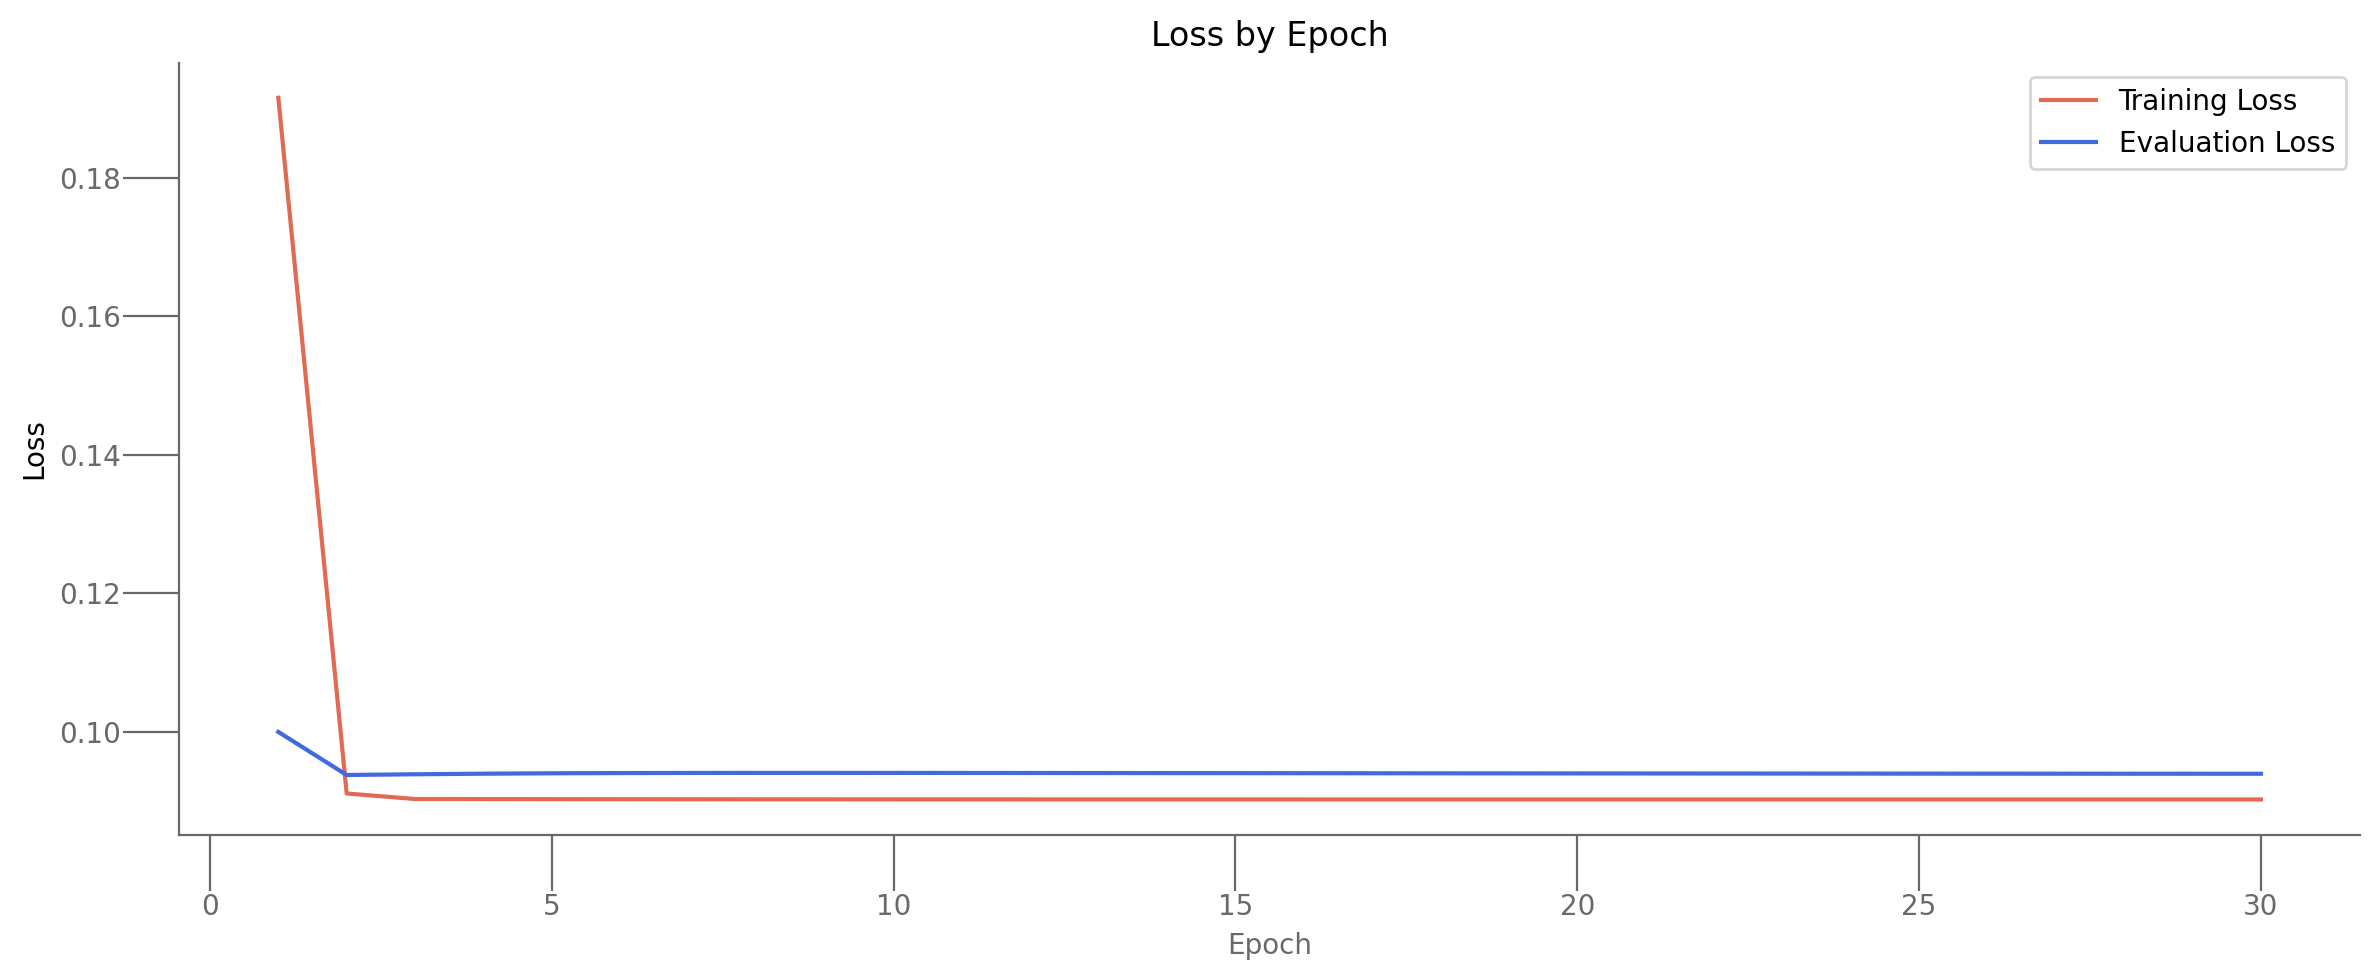


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.103355, test r2score -70.255618


In [42]:
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_brt, real_brt = trainer_brt.test()

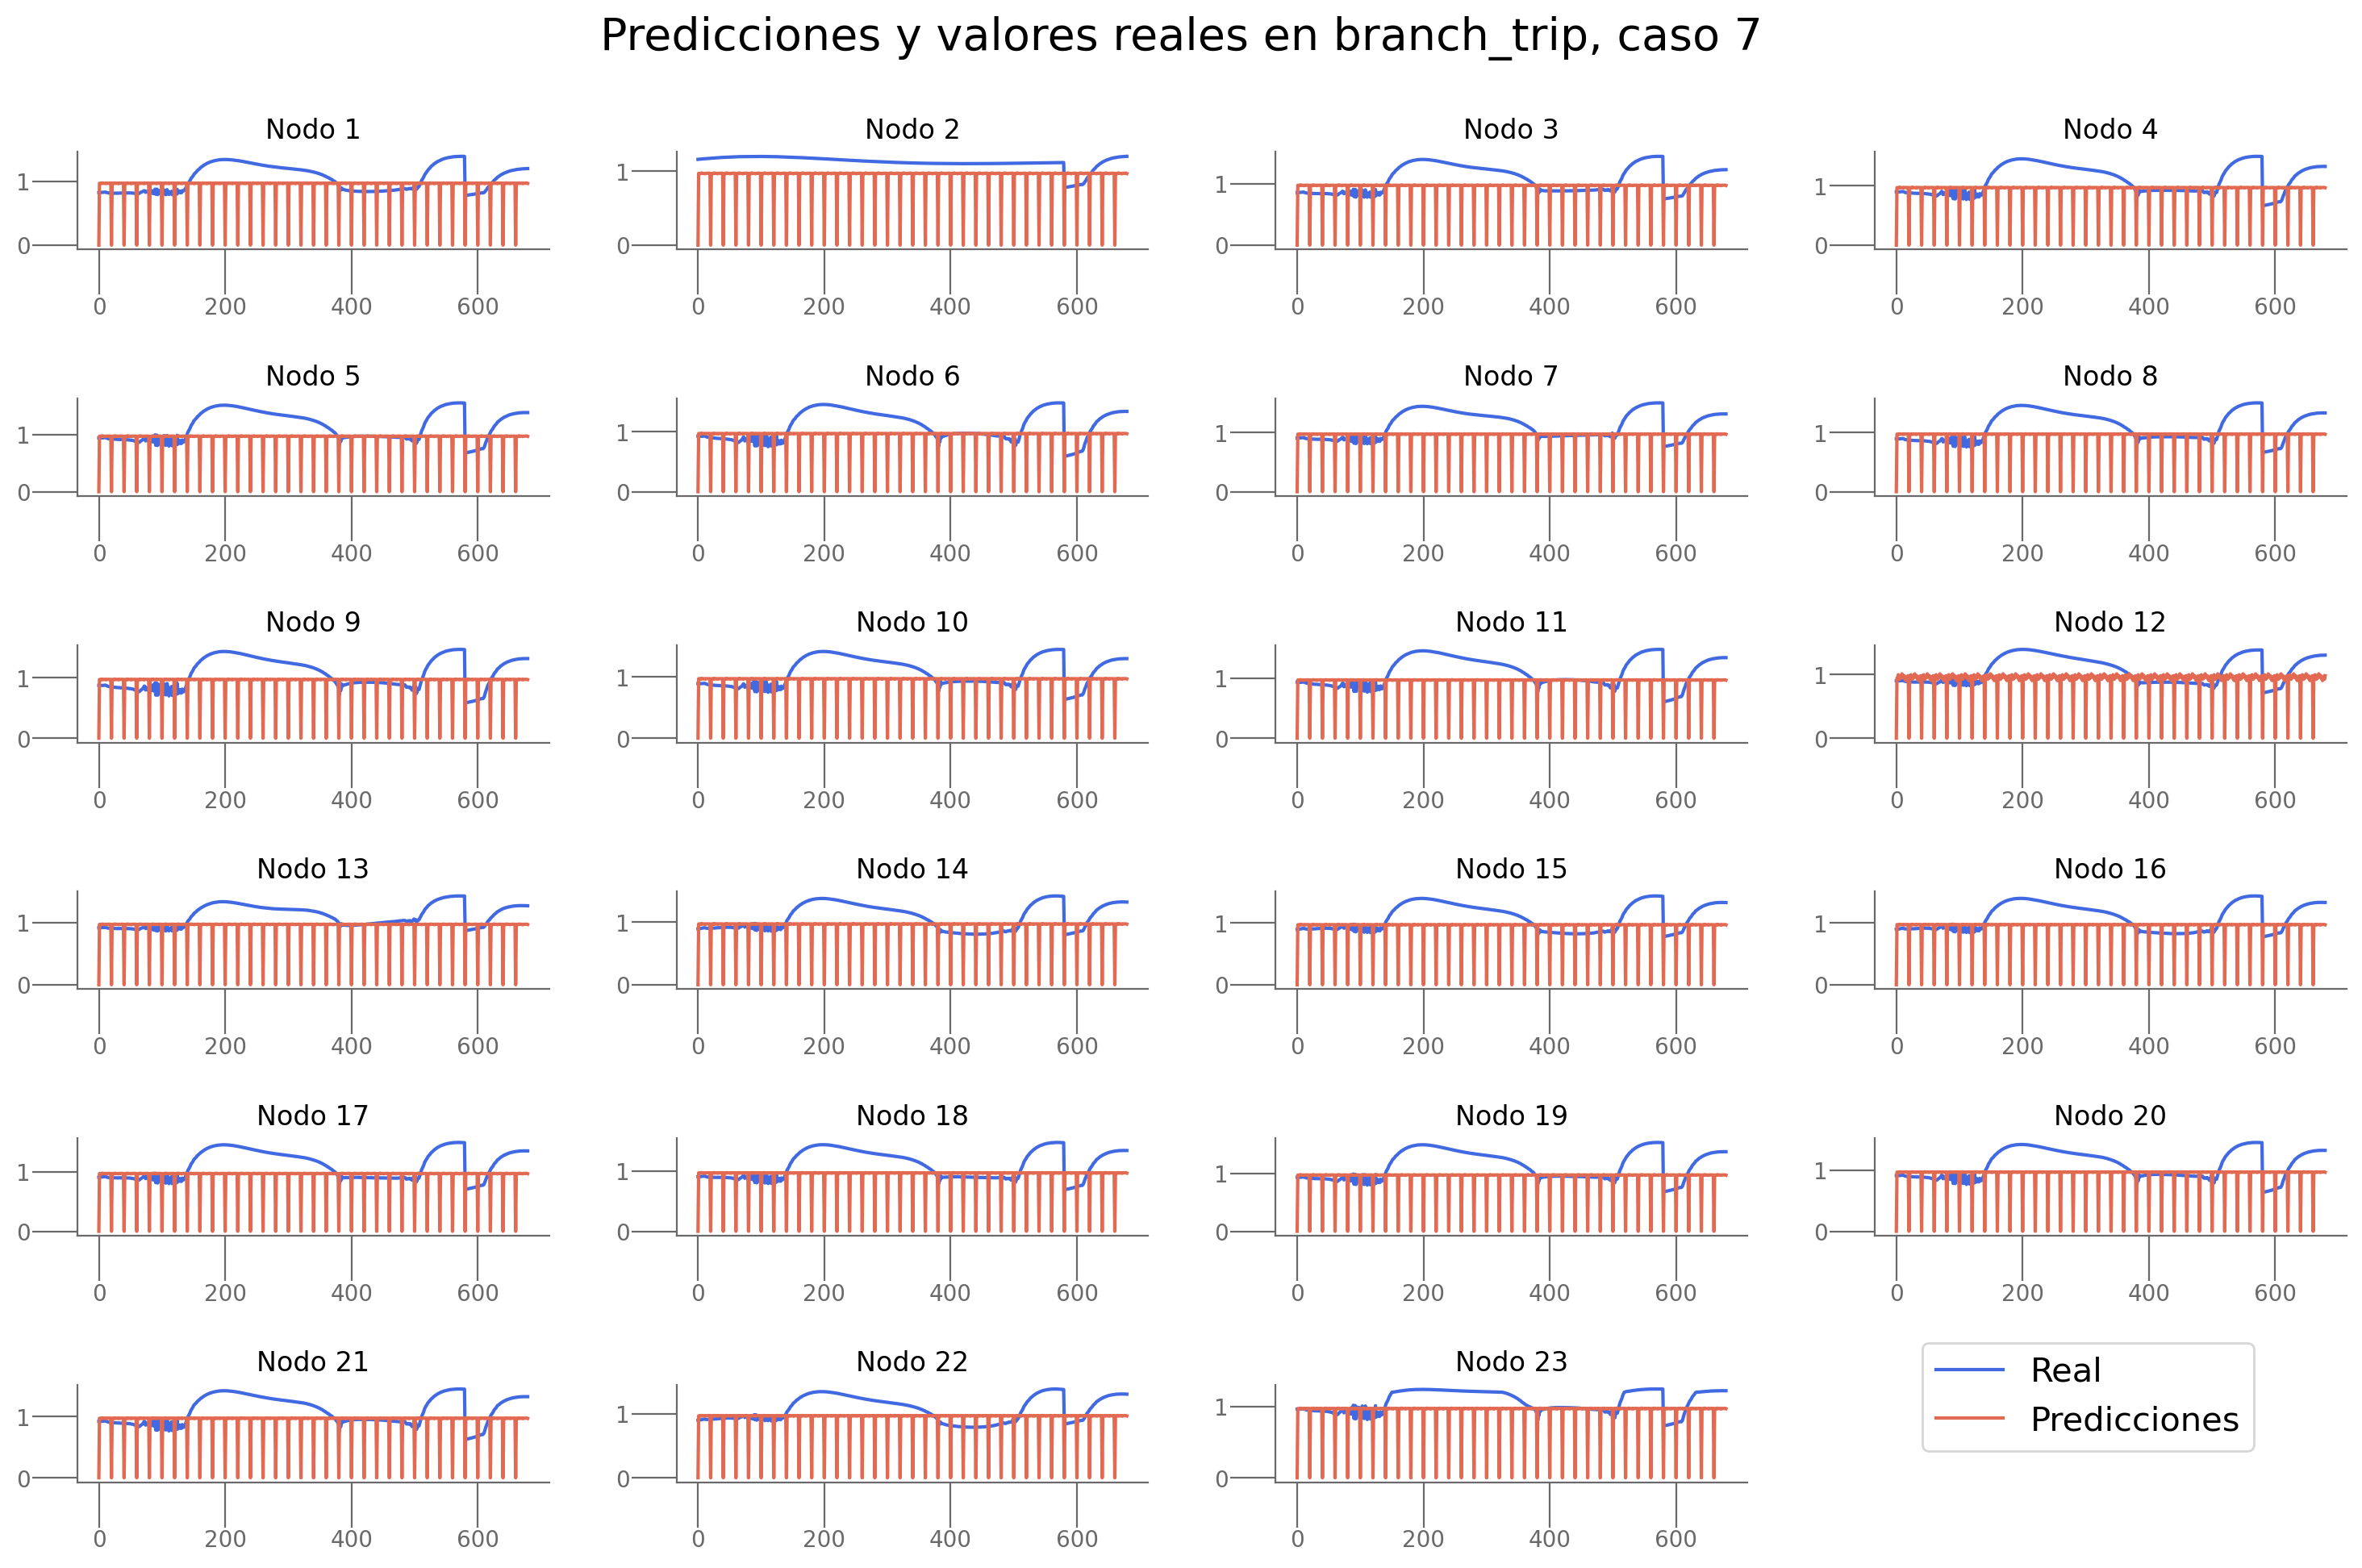

In [43]:
plot_predictions(predictions_brt, real_brt, n_target, 7, n_div_brt, problem_brt)

#### Ajuste de parámetros 

In [42]:


num_epochs = 100
num_early_stop = 10

trainer_brt,params_brt,resultados_final_brt, resultados_brt = entrenar_y_evaluar_modelos_mstgcn(param_grid, dataset_brt, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_brt)

  0%|          | 0/54 [00:00<?, ?it/s]

Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=50

==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== TRAIN INFO ===================

Epoch 1/100 | Train Loss: 0.4633 | Eval Loss: 0.2820 | Eval R2: -221.6480 | LR: 0.0010 | 
Epoch 2/100 | Train Loss: 0.2023 | Eval Loss: 0.1552 | Eval R2: -111.1310 | LR: 0.0010 | 
Epoch 3/100 | Train Loss: 0.1356 | Eval Loss: 0.1004 | Eval R2: -66.0496 | LR: 0.0010 | 
Epoch 4/100 | Train Loss: 0.0766 | Eval Loss: 0.0715 | Eval R2: -41.7127 | LR: 0.0010 | 
Epoch 5/100 | Train Loss: 0.0638 | Eval Loss: 0.0593 | Eval R2: -32.0857 | LR: 0.0010 | 
Epoch 6/100 | Train Loss: 0.0542 | Eval Loss: 0.0540 | Eval R2: -27.7802 | LR: 0.0010 | 
Epoch 7/100 | Train Loss: 0.0497 | Eval Loss: 0.0501 | Eval R2: -24.3710 | LR: 0.0010 | 
Epoch 8/100 | Train Loss: 0.0467 | Eval Loss: 0.0477 | Eval R2: -22.3016 | LR: 0.0010 | 
Epoch 9/100 | Trai

  2%|▏         | 1/54 [07:16<6:25:24, 436.30s/it]

preds:  (1, 23, 20)
test loss: 0.046781, test R2 score: -19.158192
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.03954848274588585, 'r2_eval_final': -17.593339920043945, 'loss_eval_final': 0.04155992716550827, 'r2_test': -19.15819193396587, 'loss_test': 0.04678088799118996, 'loss_nodes': [0.03270538151264191, 0.029241586104035378, 0.03888066112995148, 0.05607134848833084, 0.0662606880068779, 0.06270540505647659, 0.04831063374876976, 0.05724913254380226, 0.06506698578596115, 0.04328002408146858, 0.06091795116662979, 0.046382587403059006, 0.0280167069286108, 0.041187066584825516, 0.03357690945267677, 0.03360826149582863, 0.05344177782535553, 0.054060496389865875, 0.05962114408612251, 0.0426727794110775, 0.055854711681604385, 0.03343678638339043, 0.03341146558523178]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=80

==================== DATASET INFO =======

  4%|▎         | 2/54 [14:46<6:25:18, 444.59s/it]

preds:  (1, 23, 20)
test loss: 0.046770, test R2 score: -19.157663
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.0395442396402359, 'r2_eval_final': -17.593669891357422, 'loss_eval_final': 0.04156486317515373, 'r2_test': -19.157663126777745, 'loss_test': 0.04676974564790726, 'loss_nodes': [0.03270575776696205, 0.02924257144331932, 0.03888890519738197, 0.05607319623231888, 0.06626483798027039, 0.06270630657672882, 0.04831404983997345, 0.05725081264972687, 0.0649205818772316, 0.043266646564006805, 0.060917895287275314, 0.04627465829253197, 0.028011439368128777, 0.04118957743048668, 0.03356817737221718, 0.033614255487918854, 0.05344034358859062, 0.05406277999281883, 0.05961546674370766, 0.04267452657222748, 0.055875662714242935, 0.03343264013528824, 0.0333930142223835]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=100

==================== DATASET INFO =====

  6%|▌         | 3/54 [22:18<6:20:39, 447.82s/it]

preds:  (1, 23, 20)
test loss: 0.046781, test R2 score: -19.158097
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.03954802453517914, 'r2_eval_final': -17.593149185180664, 'loss_eval_final': 0.04155987873673439, 'r2_test': -19.158096562949332, 'loss_test': 0.0467807799577713, 'loss_nodes': [0.03270545229315758, 0.029241763055324554, 0.03887949883937836, 0.0560716837644577, 0.0662614107131958, 0.06270553916692734, 0.04831124469637871, 0.05724908411502838, 0.0650709718465805, 0.04327620565891266, 0.06091858819127083, 0.046382807195186615, 0.028016183525323868, 0.04118755832314491, 0.033576399087905884, 0.03360700607299805, 0.053441744297742844, 0.054060861468315125, 0.059620603919029236, 0.042671140283346176, 0.05585440993309021, 0.03343668580055237, 0.03341120854020119]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=50

==================== DATASET INFO ===

  7%|▋         | 4/54 [29:12<6:02:02, 434.45s/it]

preds:  (1, 23, 20)
test loss: 0.312478, test R2 score: -257.029355
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.2886258661746979, 'r2_eval_final': -233.60989379882812, 'loss_eval_final': 0.29344961047172546, 'r2_test': -257.0293547017673, 'loss_test': 0.3124779462814331, 'loss_nodes': [0.28308817744255066, 0.2847968339920044, 0.2934965193271637, 0.32013455033302307, 0.34901997447013855, 0.3185114562511444, 0.32574182748794556, 0.31804707646369934, 0.3049849569797516, 0.316142737865448, 0.3191605806350708, 0.29901912808418274, 0.3084627687931061, 0.3101878762245178, 0.31376388669013977, 0.3158048391342163, 0.32561954855918884, 0.3213687837123871, 0.3392208516597748, 0.31311386823654175, 0.3118131458759308, 0.3070565462112427, 0.288437157869339]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=80

==================== DATASET INFO ===================

Train

  9%|▉         | 5/54 [37:23<6:11:25, 454.80s/it]

preds:  (1, 23, 20)
test loss: 0.312478, test R2 score: -257.029356
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.2886258661746979, 'r2_eval_final': -233.60989379882812, 'loss_eval_final': 0.29344961047172546, 'r2_test': -257.0293558657043, 'loss_test': 0.3124779462814331, 'loss_nodes': [0.28308814764022827, 0.2847968339920044, 0.2934965491294861, 0.3201345205307007, 0.34902000427246094, 0.3185114860534668, 0.32574185729026794, 0.31804707646369934, 0.3049849569797516, 0.3161427676677704, 0.3191605806350708, 0.29901909828186035, 0.3084627687931061, 0.3101878762245178, 0.31376388669013977, 0.3158048093318939, 0.32561954855918884, 0.3213687837123871, 0.3392208516597748, 0.31311386823654175, 0.3118131458759308, 0.30705657601356506, 0.288437157869339]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=100

==================== DATASET INFO ===================

Tra

 11%|█         | 6/54 [55:13<8:51:11, 663.99s/it]

preds:  (1, 23, 20)
test loss: 0.312478, test R2 score: -257.029355
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.2886258661746979, 'r2_eval_final': -233.60989379882812, 'loss_eval_final': 0.29344961047172546, 'r2_test': -257.0293547531886, 'loss_test': 0.3124779462814331, 'loss_nodes': [0.28308817744255066, 0.2847968339920044, 0.2934965193271637, 0.3201345205307007, 0.34901997447013855, 0.3185114562511444, 0.32574182748794556, 0.31804707646369934, 0.3049849569797516, 0.316142737865448, 0.3191605806350708, 0.29901912808418274, 0.3084627687931061, 0.3101878762245178, 0.31376391649246216, 0.3158048391342163, 0.32561954855918884, 0.3213688135147095, 0.3392208516597748, 0.31311386823654175, 0.3118131160736084, 0.30705660581588745, 0.2884371280670166]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=50

==================== DATASET INFO ===================

Tr

 13%|█▎        | 7/54 [1:05:18<8:25:03, 644.76s/it]

preds:  (1, 23, 20)
test loss: 0.056850, test R2 score: -28.156116
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.06634464114904404, 'r2_eval_final': -25.84861183166504, 'loss_eval_final': 0.049941156059503555, 'r2_test': -28.15611566476074, 'loss_test': 0.05684950202703476, 'loss_nodes': [0.039610572159290314, 0.036496374756097794, 0.0461125373840332, 0.06392733752727509, 0.07546880096197128, 0.06902150809764862, 0.05712071433663368, 0.06558161973953247, 0.06959888339042664, 0.06294922530651093, 0.06851884722709656, 0.05299431458115578, 0.03960653021931648, 0.049393169581890106, 0.053040165454149246, 0.052934445440769196, 0.0636085495352745, 0.0621819905936718, 0.07091312110424042, 0.06225167214870453, 0.06276363134384155, 0.04390774294734001, 0.03953663259744644]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=80

==================== DATASET INFO =====

 15%|█▍        | 8/54 [1:12:58<7:29:13, 585.94s/it]

preds:  (1, 23, 20)
test loss: 0.056856, test R2 score: -28.187159
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.06640826910734177, 'r2_eval_final': -25.879684448242188, 'loss_eval_final': 0.049963369965553284, 'r2_test': -28.187158573749105, 'loss_test': 0.0568559393286705, 'loss_nodes': [0.03964345157146454, 0.036530427634716034, 0.04614630714058876, 0.06391621381044388, 0.07550739496946335, 0.06843583285808563, 0.05715884268283844, 0.0656166672706604, 0.06962985545396805, 0.06298451870679855, 0.06855347007513046, 0.05302787199616432, 0.039645563811063766, 0.049423523247241974, 0.05307747423648834, 0.05297230929136276, 0.0636458769440651, 0.06221842020750046, 0.07095182687044144, 0.062286488711833954, 0.06279788911342621, 0.04394541680812836, 0.03957090899348259]}
Entrenando modelo con nb_block=1, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=100

==================== DATASET INFO ===

 17%|█▋        | 9/54 [1:22:33<7:16:49, 582.42s/it]

preds:  (1, 23, 20)
test loss: 0.056823, test R2 score: -28.148928
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.06633200496435165, 'r2_eval_final': -25.843883514404297, 'loss_eval_final': 0.04992067813873291, 'r2_test': -28.148928411500354, 'loss_test': 0.05682267248630524, 'loss_nodes': [0.03960154950618744, 0.03648789972066879, 0.046103864908218384, 0.06388672441244125, 0.07546177506446838, 0.06861842423677444, 0.05711345747113228, 0.06557323038578033, 0.06958910822868347, 0.06294102221727371, 0.06851030886173248, 0.05298547446727753, 0.039599716663360596, 0.049381323158741, 0.05303264409303665, 0.05292709544301033, 0.06360099464654922, 0.0621742345392704, 0.07090611010789871, 0.06224321573972702, 0.06275496631860733, 0.043900422751903534, 0.0395280085504055]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=50

==================== DATASET INFO =======

 19%|█▊        | 10/54 [1:31:20<6:54:44, 565.55s/it]

preds:  (1, 23, 20)
test loss: 0.228614, test R2 score: -196.859428
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.21253831684589386, 'r2_eval_final': -177.83651733398438, 'loss_eval_final': 0.21519377827644348, 'r2_test': -196.8594281289513, 'loss_test': 0.2286142259836197, 'loss_nodes': [0.21147102117538452, 0.21424394845962524, 0.21687468886375427, 0.23160132765769958, 0.2522056996822357, 0.22857563197612762, 0.23888404667377472, 0.22878606617450714, 0.2164149284362793, 0.2282658815383911, 0.22941642999649048, 0.21853399276733398, 0.23280592262744904, 0.23062148690223694, 0.2307971715927124, 0.23295532166957855, 0.2361222207546234, 0.23475831747055054, 0.24455749988555908, 0.22683441638946533, 0.2259340137243271, 0.22950764000415802, 0.21795935928821564]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=80

==================== DATASET INFO ===============

 20%|██        | 11/54 [1:43:59<7:27:37, 624.60s/it]

preds:  (1, 23, 20)
test loss: 0.228614, test R2 score: -196.859426
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.21253831684589386, 'r2_eval_final': -177.83651733398438, 'loss_eval_final': 0.21519380807876587, 'r2_test': -196.85942630150237, 'loss_test': 0.2286142259836197, 'loss_nodes': [0.21147096157073975, 0.21424388885498047, 0.21687465906143188, 0.2316012978553772, 0.25220564007759094, 0.2285754680633545, 0.2388840764760971, 0.2287861853837967, 0.21641486883163452, 0.2282658815383911, 0.22941631078720093, 0.21853405237197876, 0.23280595242977142, 0.23062138259410858, 0.23079721629619598, 0.23295533657073975, 0.2361222803592682, 0.23475834727287292, 0.24455730617046356, 0.22683444619178772, 0.2259339839220047, 0.2295076698064804, 0.21795929968357086]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=100

==================== DATASET INFO ===============

 22%|██▏       | 12/54 [2:03:35<9:14:40, 792.39s/it]

preds:  (1, 23, 20)
test loss: 0.228614, test R2 score: -196.859464
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.21253837645053864, 'r2_eval_final': -177.83653259277344, 'loss_eval_final': 0.21519385278224945, 'r2_test': -196.85946422856424, 'loss_test': 0.22861431539058685, 'loss_nodes': [0.2114710509777069, 0.21424400806427002, 0.21687468886375427, 0.23160138726234436, 0.25220581889152527, 0.22857558727264404, 0.2388841211795807, 0.2287861406803131, 0.21641504764556885, 0.2282659411430359, 0.2294166088104248, 0.21853405237197876, 0.23280596733093262, 0.2306215763092041, 0.23079726099967957, 0.23295539617538452, 0.2361222803592682, 0.23475845158100128, 0.24455758929252625, 0.2268344759941101, 0.22593413293361664, 0.2295076996088028, 0.21795937418937683]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=50

==================== DATASET INFO ===============

 24%|██▍       | 13/54 [2:14:45<8:36:04, 755.22s/it]

preds:  (1, 23, 20)
test loss: 0.343962, test R2 score: -296.884656
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.3202047348022461, 'r2_eval_final': -269.9933166503906, 'loss_eval_final': 0.32487207651138306, 'r2_test': -296.88465608858553, 'loss_test': 0.3439615070819855, 'loss_nodes': [0.31719714403152466, 0.3216118812561035, 0.32617467641830444, 0.34874284267425537, 0.37798431515693665, 0.3440479636192322, 0.3595525622367859, 0.34511852264404297, 0.3267515301704407, 0.34417855739593506, 0.34580668807029724, 0.3294029235839844, 0.34973129630088806, 0.3455359935760498, 0.3478415310382843, 0.35076799988746643, 0.3560773432254791, 0.35206201672554016, 0.3684738278388977, 0.34195685386657715, 0.34015557169914246, 0.3454410433769226, 0.3265019357204437]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=80

==================== DATASET INFO ===================



 26%|██▌       | 14/54 [2:22:24<7:23:58, 665.97s/it]

preds:  (1, 23, 20)
test loss: 0.343961, test R2 score: -296.884556
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.32020461559295654, 'r2_eval_final': -269.99322509765625, 'loss_eval_final': 0.32487189769744873, 'r2_test': -296.88455588291106, 'loss_test': 0.34396126866340637, 'loss_nodes': [0.3171970248222351, 0.32161176204681396, 0.3261745870113373, 0.3487425148487091, 0.377983957529068, 0.3440476953983307, 0.3595523536205292, 0.34511828422546387, 0.3267512023448944, 0.3441784083843231, 0.3458064794540405, 0.3294025957584381, 0.34973111748695374, 0.3455357253551483, 0.3478412628173828, 0.35076767206192017, 0.35607707500457764, 0.35206177830696106, 0.36847352981567383, 0.34195664525032043, 0.3401552736759186, 0.3454408645629883, 0.32650190591812134]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=100

==================== DATASET INFO ===================



 28%|██▊       | 15/54 [2:29:34<6:26:28, 594.57s/it]

preds:  (1, 23, 20)
test loss: 0.343961, test R2 score: -296.884639
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.3202047049999237, 'r2_eval_final': -269.9932861328125, 'loss_eval_final': 0.32487207651138306, 'r2_test': -296.8846387612352, 'loss_test': 0.3439614772796631, 'loss_nodes': [0.31719714403152466, 0.3216118812561035, 0.32617467641830444, 0.3487427234649658, 0.3779842257499695, 0.34404799342155457, 0.3595525324344635, 0.3451184928417206, 0.3267514705657959, 0.34417852759361267, 0.34580671787261963, 0.3294028639793396, 0.34973129630088806, 0.34553587436676025, 0.3478415310382843, 0.35076799988746643, 0.35607731342315674, 0.3520619869232178, 0.36847373843193054, 0.34195685386657715, 0.3401554524898529, 0.3454410433769226, 0.3265019357204437]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=50

==================== DATASET INFO ===================



 30%|██▉       | 16/54 [2:36:33<5:43:13, 541.92s/it]

preds:  (1, 23, 20)
test loss: 0.008835, test R2 score: -3.841134
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.008083699271082878, 'r2_eval_final': -3.3894832134246826, 'loss_eval_final': 0.007424598094075918, 'r2_test': -3.841134057819811, 'loss_test': 0.008834817446768284, 'loss_nodes': [0.004401030950248241, 0.0035723622422665358, 0.005771759897470474, 0.010780878365039825, 0.012514336034655571, 0.014272821135818958, 0.00800315011292696, 0.01038402784615755, 0.013083687983453274, 0.009879853576421738, 0.01242834236472845, 0.007987426593899727, 0.004060942213982344, 0.006620536558330059, 0.006840127054601908, 0.007376488763839006, 0.009475122205913067, 0.010264609009027481, 0.010845781303942204, 0.011062844656407833, 0.011103625409305096, 0.004717158153653145, 0.0077538699842989445]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=80

=================

 31%|███▏      | 17/54 [2:44:48<5:25:28, 527.80s/it]

preds:  (1, 23, 20)
test loss: 0.008835, test R2 score: -3.841134
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.008083696477115154, 'r2_eval_final': -3.3895034790039062, 'loss_eval_final': 0.007424603682011366, 'r2_test': -3.841133738375001, 'loss_test': 0.008834795095026493, 'loss_nodes': [0.004401035141199827, 0.0035723692271858454, 0.005771750584244728, 0.010780884884297848, 0.012514354661107063, 0.01427282951772213, 0.008003171533346176, 0.0103840297088027, 0.013083693571388721, 0.009879853576421738, 0.012428352609276772, 0.007987436838448048, 0.0040609389543533325, 0.006619957275688648, 0.006840131711214781, 0.0073764934204518795, 0.00947511661797762, 0.010264613665640354, 0.010845775716006756, 0.011062846519052982, 0.011103634722530842, 0.004717150237411261, 0.0077538806945085526]}
Entrenando modelo con nb_block=1, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=100

===============

 33%|███▎      | 18/54 [2:56:37<5:49:16, 582.13s/it]

preds:  (1, 23, 20)
test loss: 0.008835, test R2 score: -3.841115
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.008083711378276348, 'r2_eval_final': -3.3894858360290527, 'loss_eval_final': 0.007424586918205023, 'r2_test': -3.841115038269655, 'loss_test': 0.008834776468575, 'loss_nodes': [0.004401032812893391, 0.0035723650362342596, 0.0057717589661479, 0.010780866257846355, 0.012514348141849041, 0.014272814616560936, 0.00800313614308834, 0.01038401573896408, 0.01308367308229208, 0.00987984798848629, 0.012428311631083488, 0.007987418211996555, 0.004060941748321056, 0.006619775667786598, 0.006840130779892206, 0.007376481778919697, 0.009475109167397022, 0.010264609009027481, 0.010845756158232689, 0.01106283813714981, 0.011103601194918156, 0.004717150703072548, 0.007753860671073198]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=50

==================== DATA

 35%|███▌      | 19/54 [3:05:45<5:33:38, 571.95s/it]

preds:  (1, 23, 20)
test loss: 0.170640, test R2 score: -147.255084
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.15918783843517303, 'r2_eval_final': -133.26087951660156, 'loss_eval_final': 0.16071462631225586, 'r2_test': -147.25508405981137, 'loss_test': 0.1706395149230957, 'loss_nodes': [0.15747186541557312, 0.159674271941185, 0.16175661981105804, 0.17292891442775726, 0.18669374287128448, 0.17075099050998688, 0.17843180894851685, 0.17064151167869568, 0.16147339344024658, 0.1703873574733734, 0.17165736854076385, 0.16329345107078552, 0.17427833378314972, 0.17248311638832092, 0.17207646369934082, 0.1737644225358963, 0.17608694732189178, 0.1742170751094818, 0.18335190415382385, 0.16943293809890747, 0.16908049583435059, 0.1713199019432068, 0.1634552925825119]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=80

==================== DATASET INFO ===============

 37%|███▋      | 20/54 [3:14:47<5:18:59, 562.91s/it]

preds:  (1, 23, 20)
test loss: 0.170639, test R2 score: -147.255098
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.15918786823749542, 'r2_eval_final': -133.26095581054688, 'loss_eval_final': 0.1607147455215454, 'r2_test': -147.25509754825862, 'loss_test': 0.17063948512077332, 'loss_nodes': [0.15747196972370148, 0.15967442095279694, 0.1617567241191864, 0.17292894423007965, 0.1866934895515442, 0.17075110971927643, 0.17843173444271088, 0.17064139246940613, 0.16147345304489136, 0.17038732767105103, 0.17165741324424744, 0.16329340636730194, 0.17427818477153778, 0.17248333990573883, 0.17207640409469604, 0.17376434803009033, 0.17608687281608582, 0.17421697080135345, 0.1833518147468567, 0.16943295300006866, 0.16908051073551178, 0.1713198721408844, 0.16345536708831787]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=100

==================== DATASET INFO ===========

 39%|███▉      | 21/54 [3:24:03<5:08:29, 560.90s/it]

preds:  (1, 23, 20)
test loss: 0.170639, test R2 score: -147.255089
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.15918785333633423, 'r2_eval_final': -133.2609405517578, 'loss_eval_final': 0.16071471571922302, 'r2_test': -147.25508939698074, 'loss_test': 0.17063945531845093, 'loss_nodes': [0.1574719399213791, 0.15967439115047455, 0.1617567092180252, 0.17292891442775726, 0.18669332563877106, 0.17075100541114807, 0.17843171954154968, 0.17064142227172852, 0.1614733636379242, 0.17038728296756744, 0.17165735363960266, 0.16329337656497955, 0.17427821457386017, 0.1724831610918045, 0.17207635939121246, 0.17376431822776794, 0.17608685791492462, 0.17421692609786987, 0.18335166573524475, 0.1694328933954239, 0.1690804809331894, 0.17131991684436798, 0.16345539689064026]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=50

==================== DATASET INFO =============

 41%|████      | 22/54 [3:31:57<4:45:13, 534.79s/it]

preds:  (1, 23, 20)
test loss: 0.062842, test R2 score: -51.756339
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.057701464742422104, 'r2_eval_final': -46.886539459228516, 'loss_eval_final': 0.058418914675712585, 'r2_test': -51.75633886984372, 'loss_test': 0.06284234672784805, 'loss_nodes': [0.055338095873594284, 0.055593278259038925, 0.05807558074593544, 0.06428338587284088, 0.07012517750263214, 0.06511595100164413, 0.06506963819265366, 0.06384508311748505, 0.062103379517793655, 0.06372173875570297, 0.06549479812383652, 0.05984862521290779, 0.0615554004907608, 0.06190935894846916, 0.06251098960638046, 0.06346065551042557, 0.06546420603990555, 0.06473549455404282, 0.06858915090560913, 0.06416421383619308, 0.06382857263088226, 0.06083611771464348, 0.059704963117837906]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=80

==================== DATASET INFO ====

 43%|████▎     | 23/54 [3:39:40<4:25:15, 513.39s/it]

preds:  (1, 23, 20)
test loss: 0.062842, test R2 score: -51.756349
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.05770145729184151, 'r2_eval_final': -46.886531829833984, 'loss_eval_final': 0.058418914675712585, 'r2_test': -51.75634888828273, 'loss_test': 0.06284236907958984, 'loss_nodes': [0.055338144302368164, 0.05559331923723221, 0.05807563662528992, 0.0642833486199379, 0.07012525945901871, 0.06511597335338593, 0.06506951153278351, 0.06384503841400146, 0.06210342422127724, 0.06372179836034775, 0.0654948428273201, 0.059848640114068985, 0.06155533343553543, 0.06190953403711319, 0.06251108646392822, 0.06346071511507034, 0.06546417623758316, 0.06473559886217117, 0.06858909875154495, 0.06416427344083786, 0.06382866948843002, 0.060836102813482285, 0.05970493704080582]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=100

==================== DATASET INFO ======

 44%|████▍     | 24/54 [3:48:14<4:16:40, 513.36s/it]

preds:  (1, 23, 20)
test loss: 0.062843, test R2 score: -51.756492
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.057701561599969864, 'r2_eval_final': -46.886661529541016, 'loss_eval_final': 0.05841909348964691, 'r2_test': -51.75649223037449, 'loss_test': 0.06284259259700775, 'loss_nodes': [0.05533839762210846, 0.055593524128198624, 0.05807576701045036, 0.06428368389606476, 0.07012569159269333, 0.06511630117893219, 0.0650697723031044, 0.06384534388780594, 0.06210361421108246, 0.06372199207544327, 0.06549496203660965, 0.0598488375544548, 0.061555586755275726, 0.06190965324640274, 0.06251130253076553, 0.06346091628074646, 0.06546448916196823, 0.06473595649003983, 0.06858912110328674, 0.06416445970535278, 0.0638287216424942, 0.06083633378148079, 0.059705156832933426]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=50

==================== DATASET INFO ======

 46%|████▋     | 25/54 [3:56:29<4:05:30, 507.96s/it]

preds:  (1, 23, 20)
test loss: 0.010494, test R2 score: -4.781474
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.008643451146781445, 'r2_eval_final': -4.138988971710205, 'loss_eval_final': 0.00862383097410202, 'r2_test': -4.781473970250872, 'loss_test': 0.01049426756799221, 'loss_nodes': [0.005443336442112923, 0.004527031909674406, 0.007114790380001068, 0.011333146132528782, 0.014549735002219677, 0.015422151423990726, 0.008437965996563435, 0.012054725550115108, 0.014830552041530609, 0.011964394710958004, 0.014995734207332134, 0.009467361494898796, 0.0055252970196306705, 0.008901062421500683, 0.008648541755974293, 0.009143398143351078, 0.011294570751488209, 0.012135363183915615, 0.01399494893848896, 0.012951524928212166, 0.01340461801737547, 0.005831880960613489, 0.009396023117005825]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=80

====================

 48%|████▊     | 26/54 [4:04:12<3:50:45, 494.47s/it]

preds:  (1, 23, 20)
test loss: 0.010494, test R2 score: -4.781367
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.008643421344459057, 'r2_eval_final': -4.138899803161621, 'loss_eval_final': 0.008623724803328514, 'r2_test': -4.781367185056342, 'loss_test': 0.010494123212993145, 'loss_nodes': [0.005443315487354994, 0.004527000244706869, 0.007114674896001816, 0.011333036236464977, 0.01454962883144617, 0.015421951189637184, 0.008437715470790863, 0.01205463707447052, 0.014830471947789192, 0.011964167468249798, 0.014995651319622993, 0.009467282332479954, 0.0055251955054700375, 0.008900640532374382, 0.008648362010717392, 0.009143213741481304, 0.011294445022940636, 0.012135226279497147, 0.013994703069329262, 0.012951272539794445, 0.01340456958860159, 0.005831806920468807, 0.009395929053425789]}
Entrenando modelo con nb_block=1, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=100

==================

 50%|█████     | 27/54 [4:11:45<3:36:51, 481.92s/it]

preds:  (1, 23, 20)
test loss: 0.010494, test R2 score: -4.781391
Resultados intermedios:  {'nb_block': 1, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.008643372915685177, 'r2_eval_final': -4.138908863067627, 'loss_eval_final': 0.008623721078038216, 'r2_test': -4.78139127279988, 'loss_test': 0.010494126938283443, 'loss_nodes': [0.005443156696856022, 0.004526874516159296, 0.007114604581147432, 0.01133314985781908, 0.014549392275512218, 0.015422188676893711, 0.008437901735305786, 0.012054650112986565, 0.01483054831624031, 0.011964039877057076, 0.014995687641203403, 0.00946733821183443, 0.005525288172066212, 0.008900779299438, 0.008648228831589222, 0.009143076837062836, 0.011294483207166195, 0.012134971097111702, 0.013994843699038029, 0.012951242737472057, 0.013404604978859425, 0.005831914488226175, 0.009395967237651348]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=50

==================== DAT

 52%|█████▏    | 28/54 [4:26:42<4:22:49, 606.53s/it]

preds:  (1, 23, 20)
test loss: 0.100908, test R2 score: -67.258562
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.08991586416959763, 'r2_eval_final': -61.510223388671875, 'loss_eval_final': 0.09307649731636047, 'r2_test': -67.25856180823492, 'loss_test': 0.10090785473585129, 'loss_nodes': [0.08242614567279816, 0.07987687736749649, 0.08928664028644562, 0.10792722553014755, 0.12108726054430008, 0.11324552446603775, 0.10231913626194, 0.10918949544429779, 0.11154242604970932, 0.10666224360466003, 0.11193932592868805, 0.09763410687446594, 0.08487170934677124, 0.09388136118650436, 0.09749290347099304, 0.09758681803941727, 0.10814623534679413, 0.10644446313381195, 0.11603496223688126, 0.10570497065782547, 0.10604342073202133, 0.08863221853971481, 0.08290448039770126]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=80

==================== DATASET INFO ============

 54%|█████▎    | 29/54 [4:41:55<4:51:01, 698.47s/it]

preds:  (1, 23, 20)
test loss: 0.100907, test R2 score: -67.258443
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.08991510421037674, 'r2_eval_final': -61.510154724121094, 'loss_eval_final': 0.09307767450809479, 'r2_test': -67.25844250680301, 'loss_test': 0.10090707242488861, 'loss_nodes': [0.08242616057395935, 0.07987691462039948, 0.089286670088768, 0.10792730748653412, 0.12108760327100754, 0.11324558407068253, 0.1023193970322609, 0.10918960720300674, 0.11154241114854813, 0.106662318110466, 0.1119394451379776, 0.09763076156377792, 0.08487197756767273, 0.09386473149061203, 0.0974929928779602, 0.09758699685335159, 0.10814639925956726, 0.10644456744194031, 0.11603521555662155, 0.10570509731769562, 0.1060434952378273, 0.08863236010074615, 0.08290454745292664]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=2, hidden=100

==================== DATASET INFO ================

 56%|█████▌    | 30/54 [4:55:52<4:55:59, 739.97s/it]

preds:  (1, 23, 20)
test loss: 0.100906, test R2 score: -67.257751
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.08991497755050659, 'r2_eval_final': -61.50940704345703, 'loss_eval_final': 0.09307602792978287, 'r2_test': -67.25775124269538, 'loss_test': 0.10090581327676773, 'loss_nodes': [0.08242622762918472, 0.07987652719020844, 0.08928631246089935, 0.10792607069015503, 0.12108486145734787, 0.11324521154165268, 0.10231706500053406, 0.10918878763914108, 0.11154315620660782, 0.10666139423847198, 0.11193884909152985, 0.09763322025537491, 0.08486964553594589, 0.09385669976472855, 0.09749142825603485, 0.09758523106575012, 0.10814475268125534, 0.10644320398569107, 0.11603303253650665, 0.10570447146892548, 0.10604306310415268, 0.08863062411546707, 0.08290406316518784]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=50

==================== DATASET INFO =========

 57%|█████▋    | 31/54 [5:13:30<5:20:12, 835.32s/it]

preds:  (1, 23, 20)
test loss: 0.048403, test R2 score: -20.069293
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.04006331041455269, 'r2_eval_final': -18.56279754638672, 'loss_eval_final': 0.042963478714227676, 'r2_test': -20.06929277979888, 'loss_test': 0.048403482884168625, 'loss_nodes': [0.032550811767578125, 0.028892941772937775, 0.03859111666679382, 0.055396582931280136, 0.06487949192523956, 0.062294673174619675, 0.04713140428066254, 0.05744541063904762, 0.06342647969722748, 0.05474536493420601, 0.06056900694966316, 0.04561435431241989, 0.02960381656885147, 0.04032737761735916, 0.04396415501832962, 0.04360467568039894, 0.05436750873923302, 0.05326375365257263, 0.06093365326523781, 0.054287947714328766, 0.05500667542219162, 0.034566666930913925, 0.03181619942188263]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=80

==================== DATASET INFO ==

 59%|█████▉    | 32/54 [5:29:53<5:22:34, 879.74s/it]

preds:  (1, 23, 20)
test loss: 0.047802, test R2 score: -19.851409
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.03940979018807411, 'r2_eval_final': -18.359107971191406, 'loss_eval_final': 0.042565926909446716, 'r2_test': -19.851409299258975, 'loss_test': 0.04780184105038643, 'loss_nodes': [0.03254769742488861, 0.028033263981342316, 0.037567079067230225, 0.05418079346418381, 0.06345859915018082, 0.060618795454502106, 0.04704437404870987, 0.05690435692667961, 0.06321445107460022, 0.054513443261384964, 0.06048125773668289, 0.04492367431521416, 0.029319338500499725, 0.039955928921699524, 0.043768614530563354, 0.04338608682155609, 0.054158516228199005, 0.05290931835770607, 0.05961858853697777, 0.0536859855055809, 0.05304914340376854, 0.03434975817799568, 0.03175339102745056]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=5, hidden=100

==================== DATASET INFO

 61%|██████    | 33/54 [5:42:07<4:52:33, 835.87s/it]

preds:  (1, 23, 20)
test loss: 0.154095, test R2 score: -115.068467
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.1393175572156906, 'r2_eval_final': -104.65096282958984, 'loss_eval_final': 0.14315837621688843, 'r2_test': -115.06846724638994, 'loss_test': 0.1540953665971756, 'loss_nodes': [0.13279928267002106, 0.13129699230194092, 0.14060135185718536, 0.16135576367378235, 0.17866569757461548, 0.16480502486228943, 0.15871667861938477, 0.16174286603927612, 0.16001011431217194, 0.15941092371940613, 0.1640099436044693, 0.14698147773742676, 0.14128945767879486, 0.14836420118808746, 0.1519756317138672, 0.15258175134658813, 0.1629563421010971, 0.1605749875307083, 0.17235617339611053, 0.15783806145191193, 0.1577342450618744, 0.14366841316223145, 0.13445787131786346]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=50

==================== DATASET INFO ============

 63%|██████▎   | 34/54 [5:53:52<4:25:32, 796.64s/it]

preds:  (1, 23, 20)
test loss: 0.207175, test R2 score: -162.347984
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.18896983563899994, 'r2_eval_final': -146.98516845703125, 'loss_eval_final': 0.19325986504554749, 'r2_test': -162.34798435509356, 'loss_test': 0.20717503130435944, 'loss_nodes': [0.1830405592918396, 0.18258187174797058, 0.19175288081169128, 0.21458187699317932, 0.23587217926979065, 0.21637797355651855, 0.21469250321388245, 0.21415726840496063, 0.208553284406662, 0.21187420189380646, 0.2162601202726364, 0.19798311591148376, 0.19727438688278198, 0.20255789160728455, 0.20616461336612701, 0.2072659432888031, 0.21749433875083923, 0.21448591351509094, 0.22835075855255127, 0.2099025547504425, 0.20940379798412323, 0.19836454093456268, 0.18603238463401794]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=80

==================== DATASET INFO ===========

 65%|██████▍   | 35/54 [6:05:35<4:03:24, 768.64s/it]

preds:  (1, 23, 20)
test loss: 0.207175, test R2 score: -162.347854
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.18896985054016113, 'r2_eval_final': -146.9850311279297, 'loss_eval_final': 0.19325989484786987, 'r2_test': -162.34785389086113, 'loss_test': 0.20717497169971466, 'loss_nodes': [0.1830405592918396, 0.1825818568468094, 0.1917528212070465, 0.21458187699317932, 0.2358720749616623, 0.21637801826000214, 0.21469247341156006, 0.21415722370147705, 0.2085532248020172, 0.2118741273880005, 0.2162594348192215, 0.19798292219638824, 0.19727429747581482, 0.20255783200263977, 0.20616456866264343, 0.20726586878299713, 0.21749433875083923, 0.21448592841625214, 0.2283506691455841, 0.20990246534347534, 0.20940379798412323, 0.19836443662643433, 0.18603236973285675]}
Entrenando modelo con nb_block=2, nb_chev_filter=2, nb_time_filter=2, time_strides=10, hidden=100

==================== DATASET INFO =============

 67%|██████▋   | 36/54 [6:17:16<3:44:29, 748.29s/it]

preds:  (1, 23, 20)
test loss: 0.207175, test R2 score: -162.347630
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 2, 'nb_time_filter': 2, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.18896985054016113, 'r2_eval_final': -146.98484802246094, 'loss_eval_final': 0.19325989484786987, 'r2_test': -162.34763020156134, 'loss_test': 0.20717480778694153, 'loss_nodes': [0.18304067850112915, 0.18258193135261536, 0.19175280630588531, 0.21458184719085693, 0.23587198555469513, 0.21637789905071259, 0.2146923691034317, 0.21415723860263824, 0.20855329930782318, 0.21187405288219452, 0.21625865995883942, 0.1979825496673584, 0.19727416336536407, 0.20255768299102783, 0.2061644196510315, 0.20726574957370758, 0.2174941897392273, 0.21448585391044617, 0.22835063934326172, 0.20990246534347534, 0.2094039022922516, 0.19836431741714478, 0.18603229522705078]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=50

==================== DATASET INFO ==========

 69%|██████▊   | 37/54 [6:31:59<3:43:28, 788.76s/it]

preds:  (1, 23, 20)
test loss: 0.008573, test R2 score: -4.096234
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.006936534773558378, 'r2_eval_final': -3.475008249282837, 'loss_eval_final': 0.007049413397908211, 'r2_test': -4.0962336989093915, 'loss_test': 0.008572842925786972, 'loss_nodes': [0.004484484437853098, 0.0037428128998726606, 0.005364465527236462, 0.009371932595968246, 0.012343556620180607, 0.012313732877373695, 0.007657044567167759, 0.009642970748245716, 0.011578903533518314, 0.009809629060328007, 0.012374208308756351, 0.007399288471788168, 0.004643541295081377, 0.005725235678255558, 0.0066570863127708435, 0.007185913622379303, 0.009097629226744175, 0.01306990161538124, 0.01126995962113142, 0.010203941725194454, 0.010901507921516895, 0.004964389372617006, 0.007373245432972908]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=80

==================

 70%|███████   | 38/54 [6:46:08<3:35:07, 806.72s/it]

preds:  (1, 23, 20)
test loss: 0.008573, test R2 score: -4.096137
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.006936473306268454, 'r2_eval_final': -3.4749298095703125, 'loss_eval_final': 0.0070493207313120365, 'r2_test': -4.096136783796328, 'loss_test': 0.008572702296078205, 'loss_nodes': [0.004484427161514759, 0.0037427283823490143, 0.0053640990518033504, 0.009371842257678509, 0.012343434616923332, 0.012313617393374443, 0.007657126989215612, 0.009642772376537323, 0.011578816920518875, 0.009809799492359161, 0.012374583631753922, 0.007399115711450577, 0.00464326236397028, 0.005725684575736523, 0.006656557321548462, 0.007185359485447407, 0.009097390808165073, 0.013069726526737213, 0.011269665323197842, 0.01020349096506834, 0.010901346802711487, 0.004964157938957214, 0.0073731429874897]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=2, hidden=100

==================

 72%|███████▏  | 39/54 [7:00:41<3:26:39, 826.65s/it]

preds:  (1, 23, 20)
test loss: 0.008573, test R2 score: -4.096349
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.006936557590961456, 'r2_eval_final': -3.4749999046325684, 'loss_eval_final': 0.0070494175888597965, 'r2_test': -4.09634914901138, 'loss_test': 0.008572935126721859, 'loss_nodes': [0.0044845291413366795, 0.003742879955098033, 0.005364716984331608, 0.009371879510581493, 0.012343521229922771, 0.012313732877373695, 0.007656923495233059, 0.00964318960905075, 0.011578744277358055, 0.00981083046644926, 0.01237417571246624, 0.007399179972708225, 0.004643603228032589, 0.005725078284740448, 0.006657477933913469, 0.007186322472989559, 0.009097592905163765, 0.013069560751318932, 0.011270315386354923, 0.01020432822406292, 0.010901561006903648, 0.004964365623891354, 0.0073730070143938065]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=50

===================

 74%|███████▍  | 40/54 [7:13:27<3:08:38, 808.47s/it]

preds:  (1, 23, 20)
test loss: 0.009550, test R2 score: -4.664192
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.00750029506161809, 'r2_eval_final': -3.984257936477661, 'loss_eval_final': 0.008054329082369804, 'r2_test': -4.6641922507570035, 'loss_test': 0.009550117887556553, 'loss_nodes': [0.0036560979206115007, 0.0031148858834058046, 0.004621715750545263, 0.013056575320661068, 0.009918836876749992, 0.013016950339078903, 0.013150643557310104, 0.012857494875788689, 0.012908516451716423, 0.011805543676018715, 0.017715593799948692, 0.011821276508271694, 0.004964843858033419, 0.006675015669316053, 0.007068838458508253, 0.006247084587812424, 0.007227986119687557, 0.010119839571416378, 0.012600217014551163, 0.01150613371282816, 0.011902282014489174, 0.005623106379061937, 0.008073256351053715]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=80

==================

 76%|███████▌  | 41/54 [7:26:21<2:52:56, 798.17s/it]

preds:  (1, 23, 20)
test loss: 0.009551, test R2 score: -4.664862
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.007500819396227598, 'r2_eval_final': -3.984846353530884, 'loss_eval_final': 0.008055116981267929, 'r2_test': -4.664861509550243, 'loss_test': 0.009551123715937138, 'loss_nodes': [0.0036566155031323433, 0.0031153790187090635, 0.0046225194819271564, 0.013058023527264595, 0.009919674135744572, 0.013018166646361351, 0.013152272440493107, 0.012858257628977299, 0.012909363955259323, 0.011806258000433445, 0.01771675795316696, 0.011822424829006195, 0.004965645261108875, 0.006677023135125637, 0.007070021238178015, 0.00624809879809618, 0.007228885777294636, 0.010121284052729607, 0.012601729482412338, 0.011506338603794575, 0.011903258971869946, 0.005623947829008102, 0.008073899894952774]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=5, hidden=100

=================

 78%|███████▊  | 42/54 [7:39:09<2:37:50, 789.17s/it]

preds:  (1, 23, 20)
test loss: 0.009551, test R2 score: -4.665139
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.007500960025936365, 'r2_eval_final': -3.9850778579711914, 'loss_eval_final': 0.008055428974330425, 'r2_test': -4.665139131287935, 'loss_test': 0.009551463648676872, 'loss_nodes': [0.0036568590439856052, 0.0031156172044575214, 0.004622884094715118, 0.013058754615485668, 0.009920557029545307, 0.013018913567066193, 0.013152658008038998, 0.012858082540333271, 0.012909164652228355, 0.011806473135948181, 0.017716290429234505, 0.011823536828160286, 0.004966156091541052, 0.006676201708614826, 0.007070679217576981, 0.0062486459501087666, 0.007229113485664129, 0.010121448896825314, 0.012602081522345543, 0.011506859213113785, 0.01190376840531826, 0.005624343641102314, 0.008074600249528885]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=50

==============

 80%|███████▉  | 43/54 [7:51:28<2:21:53, 773.95s/it]

preds:  (1, 23, 20)
test loss: 0.065982, test R2 score: -53.252049
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.06087908148765564, 'r2_eval_final': -48.26387023925781, 'loss_eval_final': 0.06123797968029976, 'r2_test': -53.25204851714084, 'loss_test': 0.06598208844661713, 'loss_nodes': [0.05723446235060692, 0.055877745151519775, 0.0601034015417099, 0.06808213889598846, 0.07296212762594223, 0.06916242837905884, 0.0655297115445137, 0.06793307512998581, 0.06774189323186874, 0.06729508936405182, 0.07117611169815063, 0.06393921375274658, 0.0638958141207695, 0.06389365345239639, 0.06468483060598373, 0.06618499010801315, 0.06887878477573395, 0.07007790356874466, 0.0718158483505249, 0.0700872465968132, 0.06736928969621658, 0.06164128705859184, 0.06202087178826332]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=80

==================== DATASET INFO ============

 81%|████████▏ | 44/54 [8:03:53<2:07:35, 765.50s/it]

preds:  (1, 23, 20)
test loss: 0.065982, test R2 score: -53.252090
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.06087915599346161, 'r2_eval_final': -48.2639045715332, 'loss_eval_final': 0.06123802438378334, 'r2_test': -53.25208959751174, 'loss_test': 0.0659821406006813, 'loss_nodes': [0.05723436176776886, 0.055877793580293655, 0.06010331213474274, 0.06808247417211533, 0.07296181470155716, 0.0691625103354454, 0.06552992761135101, 0.06793299317359924, 0.06774186342954636, 0.06729535758495331, 0.0711761936545372, 0.06393931806087494, 0.06389565020799637, 0.06389385461807251, 0.0646849274635315, 0.06618513911962509, 0.06887898594141006, 0.07007809728384018, 0.07181589305400848, 0.07008714973926544, 0.0673694983124733, 0.06164120137691498, 0.062020935118198395]}
Entrenando modelo con nb_block=2, nb_chev_filter=4, nb_time_filter=4, time_strides=10, hidden=100

==================== DATASET INFO ===========

 83%|████████▎ | 45/54 [8:15:53<1:52:44, 751.67s/it]

preds:  (1, 23, 20)
test loss: 0.065982, test R2 score: -53.251957
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.06087884679436684, 'r2_eval_final': -48.263790130615234, 'loss_eval_final': 0.061237774789333344, 'r2_test': -53.25195739572524, 'loss_test': 0.06598185747861862, 'loss_nodes': [0.05723391845822334, 0.055877685546875, 0.06010310351848602, 0.06808175891637802, 0.0729612410068512, 0.06916218996047974, 0.06552916765213013, 0.06793297827243805, 0.06774134933948517, 0.06729556620121002, 0.07117632031440735, 0.06393853574991226, 0.06389555335044861, 0.06389300525188446, 0.06468479335308075, 0.06618505716323853, 0.06887945532798767, 0.07007835060358047, 0.07181581854820251, 0.07008624821901321, 0.06736931204795837, 0.06164100766181946, 0.062020543962717056]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=50

==================== DATASET INFO ========

 85%|████████▌ | 46/54 [8:32:13<1:49:21, 820.17s/it]

preds:  (1, 23, 20)
test loss: 0.004047, test R2 score: -1.404579
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 2, 'loss_final': 0.0036408277228474617, 'r2_eval_final': -1.1721025705337524, 'loss_eval_final': 0.0036057736724615097, 'r2_test': -1.404579201664608, 'loss_test': 0.004046682268381119, 'loss_nodes': [0.0019522110233083367, 0.0015816407976672053, 0.0026883429381996393, 0.0047296928241848946, 0.005194540601223707, 0.006501791067421436, 0.0033173540141433477, 0.004893653094768524, 0.00612161448225379, 0.0043383194133639336, 0.006199040450155735, 0.003729669377207756, 0.0018797311931848526, 0.002805834636092186, 0.0028611705638468266, 0.0031840635929256678, 0.00402598874643445, 0.004836320877075195, 0.005369588267058134, 0.005094718653708696, 0.005702323745936155, 0.0019667153246700764, 0.004099380690604448]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=80

========

 87%|████████▋ | 47/54 [8:48:16<1:40:42, 863.21s/it]

preds:  (1, 23, 20)
test loss: 0.004047, test R2 score: -1.404759
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 2, 'loss_final': 0.0036407781299203634, 'r2_eval_final': -1.1724196672439575, 'loss_eval_final': 0.0036059024278074503, 'r2_test': -1.404758989886381, 'loss_test': 0.004046661779284477, 'loss_nodes': [0.001950627425685525, 0.0015809276374056935, 0.0026879000943154097, 0.004731872119009495, 0.005194840021431446, 0.006503669079393148, 0.0033166329376399517, 0.0048936838284134865, 0.006121248938143253, 0.0043388856574893, 0.006199316121637821, 0.0037304391153156757, 0.0018799755489453673, 0.0028065494261682034, 0.002860963810235262, 0.003183913417160511, 0.004026093985885382, 0.004833171144127846, 0.005369899794459343, 0.005095438100397587, 0.005702303256839514, 0.001966796349734068, 0.004098069854080677]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=2, hidden=100

==========

 89%|████████▉ | 48/54 [9:06:35<1:33:22, 933.71s/it]

preds:  (1, 23, 20)
test loss: 0.004047, test R2 score: -1.404582
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 2, 'loss_final': 0.003640860551968217, 'r2_eval_final': -1.172121286392212, 'loss_eval_final': 0.0036058120895177126, 'r2_test': -1.4045823162067501, 'loss_test': 0.00404670275747776, 'loss_nodes': [0.0019522210350260139, 0.001581795047968626, 0.002688406268134713, 0.004729490261524916, 0.005194603931158781, 0.006501981522887945, 0.0033174604177474976, 0.004893723409622908, 0.0061215488240122795, 0.00433837715536356, 0.00619923509657383, 0.0037296535447239876, 0.0018796975491568446, 0.002805802971124649, 0.0028610082808882, 0.0031840240117162466, 0.004025999456644058, 0.004836279433220625, 0.005369459744542837, 0.005094803404062986, 0.0057026538997888565, 0.0019667181186378, 0.0040992246940732]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=50

==================

 91%|█████████ | 49/54 [9:20:09<1:14:49, 897.82s/it]

preds:  (1, 23, 20)
test loss: 0.226770, test R2 score: -195.857613
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 5, 'loss_final': 0.21117134392261505, 'r2_eval_final': -177.24273681640625, 'loss_eval_final': 0.21354573965072632, 'r2_test': -195.85761302297993, 'loss_test': 0.2267695665359497, 'loss_nodes': [0.21059294044971466, 0.21342326700687408, 0.21587319672107697, 0.22927260398864746, 0.2479550689458847, 0.22612984478473663, 0.23755665123462677, 0.22639840841293335, 0.2144271731376648, 0.22605758905410767, 0.2268141806125641, 0.2171214073896408, 0.23207180202007294, 0.22845463454723358, 0.22924643754959106, 0.23127833008766174, 0.23401378095149994, 0.2307288646697998, 0.24265065789222717, 0.22566069662570953, 0.22413088381290436, 0.2286299467086792, 0.21721120178699493]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=80

==================== DATASET INFO ==============

 93%|█████████▎| 50/54 [9:33:47<58:15, 873.89s/it]  

preds:  (1, 23, 20)
test loss: 0.226770, test R2 score: -195.857640
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 5, 'loss_final': 0.21117131412029266, 'r2_eval_final': -177.24276733398438, 'loss_eval_final': 0.2135457992553711, 'r2_test': -195.85764047227562, 'loss_test': 0.2267695516347885, 'loss_nodes': [0.21059279143810272, 0.21342319250106812, 0.2158733308315277, 0.229272723197937, 0.24795493483543396, 0.2261296957731247, 0.23755674064159393, 0.2263985127210617, 0.21442817151546478, 0.22605745494365692, 0.22681427001953125, 0.21712125837802887, 0.23207180202007294, 0.2284546047449112, 0.22924642264842987, 0.2312784641981125, 0.23401375114917755, 0.23072883486747742, 0.2426508069038391, 0.22566035389900208, 0.22413121163845062, 0.2286297231912613, 0.21721091866493225]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=5, hidden=100

==================== DATASET INFO =================

 94%|█████████▍| 51/54 [9:46:56<42:25, 848.60s/it]

preds:  (1, 23, 20)
test loss: 0.226769, test R2 score: -195.857645
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 5, 'loss_final': 0.21117065846920013, 'r2_eval_final': -177.24273681640625, 'loss_eval_final': 0.21354539692401886, 'r2_test': -195.8576451891774, 'loss_test': 0.22676914930343628, 'loss_nodes': [0.2105901539325714, 0.21342168748378754, 0.215873122215271, 0.2292722463607788, 0.24795714020729065, 0.22612838447093964, 0.23755759000778198, 0.2263992577791214, 0.21443982422351837, 0.2260572761297226, 0.2268141359090805, 0.2171207219362259, 0.23207105696201324, 0.22845473885536194, 0.22924546897411346, 0.2312779575586319, 0.2340131253004074, 0.2307276427745819, 0.24264803528785706, 0.22565488517284393, 0.2241308093070984, 0.22862845659255981, 0.21720705926418304]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=50

==================== DATASET INFO ==================

 96%|█████████▋| 52/54 [9:59:57<27:36, 828.20s/it]

preds:  (1, 23, 20)
test loss: 0.009079, test R2 score: -4.227267
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 50, 'time_strides': 10, 'loss_final': 0.007417306769639254, 'r2_eval_final': -3.5830276012420654, 'loss_eval_final': 0.00735892029479146, 'r2_test': -4.22726678793403, 'loss_test': 0.009079322218894958, 'loss_nodes': [0.004754311870783567, 0.003909338265657425, 0.007743673399090767, 0.012116428464651108, 0.011712171137332916, 0.013363339938223362, 0.007626103702932596, 0.010592707432806492, 0.013981688767671585, 0.010136027820408344, 0.01314074918627739, 0.007646789774298668, 0.005191241391003132, 0.0069663794711232185, 0.006804704200476408, 0.007006363943219185, 0.00963591318577528, 0.009141077287495136, 0.011222817935049534, 0.010534060187637806, 0.011240956373512745, 0.00597132183611393, 0.008386229164898396]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=80

====================

 98%|█████████▊| 53/54 [10:12:58<13:34, 814.20s/it]

preds:  (1, 23, 20)
test loss: 0.009079, test R2 score: -4.226972
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 80, 'time_strides': 10, 'loss_final': 0.007417599204927683, 'r2_eval_final': -3.5828511714935303, 'loss_eval_final': 0.007358856964856386, 'r2_test': -4.226972450167722, 'loss_test': 0.009079035371541977, 'loss_nodes': [0.004754825960844755, 0.003908960148692131, 0.0077434564009308815, 0.012113431468605995, 0.01171138696372509, 0.013364113867282867, 0.00762728787958622, 0.010592027567327023, 0.013982152566313744, 0.010135801509022713, 0.013140106573700905, 0.007645337842404842, 0.0051903557032346725, 0.006968508008867502, 0.006803386844694614, 0.007005687803030014, 0.00963590107858181, 0.009143747389316559, 0.01122151967138052, 0.010533249005675316, 0.01124055776745081, 0.005969992373138666, 0.00838601402938366]}
Entrenando modelo con nb_block=2, nb_chev_filter=8, nb_time_filter=8, time_strides=10, hidden=100

===================

100%|██████████| 54/54 [10:26:11<00:00, 695.77s/it]

preds:  (1, 23, 20)
test loss: 0.009079, test R2 score: -4.226929
Resultados intermedios:  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_filter': 8, 'hidden': 100, 'time_strides': 10, 'loss_final': 0.007417671848088503, 'r2_eval_final': -3.582761526107788, 'loss_eval_final': 0.007358689326792955, 'r2_test': -4.226929056681716, 'loss_test': 0.009078933857381344, 'loss_nodes': [0.004754864145070314, 0.003908910788595676, 0.007743087597191334, 0.012113038450479507, 0.011711016297340393, 0.013363655656576157, 0.007627440616488457, 0.010592165403068066, 0.013982162810862064, 0.010135911405086517, 0.013140310533344746, 0.007645302917808294, 0.005190578754991293, 0.006968017667531967, 0.006803142372518778, 0.007005720399320126, 0.009636090137064457, 0.00914317462593317, 0.01122156623750925, 0.010533040389418602, 0.01124028954654932, 0.005970359779894352, 0.00838562659919262]}


In [47]:
_, _, _, predictions_brt_ajuste, real_brt_ajuste = trainer_brt.test()


==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.004047, test R2 score: -1.404772


In [48]:
plot_predictions(predictions_brt_ajuste, real_brt_ajuste, n_target, 1, n_div_brt, problem_brt)

In [49]:
path_save_experiment_brt = results_save_path+f"/{problem_brt}"+ f"/ajustes/{name_model}_results.csv"
resultados_brt.to_csv(path_save_experiment_brt, index=False)

In [50]:
trainer_brt.save_model(path_save_experiment=path_save_experiment_brt, params=params_brt)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                             Params  \
0          LSTM                                                NaN   
1  LSTM_NOBATCH                                                NaN   
2   DyGrEncoder              {'aggr': 'add', 'conv': 1, 'lstm': 2}   
3     MPNN_LSTM                {'hidden_size': 32, 'dropout': 0.8}   
4         AGCRN                              {'hidden': 5, 'K': 2}   
5         DCRNN                                     {'hidden': 60}   
6        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   
7        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   

                      Fichero_resultados_experimento  Loss_tst    R2_tst  \
0                                                NaN  0.003700  0.398922   
1                                                NaN  0.004787 -1.839737   
2  ./results/branch_trip/ajustes/DryGrEncoder_res...  0.002719 -0.549398   
3